Импортируем нужные библиотеки

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
##pd.set_option('display.max_rows', None)
import math
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib
palette = plt.get_cmap('Set2')
import seaborn as sns
plt.style.use('seaborn-darkgrid')
##%matplotlib inline
import missingno as msno

from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings("ignore")

## 1. Общая информация
### 1.1. В(в)одная инфа о задаче (компании, датасете)
### 1.2. Постановка задач и формулирование вопросов
Kiva хочет сделать так, чтобы собранные деньги тратились с максимальной пользой. В первую очередь их интересуют не дисперсия
пожертвований и статистические показатели, а ощутимые выводы и рекомендации, которые позволят организации работать эффективнее
и лучше понимать специфику потребностей и уровень бедности в разных странах и регионах.
 - Проверьте, насколько имеющиеся данные чисты, то есть подвержены выбросам, пропущенным и недействительным значениям.
 - Ознакомьтесь с датасетом, изучите его базовые характеристики, выявите первоначальные зависимости.
 - Изучите основные демографические характеристики людей, которые используют Kiva. Из каких они регионов и стран? Какова
 гендерная характеристика заёмщиков?
 - Посмотрите, для каких целей людям нужны средства и какие суммы они просят. Изучите сектора экономики, виды деятельности и
 сделайте выводы о том, как обстоят дела в каждом из них.
 - Немаловажным является ещё один вопрос: как долго заёмщикам приходится ждать полного финансирования заявки? Известно,
 что некоторые люди на платформе просят ссуды на неотложные нужды.
 - Попробуйте изучить факторы, влияющие на время, которое потребуется на погашение ссуды и суммы кредита. Возможно,
 это поможет лучше узнать, сколько люди в конкретных регионах могут себе позволить выплачивать на самые важные нужды.
 - Сформулируйте основные выводы и приложите визуальные материалы, подкрепляющие их.

### 1.3. Наборы данных

In [133]:
# Kiva
df_kiva_loans = pd.read_csv("in/kiva/kiva_loans.csv")
df_mpi = pd.read_csv("in/kiva/kiva_mpi_region_locations.csv")
# Airbnb
data_airbnb = pd.read_csv('in/airbnb/AB_NYC_2019.csv')
# DieTanic
data=pd.read_csv('in/EDA To Prediction(DieTanic)/train.csv')
# Ames house price
train_df=pd.read_csv('in/To the top 28 percent - Beginners guide/train.csv')
test_df=pd.read_csv('in/To the top 28 percent - Beginners guide/test.csv')
# Skillbox. Statistics. Base


## 2. Разведочный анализ данных

### 2.1. Знакомство с датасетом
Первым делом взглянем на небольшой кусочек предоставленных данных.

In [ ]:
df_kiva_loans.head(5)

**Вывод:**  
kiva_loans — это набор данных, который содержит большую часть информации о займах:
 - id — уникальный идентификатор для кредита.
 - funded_amount — сумма, выплаченная Kiva агенту на местах (USD).
 - loan_amount — сумма, выплаченная полевым агентом заёмщику (USD).
 - sector — сектор использования займа.
 - activity — более гранулированная категория.
 - use — назначение использования суммы кредита.
 - country_code — ISO-код страны страны, в которой был выдан заём.
 - country — полное название страны, в которой был выдан кредит.
 - posted_time — время, в которое заявка была опубликована на Kiva.
 - disbursed_time — время, когда кредитный агент выдал заёмщику сумму.
 - funded_time — время, когда заявка полностью финансируется кредиторами.
 - term_in_months — срок, на который был выдан кредит в месяцах.
 - lender_count — общее количество кредиторов, которые внесли свой вклад в этот кредит.
 - loaner_genders — разделённые запятыми буквы M, F, где каждый экземпляр представляет одного мужчину/женщину в группе.

kiva_mpi_region_locations — набор данных о регионах с показателями MPI: (Global Multidimensional Poverty Index — глобальный
индекс бедности) ряда регионов (субнациональных) в мире. Чем больше это значение, тем выше уровень бедности в соответствующем
регионе.
 - country — страна.
 - region — регион в стране.
 - world_region — часть света.
 - MPI — многомерный индекс бедности.
 - geo — координаты (широта, долгота)

### 2.2. Изучение пропущенных данных

In [ ]:
data.isnull().sum()

In [ ]:
# создадим один объект Figure и два объекта Axes
fig, axes = plt.subplots(1, 2, figsize=(20, 14))
# теперь отрисуем в axes[0] диаграмму пропущенных значений
msno.bar(df_kiva_loans, figsize=(10, 7), ax=axes[0])
# а в axes[1] отрисуем матрицу пропущенных значений
msno.matrix(df_kiva_loans, figsize=(10, 7), ax=axes[1])
plt.show()

**Вывод:**  
Столбец тегов содержит много пропущенных значений. Также столбец с датой, когда запрашиваемая сумма была собрана
на платформе Kiva, имеет около 8% пропусков. Это может означать либо то, что сумма пока не собрана, либо то, что она
не была отражена в выгрузке корректно.

### 2.3. Общие приёмы для изучения атрибутов датасета и выведения ряда статистик

#### 2.3.1. Изучение состав столбцов и выведения ряда статистик

In [ ]:
data.drop(['id', 'name', 'host_name', 'last_review'], axis=1, inplace=True) # скрыть
data[data['reviews_per_month'].isna()]['number_of_reviews'].sum() # скрыть
data.fillna({'reviews_per_month':0}, inplace=True) # скрыть

In [ ]:
print(df_kiva_loans.dtypes)
# метод describe для числовых данных
print(df_kiva_loans.describe(include=[np.number]))
# метод describe для текстовых данных
print(df_kiva_loans.describe(include=[np.object]))

# глянем на уникальные данные каждого столбца
for column in data.columns:
    print('Уникальные значения столбца {}:\n{}'.format(data['column'].unique()))

In [8]:
# выведем наиболее часто встречающиеся значения в столбцах
for column in data.columns:
    print('Column name:', column)
    print(data[column].value_counts().nlargest(10), '\n')

Column name: id
11667455    1
7851219     1
33138268    1
1624665     1
19387402    1
18516103    1
29802895    1
19983575    1
22078678    1
33684693    1
Name: id, dtype: int64 

Column name: name
Hillside Hotel                                18
Home away from home                           17
New york Multi-unit building                  16
Brooklyn Apartment                            12
Private Room                                  11
Loft Suite @ The Box House Hotel              11
Artsy Private BR in Fort Greene Cumberland    10
Private room                                  10
Cozy Brooklyn Apartment                        8
Beautiful Brooklyn Brownstone                  8
Name: name, dtype: int64 

Column name: host_id
219517861    327
107434423    232
30283594     121
137358866    103
12243051      96
16098958      96
61391963      91
22541573      87
200380610     65
7503643       52
Name: host_id, dtype: int64 

Column name: host_name
Michael         417
David           403


**Вывод:**  
Первые очевидные результаты и выводы, которые мы можем сделать:
 - В этом датасете содержатся данные о 87 странах почти на всех континентах, где люди запрашивали помощь на финансирование
 проектов.
 - Страной с самым большим количеством займов являются Филиппины.
 - Наиболее популярной категорией является сельское хозяйство.
 - Имеется довольно широкий разброс значений по ряду числовых атрибутов, таких как сумма займа, срок погашения кредита.
 - В этом наборе данных 11 298 разных значений пола! Очевидно, что это невозможно. Надо обязательно попытаться понять,
 почему у нас такой набор значений. Помним, что для качественной аналитики нужно понимать анализируемый продукт.
 Поэтому ответ на этот вопрос очень важен.
 - Среднее финансирование в мире составляет 786 долларов, а медианное финансирование — 450 долларов. Возможно, это означает,
 что существует небольшая доля заявок с крупными суммами. Стоит попытаться понять, кому и на какие нужды могли понадобиться
 такие суммы, а также то, насколько быстро деньги попали к заявителю после публикации заявки.
 - Что ещё более важно: есть только 1298 различных дат, в которые были опубликованы заявки на кредиты. Если мы подсчитаем
 соотношение, то это означает, что в Kiva ежедневно выдаётся более 500 займов. Это даёт нам чёткое представление о том,
 насколько важна эта краудсорсинговая платформа и какое влияние она оказывает.

#### 2.3.2. Применение правила трёх сигм
Посмотрим на вероятностное распределние каждого столбца

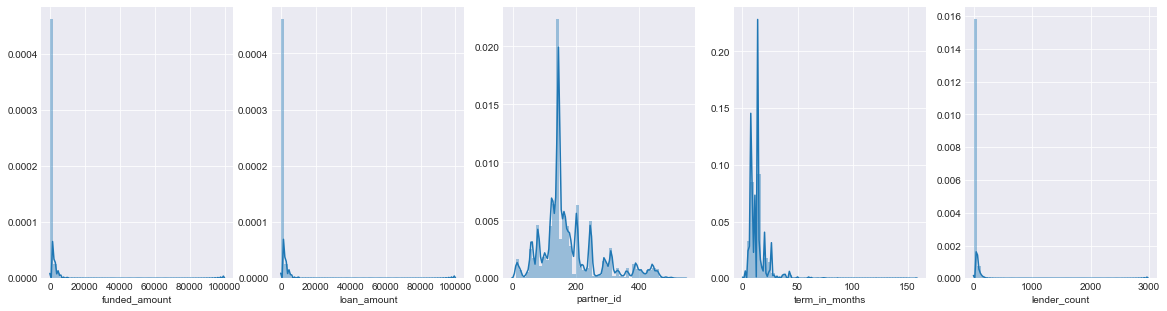

In [71]:
df_kiva_loans_for_dist = df_kiva_loans.copy()
df_kiva_loans_for_dist.index = df_kiva_loans_for_dist['id']
# оставим только столбцы с данными типа int64 и float64
df_kiva_loans_for_dist = df_kiva_loans.loc[:, df_kiva_loans.dtypes!='object'].drop(['id'], axis=1)
# а теперь отобразим все на одном графике
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, column in enumerate(df_kiva_loans_for_dist.columns):
    sns.distplot(df_kiva_loans_for_dist[column], ax=axes[i])
plt.show()

Налицо наличие ряда предельных значений (выбросов). Они искажают распределение, и график не очень-то информативен
в этой форме: нам нужно усечь данные, исключив выбросы из рассмотрения.
Для этого прибегнем к правилу трёх сигм — 68–95–99.7. Это правило гласит, что для нормального распределения:  
* 68.27% значений $ \in [\mu - \sigma , \mu + \sigma]$
* 95.45% значений $ \in [\mu - 2\sigma , \mu + 2\sigma]$
* 99.7% значений $ \in [\mu - 3\sigma , \mu + 3\sigma]$  
где $\mu$ и $\sigma$ — среднее значение и стандартное отклонение нормального распределения.  

Здесь верно, что распределение не обязательно нормальное, но для формы, подобной той, которая у нас есть, мы увидим,
что применение третьего фильтра значительно улучшит наши результаты.  
<img src="https://www.researchgate.net/profile/Bin_Wang111/publication/273955667/figure/fig3/AS:339883190177813@1458045875582/The-confidence-intervals-correspond-to-3-sigma-rule-of-the-normal-distribution.png" width="850" height="442" />

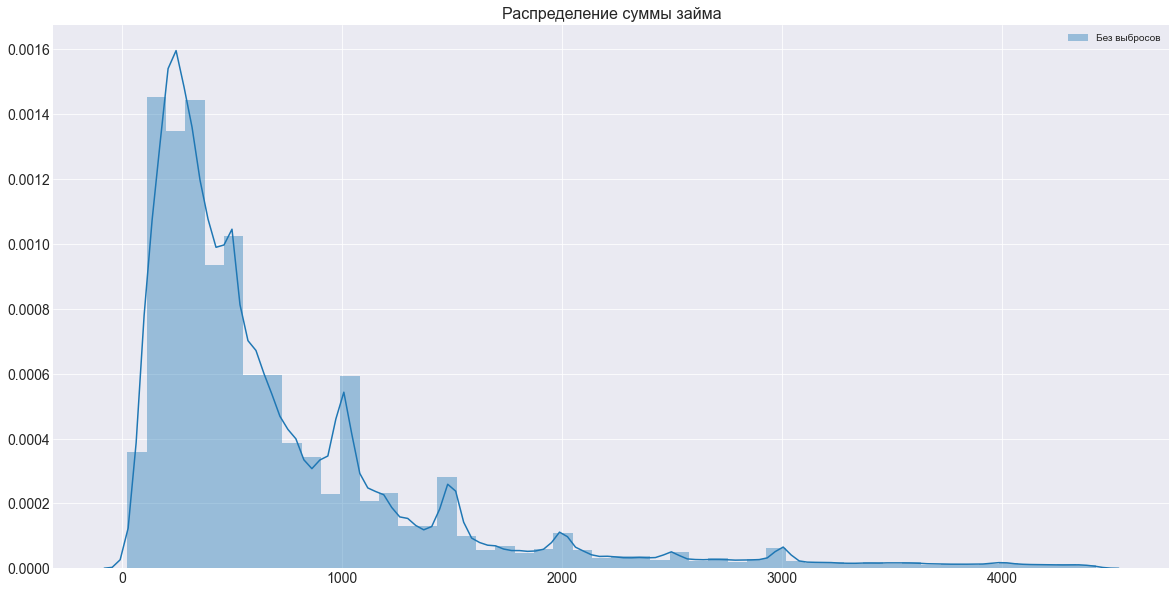

In [12]:
# Наблюдаемое отклонение от среднего
dev = (df_kiva_loans['loan_amount'] - df_kiva_loans['loan_amount'].mean()).abs()
# Стандартное отклонение
std = df_kiva_loans['loan_amount'].std()
# Фильтруем исходный набор данных согласно правилу 3-ех сигм
df_kiva_loans_trimmed = df_kiva_loans[~(dev>3*std)]

plt.figure(figsize=(20,10))
plt.title("Распределение суммы займа", fontsize=16)
plt.tick_params(labelsize=14)
##plt.xticks(np.arange(0, max(df_kiva_loans_trimmed['loan_amount']+1), 200))
sns.distplot(df_kiva_loans_trimmed['loan_amount'], axlabel=False, label='Без выбросов')
plt.legend()
plt.show()

**Вывод:**  
Теперь явно намного лучше! Большинство ссуд составляют от 100 до 600 долларов США с пиковыми значениями в районе 200 и 400 долларов США. Сумма, естественно, уменьшается, но мы можем заметить наличие её нескольких пиков в 1000 (наиболее чёткий),
1500 и 2000 долларов США. Можно предположить, что есть определённый класс проектов, которые являются более
«сложными» и финансируются бОльшими суммами.

### 2.4. Таргетные приёмы для изучения атрибутов датасета и выведения ряда статистик.
Здесь будут представлены приёмы индивидуального характера. В этом пункте представлен разбор различных датасетов.
Данные приемы носят уникальный характер для каждого датасета, но имеются среди них и общеупотребимые.
Их необходимо использовать **для примера**.

#### 2.4.1. Датасет Kiva

In [ ]:
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country']\
.value_counts(normalize=True)> 0.005]
list_countries = list(countries.index)

In [ ]:
countries

Philippines      160441
Kenya             75825
El Salvador       39875
Cambodia          34836
Pakistan          26857
Peru              22233
Colombia          21995
Uganda            20601
Tajikistan        19580
Ecuador           13521
Paraguay          11903
Nicaragua         11781
India             11237
Vietnam           10843
Nigeria           10136
Bolivia            8806
Lebanon            8792
Armenia            8631
Palestine          8167
Samoa              7396
Guatemala          7310
Rwanda             6735
Mali               6639
Honduras           6557
Indonesia          6214
United States      6093
Kyrgyzstan         5774
Togo               5749
Mexico             5741
Sierra Leone       5415
Tanzania           5219
Ghana              4374
Jordan             4167
Zimbabwe           4034
Madagascar         3821
Liberia            3682
Haiti              3618
Mozambique         3483
Name: country, dtype: int64

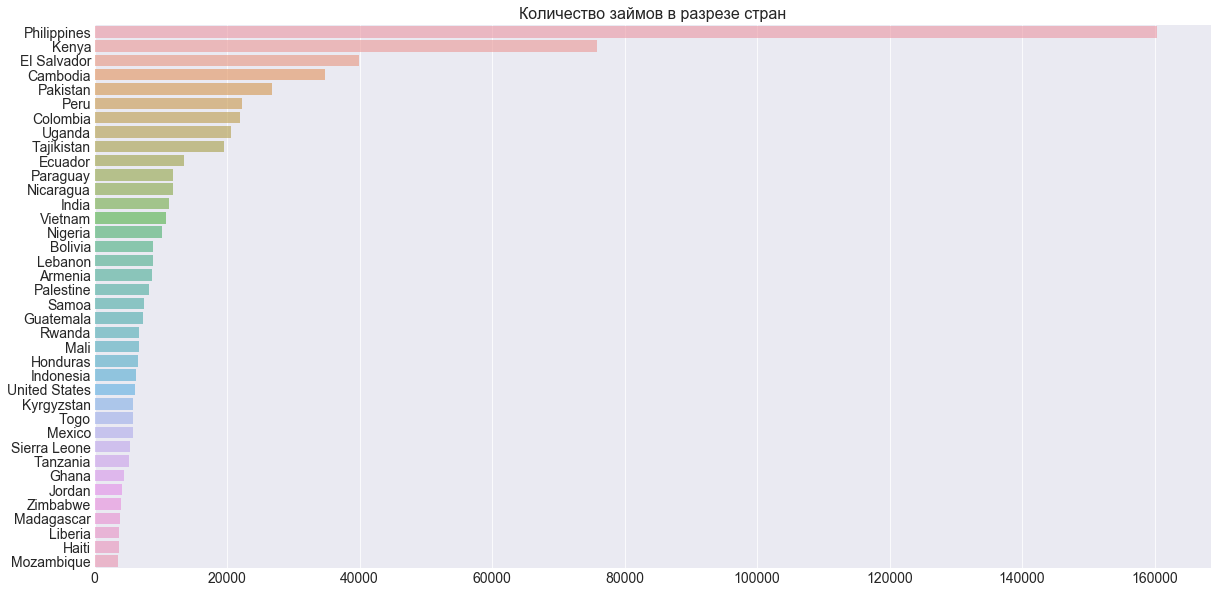

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Количество займов в разрезе стран", fontsize=16)
plt.tick_params(labelsize=14)Z
sns.barplot(y=countries.index, x=countries.values, alpha=0.6)
plt.show()

**Почему на Филиппинах наибольшее количество займов?**

Чуть менее четверти всех займов приходится на Филиппины.

Возможно, потому что там широко распространены краткосрочные и небольшие займы.
Давайте запомним это предположение и внимательнее рассмотрим его позже. Такая стратегия может оказаться наиболее эффективной для точечного и обширного финансирования в условиях бедности и ограниченных возможностей локальных государств.

Мы также можем заметить, что в списке присутствует множество африканских стран, таких как Кения, Мали, Нигерия, Гана. Но вообще ни одной из стран Европейского Союза. Удивительным стало присутствие США в этом списке, поскольку уровень бедности в них не такой, как в других странах. 

Попробуем сгруппировать страны по частям света.



Для этого воспользуемся файлом **kiva_mpi_region_locations**.

In [ ]:
df_mpi.head()

LocationName  ISO      country      region world_region    MPI  \
0  Badakhshan, Afghanistan  AFG  Afghanistan  Badakhshan   South Asia  0.387   
1     Badghis, Afghanistan  AFG  Afghanistan     Badghis   South Asia  0.466   
2     Baghlan, Afghanistan  AFG  Afghanistan     Baghlan   South Asia  0.300   
3       Balkh, Afghanistan  AFG  Afghanistan       Balkh   South Asia  0.301   
4      Bamyan, Afghanistan  AFG  Afghanistan      Bamyan   South Asia  0.325   

                               geo        lat        lon  
0  (36.7347725, 70.81199529999999)  36.734772  70.811995  
1         (35.1671339, 63.7695384)  35.167134  63.769538  
2         (35.8042947, 69.2877535)  35.804295  69.287754  
3         (36.7550603, 66.8975372)  36.755060  66.897537  
4         (34.8100067, 67.8212104)  34.810007  67.821210

In [ ]:
df_mpi_grouped = df_mpi\
    .groupby(['ISO', 'country', 'world_region'])['MPI']\
    .mean()\
    .fillna(0)\
    .reset_index()

In [ ]:
df_kiva_loans = df_kiva_loans.merge(df_mpi_grouped, how='left', on='country')

In [ ]:
regions = df_kiva_loans['world_region'].value_counts()

In [ ]:
regions_list = regions.index.to_list()

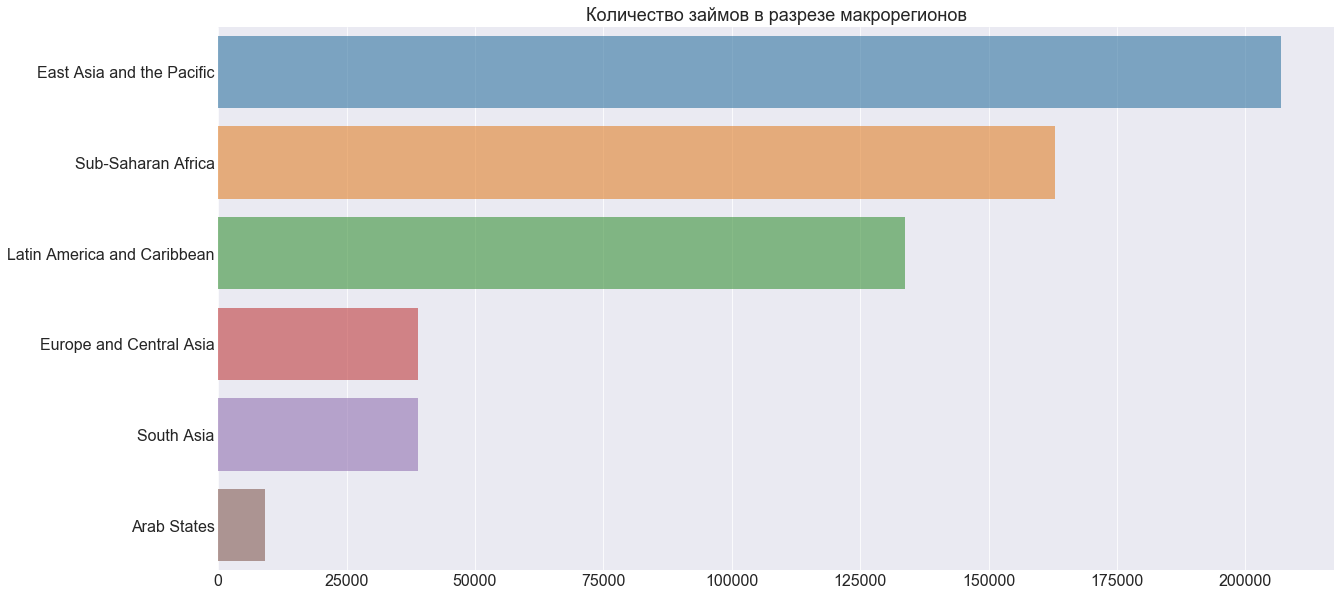

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(y=regions.index, x=regions.values, alpha=0.6)
plt.title("Количество займов в разрезе макрорегионов", fontsize=18)
plt.tick_params(labelsize=16)
plt.show();

Очевидным становится наличие трёх лидеров и трёх аутсайдеров по количеству выданных займов.

Исходя из этого, можно предположить, что в трёх регионах-аутсайдерах либо нет острой потребности в присутствии Kiva (относительно богатые регионы), либо она пока не набрала те обороты, что мы видим в трёх регионах-лидерах. Присутствие региона «Арабские страны» свидетельствует в пользу первого предположения.

### 2.2.2. Люди какого пола обращаются за финансированием?
***

In [ ]:
df_kiva_loans['borrower_genders'].value_counts()

female                                                                                                                                                                                                        426502
male                                                                                                                                                                                                          134710
female, female                                                                                                                                                                                                 12164
female, female, female                                                                                                                                                                                         11676
female, female, female, female                                                                                                                      

Во многих займах заёмщик на самом деле не один человек, а группа людей, у которых есть общий проект. В наборе данных они перечислены как «женщина, женщина, женщина» или «мужчина, женщина». Это объясняет 12к полов, которые мы обнаружили ранее: каждая такая комбинация считается отдельно.

Давайте использовать метку **group** для этих заёмщиков на круговой диаграмме.

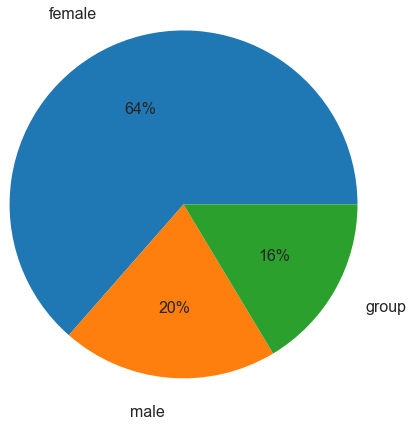

In [ ]:
df_kiva_loans['borrower_genders'] = 
[elem if elem in ['female','male'] else 'group' for elem in df_kiva_loans['borrower_genders'] ]

borrowers = df_kiva_loans['borrower_genders'].value_counts()

plot = borrowers.plot.pie(fontsize=16, autopct='%1.0f%%', labeldistance=1.2, radius=2)

Выясняется, что большинство заёмщиков — женщины, и это весьма неожиданно. 

**Что это может означать?**

Например то, что женщины используют Kiva, чтобы получить финансирование и развивать собственные проекты в странах (большинство из которых являются странами третьего мира), где традиционно женщинам это было сделать крайне тяжело.

**В каких странах подавляющее большинство заёмщиков — женщины?**

In [ ]:
df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['female', 'male'])[-20:]

df_gender_by_country = df_gender_by_country[['female', 'male', 'group']]

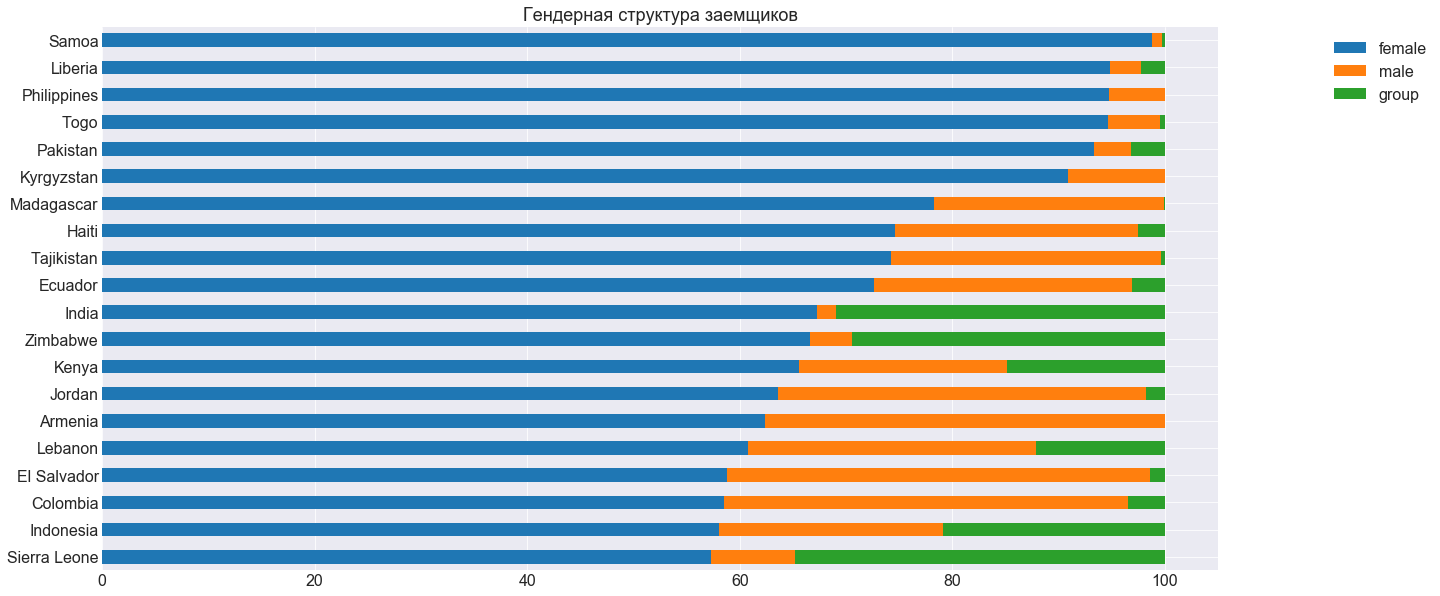

In [ ]:
plot = df_gender_by_country.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

**С чем может быть связана преобладающая доля женщин в структуре заёмщиков в разрезе стрвн?**

Например, в связи с направлениями, традиционно ассоциирующимися с женщинами: различного рода точки общественного питания и закусочные, магазины одежды и товаров для дома, бытовые услуги, выращивание сельскохозяйственных культур

Также можем отметить наличие в списке стран с преобладающей религией ислам, в которых женщине пока, к сожалению, отводится второстепенная роль в принятии решений. 
Kiva позволяет получать бОльшие возможности и перспективы в тех регионах, где ранее это было вряд ли доступно.

**А в каких странах преобладают мужчины? Группа людей?**

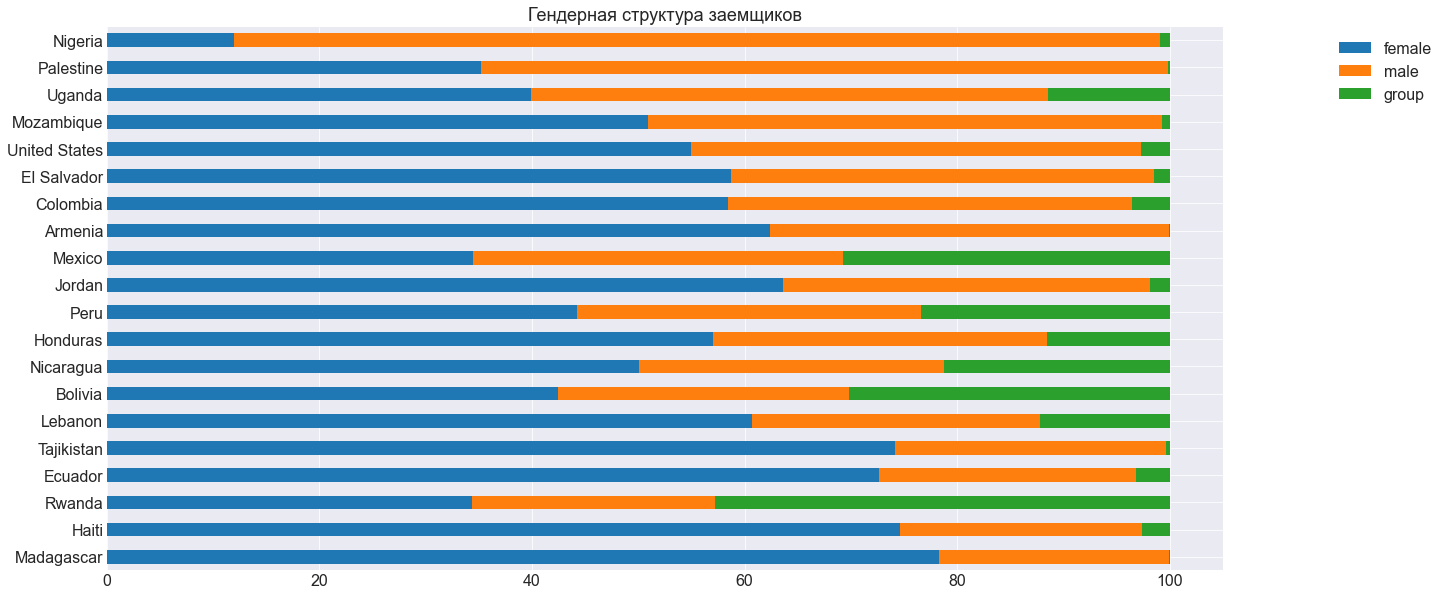

In [77]:
df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['male'])[-20:]

df_gender_by_country = df_gender_by_country[['female', 'male', 'group']]

plot = df_gender_by_country.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

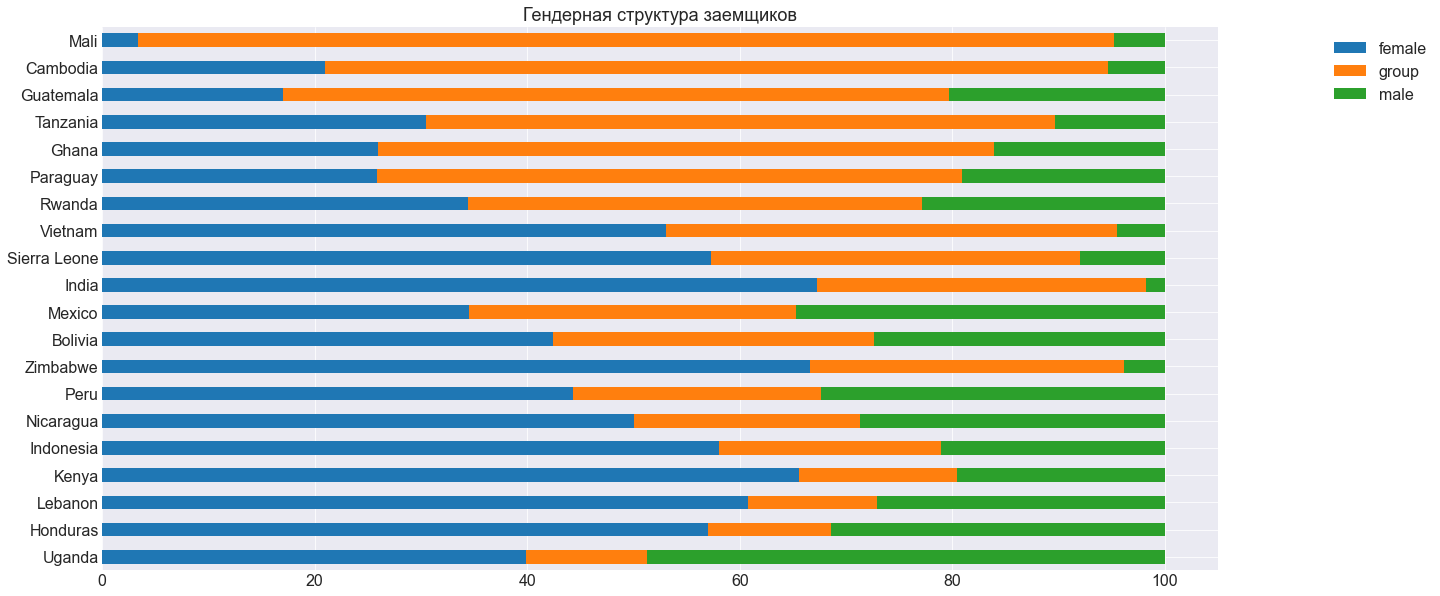

In [78]:
df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['group'])[-20:]

plot = df_gender_by_country.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

In [ ]:
df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['male'])[-20:]

df_gender_by_country = df_gender_by_country[['female', 'male', 'group']]

plot = df_gender_by_country.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['group'])[-20:]

plot = df_gender_by_country.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

## 2.3. Количество займов
***

Теперь давайте посмотрим, для чего людям нужны кредиты и какие суммы они просят. 

### 2.3.1. В разрезе секторов
***

Начнём с секторов экономики. 
В сводке, которую мы видели выше, было 15 уникальных секторов. Рассмотрим, как обстоят дела в каждом из них.

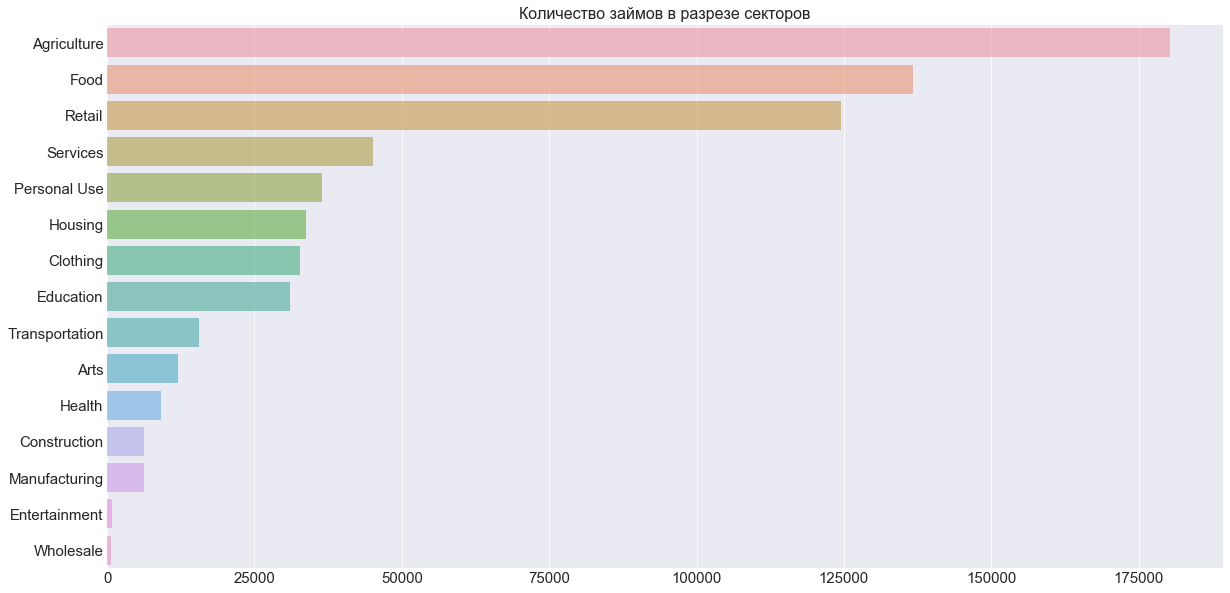

In [ ]:
sectors = df_kiva_loans['sector'].value_counts()

plt.figure(figsize=(20,10))
plt.title("Количество займов в разрезе секторов", fontsize=16)
# plt.xlabel('Number of loans', fontsize=16)
# plt.ylabel("Sectors", fontsize=16)
plt.tick_params(labelsize=15)

sns.barplot(y=sectors.index, x=sectors.values, alpha=0.6)
plt.show()

Самым доминирующим сектором является **сельское хозяйство**, за ним следуют **пищевая промышленность** и **торговля**.
Это неудивительно, учитывая список стран, которые интенсивно используют Kiva. Например, беглый осмотр первых страниц сайта свидетельствует о таких примерах: покупка качественных семян и удобрений для использования на ферме и в садоводческом хозяйстве, закупка свежей еды, злаков, рыбы, овощей для обеспечения работы предприятия общественного питания. Можно сделать ряд выводов о структуре экономик этих стран, свидетельствующих о том, что это сугубо развивающиеся страны, полагающиеся преимущественно на аграрную отрасль.

Важно отметить, что кредиты на **личные нужды** также занимают значительную долю. Это означает, что есть люди, которые используют Kiva, потому что они крайне нуждаются.

Гораздо меньшие доли занимают **строительство**, **производство**, а также сфера **развлечений** и **оптовой торговли**.

### 2.3.2. В разрезе видов деятельности
***

Давайте посмотрим более подробную версию и сделаем подсчёт для **видов деятельности**.

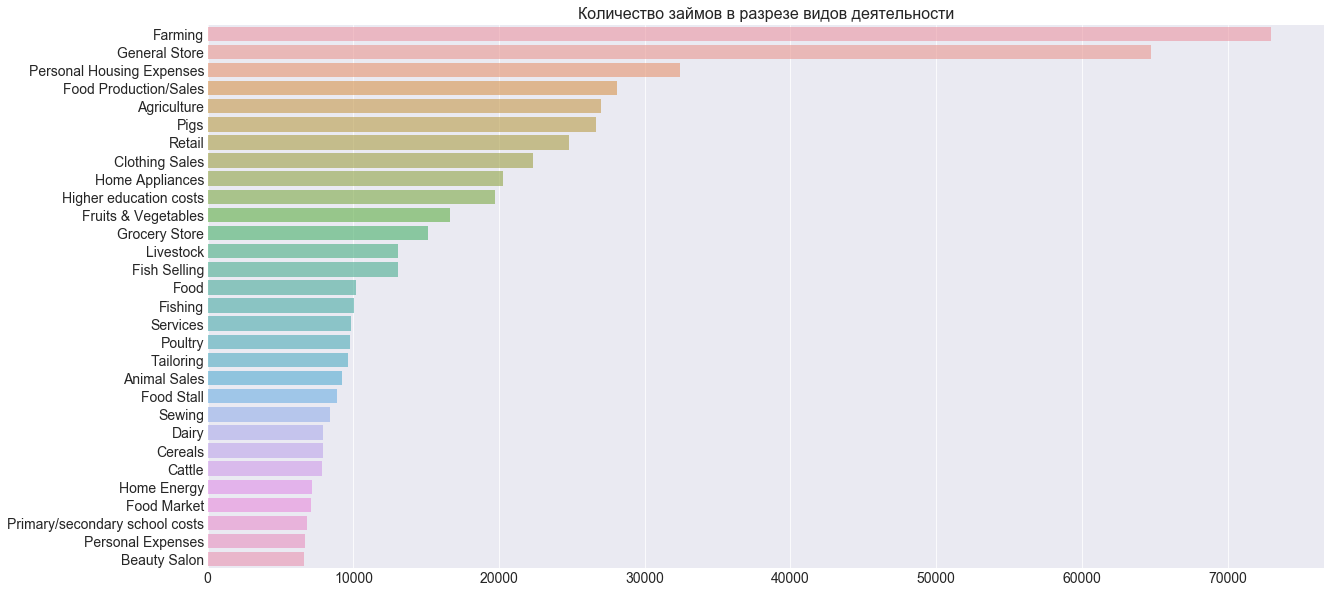

In [ ]:
activities = df_kiva_loans['activity'].value_counts().head(30)

plt.figure(figsize=(20,10))
plt.title("Количество займов в разрезе видов деятельности", fontsize=16)
plt.tick_params(labelsize=14)

sns.barplot(y=activities.index, x=activities.values, alpha=0.6)
plt.show();

Детализация по видам деятельности подтверждает наши наблюдения. В лидерах __фермерство__, **розничные магазины**, **домашнее хозяйство**, а также **расходы на жильё**.

### 2.3.3. Рейтинг целевого назначения займа
***

In [ ]:
activities = df_kiva_loans['use'].value_counts().head(25)
activities.head(25)

to buy a water filter to provide safe drinking water for their family.                                                          5217
to buy a water filter to provide safe drinking water for her family.                                                            4082
To buy a water filter to provide safe drinking water for their family.                                                          2141
to build a sanitary toilet for her family.                                                                                      1708
to build a sanitary toilet for her family                                                                                       1599
to buy ingredients for her food production business                                                                             1419
to purchase more groceries to sell.                                                                                             1409
to buy feed and other supplies to raise her pigs.                    

Интересные выводы можно сделать из описания назначения каждого займа.

В лидерах по целевому назначению займов — вещи, удовлетворяющие базовые человеческие потребности, такие как **покупка фильтра для воды**, **оборудование септика**, **светильники на солнечных батареях**.

### 2.3.4. Наиболее популярные виды деятельности
***

Сейчас предлагаю наглядно сравнить наиболее популярные направления займов.
Для этого сгруппируем займы по признакам **sector, activity** и посмотрим на топ-10 в каждой группе.

In [ ]:
loans_by_activity_sector = \
    df_kiva_loans[df_kiva_loans['sector'].isin(sectors[:9].index.values)]\
    .groupby(['sector', 'activity'])['loan_amount']\
    .count()\
    .reset_index()

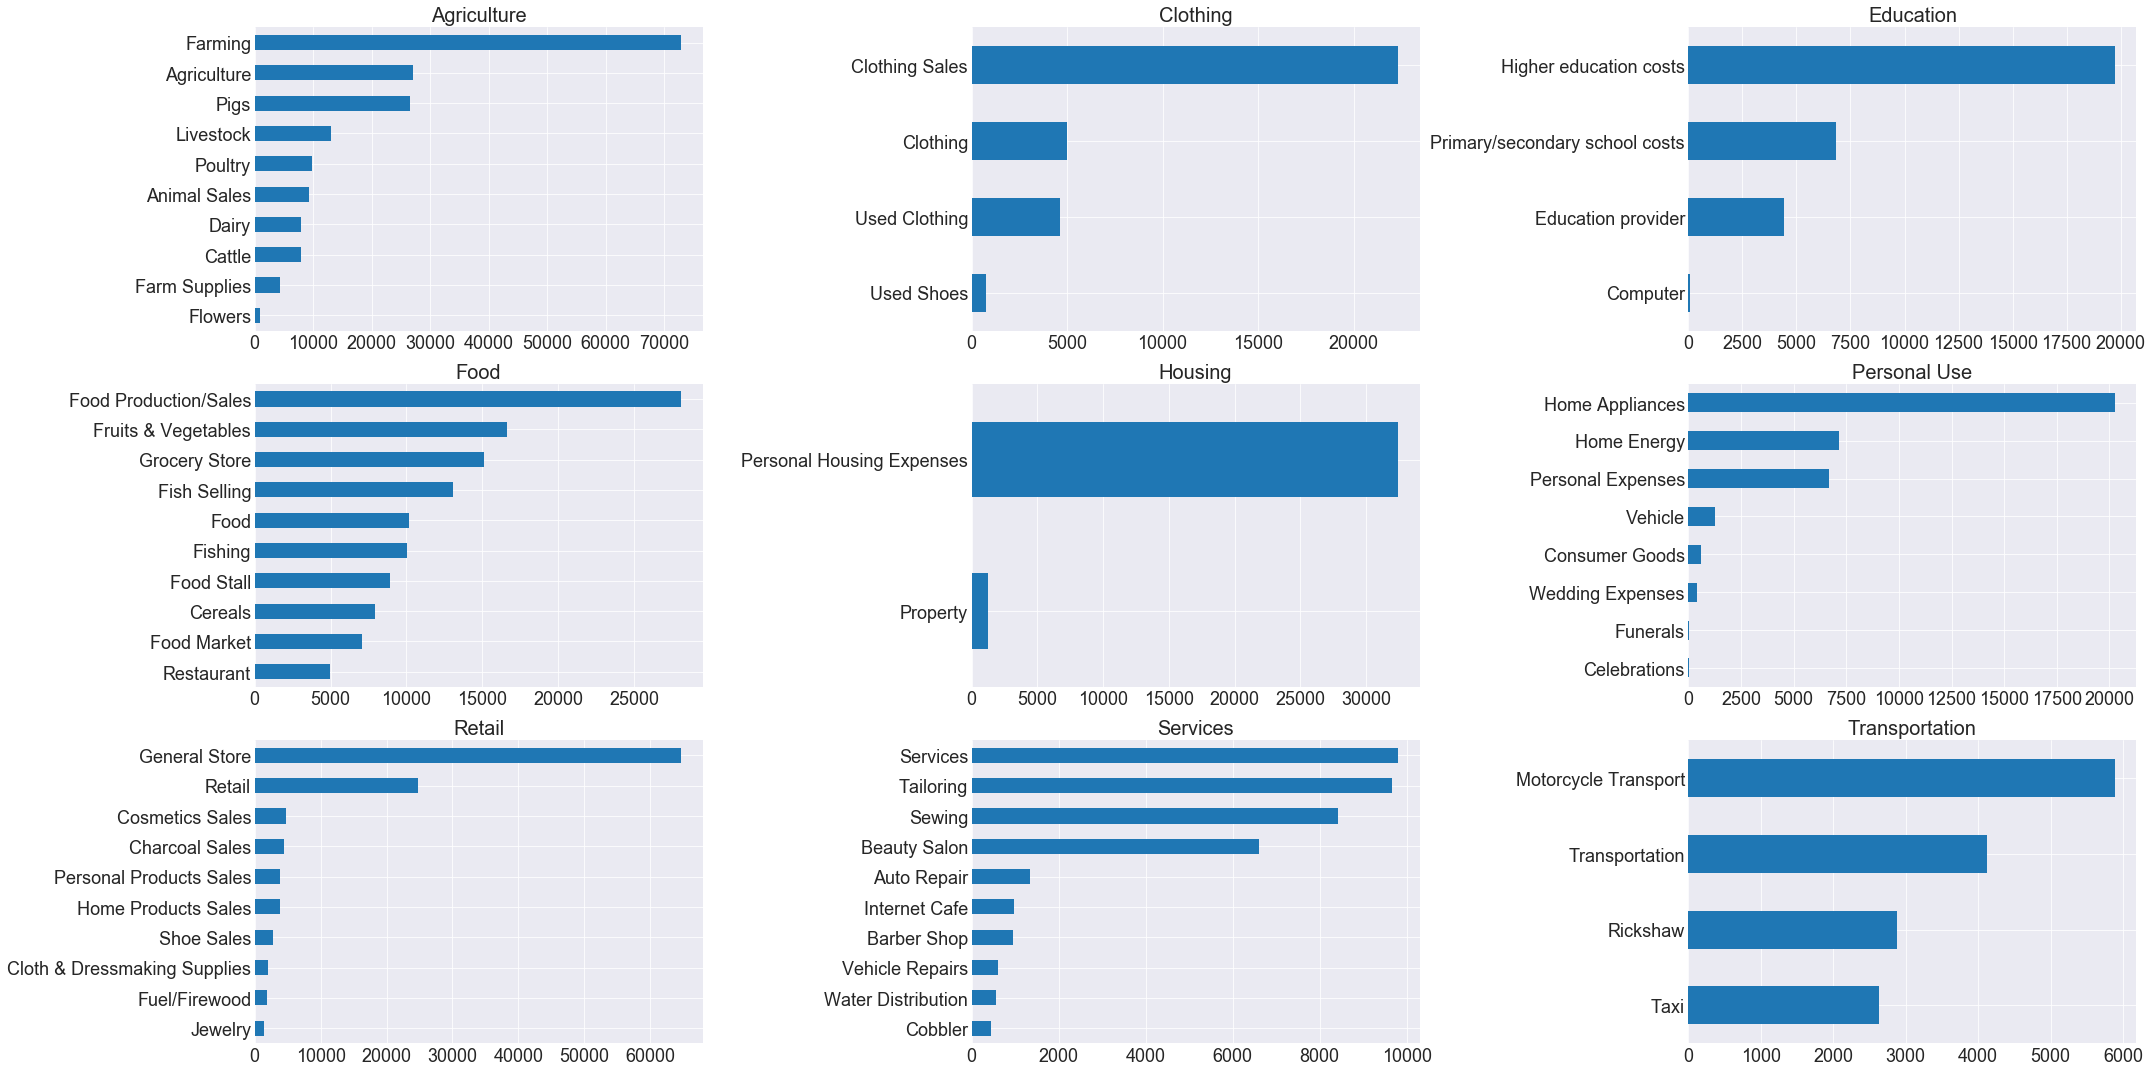

In [ ]:
fig,axes = plt.subplots(3,3, sharex=False, squeeze=False, figsize=(30,15))

for ax,q in zip(axes.ravel(), loans_by_activity_sector.sector.unique()):
    tmp_df = loans_by_activity_sector[loans_by_activity_sector.sector.eq(q)]\
                .dropna()\
                .sort_values(by='loan_amount')[-10:]
    ax.set_title(q, fontsize=20)  
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    tmp_df.plot.barh(x='activity', ax=ax, legend=None, fontsize=18)

Основной вывод, который мы можем сделат: львиная доля займов направлены на деятельность с невысокой добавленной стоимостью — **сельское хозяйство, розничная торговля, сервис**. То есть деятельность, в которой минимально задействованы смежные сектора экономики и невысок потенциал создания дополнительных рабочих мест и продуктов внутри страны, в отличие от, например, **производственных предприятий, строительства, ремесленных мастерских, лёгкой промышленности**.

И тем не менее не может не радовать присутствие такого направления, как, например, **образование**: финансирование обучения школах и университетах, организация и подготовка курсов и образовательных программ.

## 2.4. Объём финансирования
***

2.4.1. Распределение суммы займа
***

Не менее важную информацию могут дать абсолютные значения займов, которые люди в разных странах запрашивают на реализацию своих целей.

Давайте посмотрим на график распределения сумм займов.

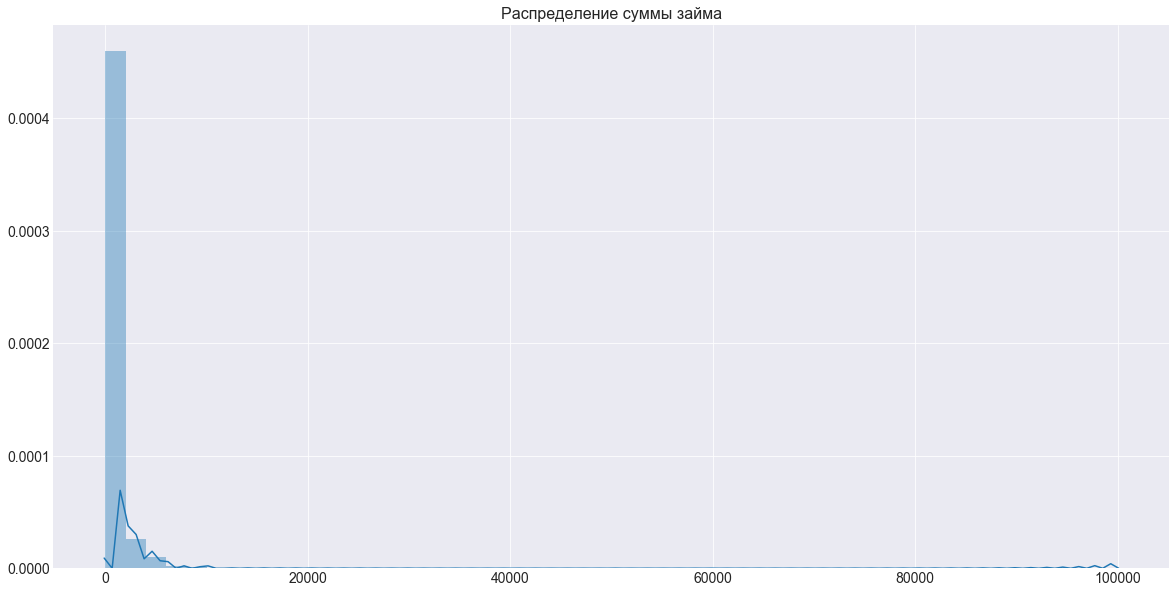

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Распределение суммы займа", fontsize=16)
plt.tick_params(labelsize=14)

sns.distplot(df_kiva_loans['loan_amount'], axlabel=False)
plt.show()

Налицо наличие ряда предельных значений (выбросов). Они искажают распределение, и график не очень-то информативен в этой форме: нам нужно **усечь данные**, исключив выбросы из рассмотрения. Каким образом мы можем это сделать?

Предлагаю использовать основное, но очень мощное правило: правило трёх сигм — **68–95–99.7**. Это правило гласит, что для нормального распределения:
* 68.27% значений $ \in [\mu - \sigma , \mu + \sigma]$
* 95.45% значений $ \in [\mu - 2\sigma , \mu + 2\sigma]$
* 99.7% значений $ \in [\mu - 3\sigma , \mu + 3\sigma]$  
где $\mu$ и $\sigma$ — среднее значение и стандартное отклонение нормального распределения.

Здесь верно, что распределение не обязательно нормальное, но для формы, подобной той, которая у нас есть, мы увидим, что применение третьего фильтра **значительно улучшит наши результаты**.

<img src="https://www.researchgate.net/profile/Bin_Wang111/publication/273955667/figure/fig3/AS:339883190177813@1458045875582/The-confidence-intervals-correspond-to-3-sigma-rule-of-the-normal-distribution.png" width="850" height="442" />



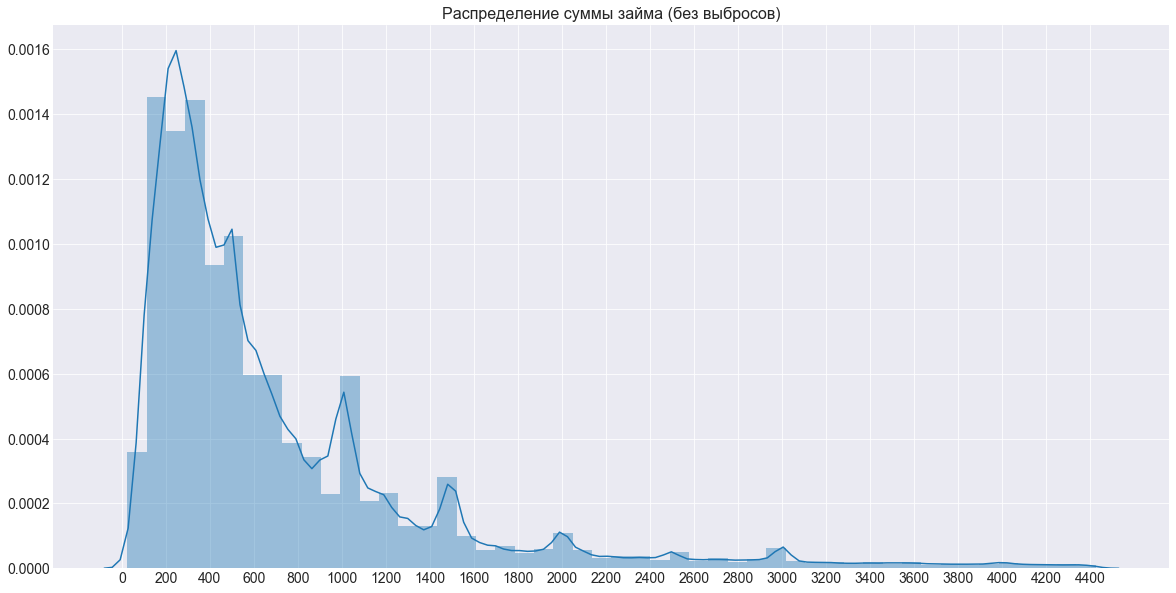

In [ ]:
# Наблюдаемое отклонение от среднего
dev = (df_kiva_loans['loan_amount']-df_kiva_loans['loan_amount'].mean()).abs()
# Стандартное отклонение
std = df_kiva_loans['loan_amount'].std()
# Фильтруем исходный набор данных
df_kiva_loans_trimmed = df_kiva_loans[~(dev>3*std)]

plt.figure(figsize=(20,10))
plt.title("Распределение суммы займа (без выбросов)", fontsize=16)
plt.tick_params(labelsize=14)
plt.xticks(np.arange(0, max(df_kiva_loans_trimmed['loan_amount']+1), 200))

sns.distplot(df_kiva_loans_trimmed['loan_amount'], axlabel=False)
plt.show()

Теперь явно намного лучше!

* Большинство ссуд составляют от 100 до 600 долларов США с пиковыми значениями в районе 200 и 400 долларов США.
* Сумма, естественно, уменьшается, но мы можем заметить наличие её нескольких пиков в 1000 (наиболее чёткий), 1500 и 2000 долларов США. Можно предположить, что есть определённый класс проектов, которые являются более «сложными» и финансируются бОльшими суммами.

### 2.4.2. Суммы займа в разрезе секторов
***

Как насчёт больших подробностей? У нас есть информация о сумме кредита в целом, давайте теперь посмотрим разбиение по секторам:

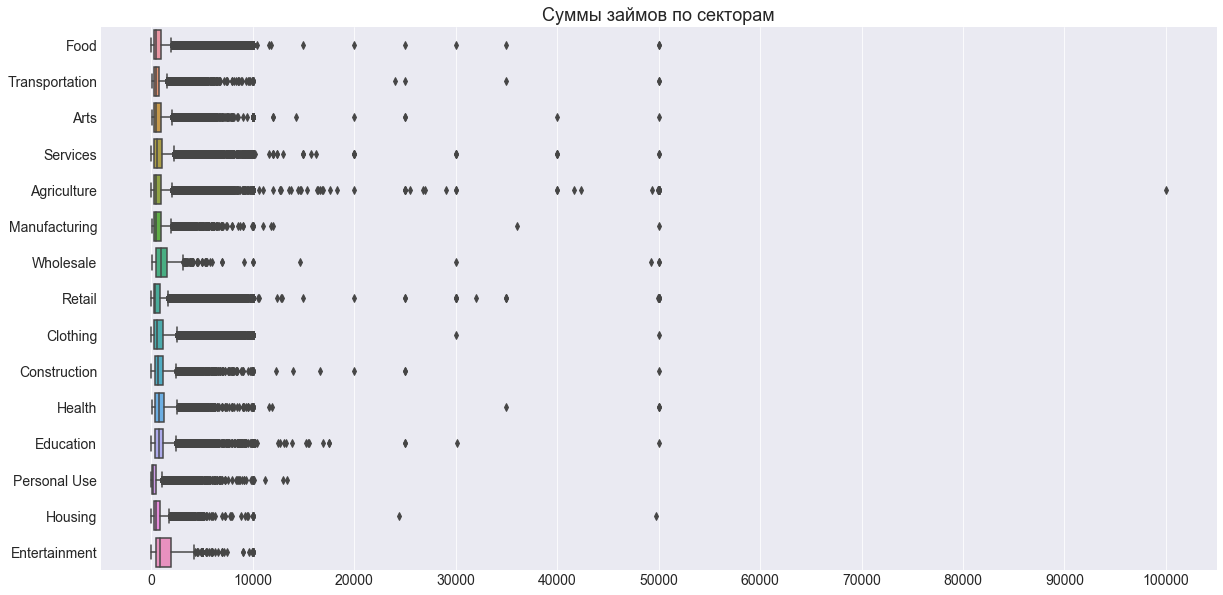

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Суммы займов по секторам", fontsize=18)
plt.xticks(np.arange(0, max(df_kiva_loans['loan_amount']+1), 10000))
plt.tick_params(labelsize=14)

sns.boxplot(x='loan_amount', y="sector", data=df_kiva_loans).set(ylabel=None, xlabel=None)
plt.show()

Как видите, для любого сектора есть значения-выбросы. И почти для всех секторов, кроме **личные нужды, индустрия развлечений**, — наличие займов на суммы в районе $50.000.

Например, кажется, что кто-то запросил кредит на 100 000 для сельскохозяйственного проекта. Есть также много займов на суммы 20к, 50к.

`Вопрос для самостоятельной работы:`

**Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей?**

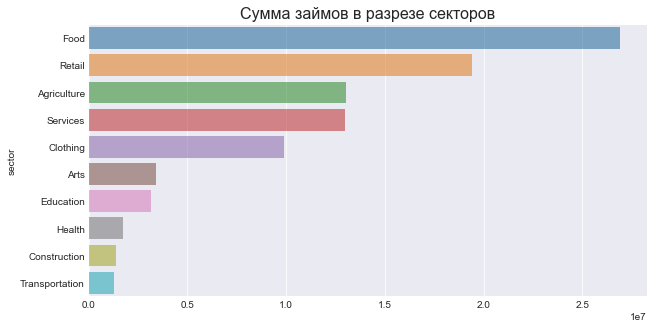

In [79]:
# Фильтруем исходный набор данных в пользу выбросов
df_kiva_loans_blowout = df_kiva_loans[dev>3*std]

# Распределение заявок по секторам
sectors = df_kiva_loans_blowout.groupby('sector')['loan_amount'].sum()\
.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.title("Сумма займов в разрезе секторов", fontsize=16)
plt.tick_params(labelsize=10)

sns.barplot(y=sectors.index, x=sectors.values, alpha=0.6)
plt.show()

Как можно видеть наибольшие суммы были собраны для пяти секторов экономики: **пищевая промышленность, торговля, сельское хозяйство, сфера услуг, одежда**. Посмотрим на виды деятельности.

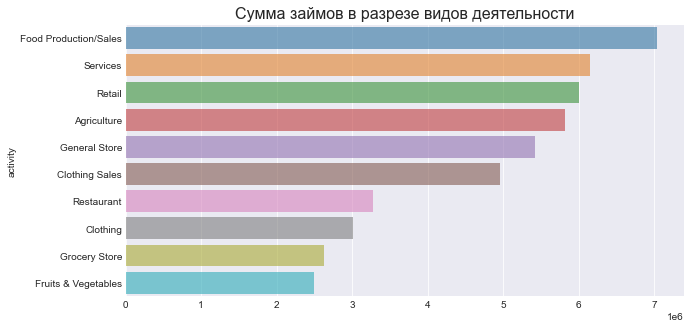

In [80]:
activities = df_kiva_loans_blowout.groupby('activity')['loan_amount'].sum()\
.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.title("Сумма займов в разрезе видов деятельности", fontsize=16)
plt.tick_params(labelsize=10)

sns.barplot(y=activities.index, x=activities.values, alpha=0.6)
plt.show()

Картина в разрезе видов деятельности показывает, что за большими деньгами, выделенными на **пищевую промышленность** стоит продажа продуктов. 
С **оказанием услуг, торговлей и сельским хозяйством** картина аналогичная разрезу по секторам.  

In [81]:
uses = df_kiva_loans_blowout['use'].value_counts().head(25)
uses.head(25)

to buy cattle.                                           32
to buy clothing wholesale.                               20
to buy wool wholesale.                                   19
to buy more charcoal to sell.                            15
to buy seeds and fertilizers.                            15
to buy more rice, sugar, biscuits and juice to sell.     14
to buy more rice, sugar, biscuits and juice for sale.    14
to buy more beer for sale.                               14
to buy more beer to sell.                                14
to buy natural remedies to sell.                         13
to buy clothing.                                         13
to buy milk, sugar, oil, and rice.                       12
to cover higher education expenses.                      12
to purchase wool in bulk.                                12
to buy wholesale clothing.                               11
to buy more clothes to sell.                             11
to buy rice, sugar, milk, and cookies.  

Наиболее частыми запросами были **покупка скота**, **покупка материала для производства одежды**, а также **покупка еды для дальнейшей её продажи**

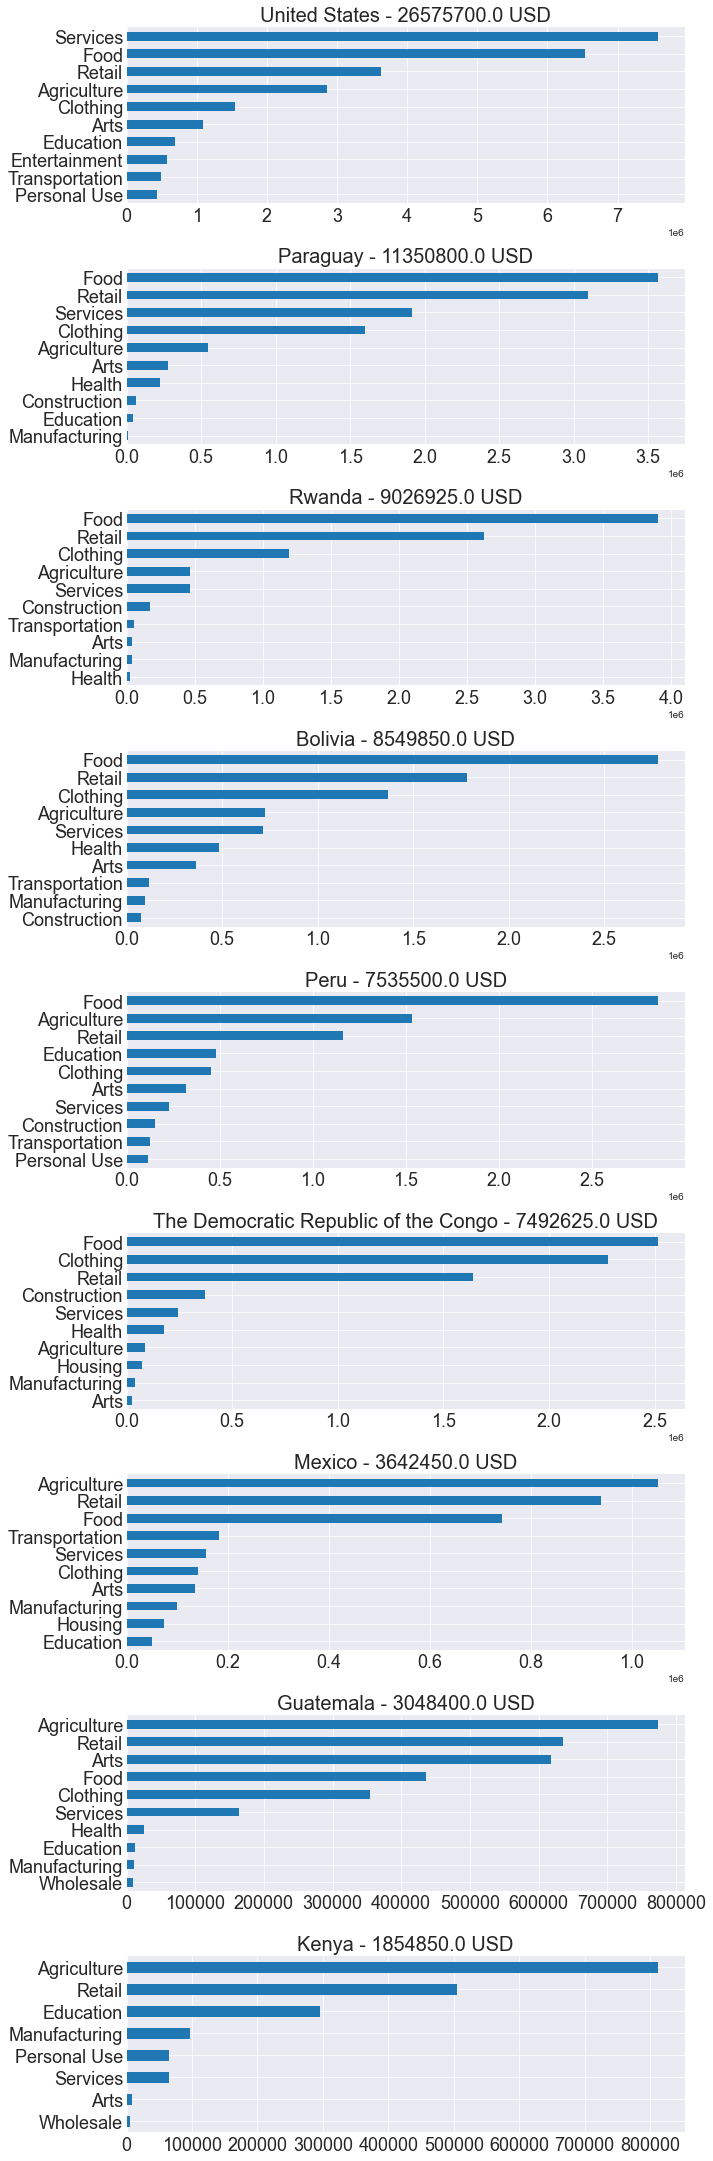

In [82]:
countries = df_kiva_loans_blowout.groupby('country')['loan_amount'].sum()\
.sort_values(ascending=False).head(9)

loans_by_sector_country = \
    df_kiva_loans_blowout[df_kiva_loans_blowout['country'].isin(countries[:9].index.values)]\
    .groupby(['country', 'sector'])['loan_amount']\
    .sum()\
    .reset_index()

fig,axes = plt.subplots(9,1, sharex=False, squeeze=False, figsize=(10,30))

for ax,q in zip(axes.ravel(), countries[:9].index):
    tmp_df = loans_by_sector_country[loans_by_sector_country.country.eq(q)]\
                .dropna()\
                .sort_values(by='loan_amount')[-10:]
    country_sum = loans_by_sector_country[loans_by_sector_country['country'] == q]['loan_amount'].sum()
    ax.set_title(f'{q} - {country_sum} USD', fontsize=20)  
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    tmp_df.plot.barh(x='sector', ax=ax, legend=None, fontsize=18)

Штаты в лидерах по общей сумме займа! Как ни удивительно, но американцам было выдано 26 млн USD и это больше, чем Парагваю (11 млн USD). Можно попробовать это связать с доступностью платформы и уровнем цифровизации населения.

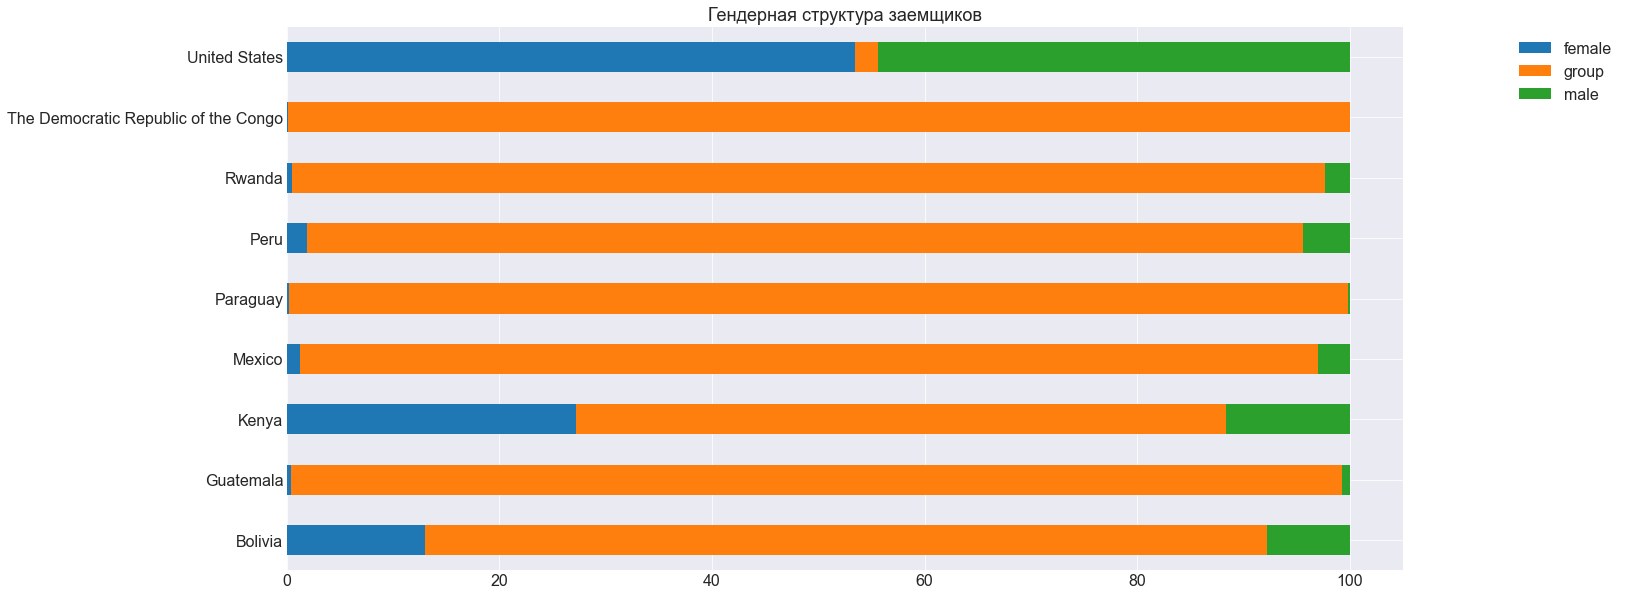

In [83]:
df_gender_by_country = \
    df_kiva_loans_blowout[df_kiva_loans_blowout['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)

plot = df_gender_by_country.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

И такие большие показатели американцы набрали по одиночным заявкам, а не групповым как в остальных странах.

Давайте взглянем на средние и медианные значения суммы займа по секторам:

In [ ]:
sector_mean_median = df_kiva_loans\
    .groupby(['sector'])['loan_amount']\
    .agg(median='median', mean='mean')\
    .sort_values(by='median', ascending=False)

sort_order = sector_mean_median.index.to_list()

sector_mean_median

median         mean
sector                             
Wholesale        950.0  1569.716088
Entertainment    887.5  1673.674699
Education        725.0   998.565924
Health           725.0  1067.266616
Construction     700.0  1068.147735
Clothing         600.0  1139.237829
Services         550.0  1064.631148
Agriculture      500.0   793.490228
Housing          500.0   701.549020
Manufacturing    500.0   877.561211
Arts             475.0  1014.952322
Food             450.0   889.864039
Transportation   450.0   713.165356
Retail           425.0   788.173727
Personal Use     200.0   411.030644

А также график, после того как мы избавимся от выбросов:

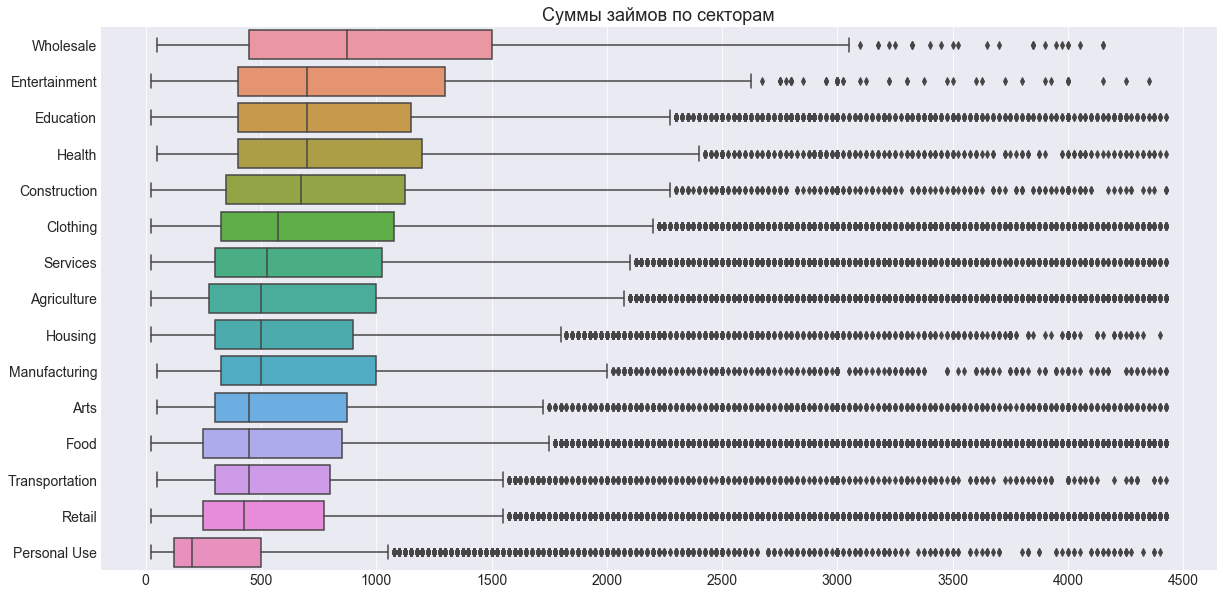

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Суммы займов по секторам", fontsize=18)
plt.xticks(np.arange(0, max(df_kiva_loans['loan_amount']+1), 500))
plt.tick_params(labelsize=14)

sns.boxplot(x='loan_amount', y="sector", order=sort_order, data=df_kiva_loans_trimmed).set(ylabel=None, xlabel=None)
plt.show()

Прежде всего нужно отметить, что именно медиана даёт робастную (устойчивую к выбросам) оценку центрального положения суммы займа.

Из графика становится ясно, что медиана суммы заявок на **личные нужды** обладает наименьшим значением. Личные нужды включают предменты обихода и первой необходимости, обеспечение жилища энергией, теплом и водой. Именно эта группа заявок может свидетельствовать о случаях крайней нужды и бедности в различных странах.

На другой стороне графика сектора с самыми большими показателями медианы суммы займа: **оптовая торговля**, требующая значительнх затрат на закупку, что вполне логично; **образование** и **здравоохранение**, а также **сфера развлечений**.

### 2.4.3. Распределение по макрорегионам
***

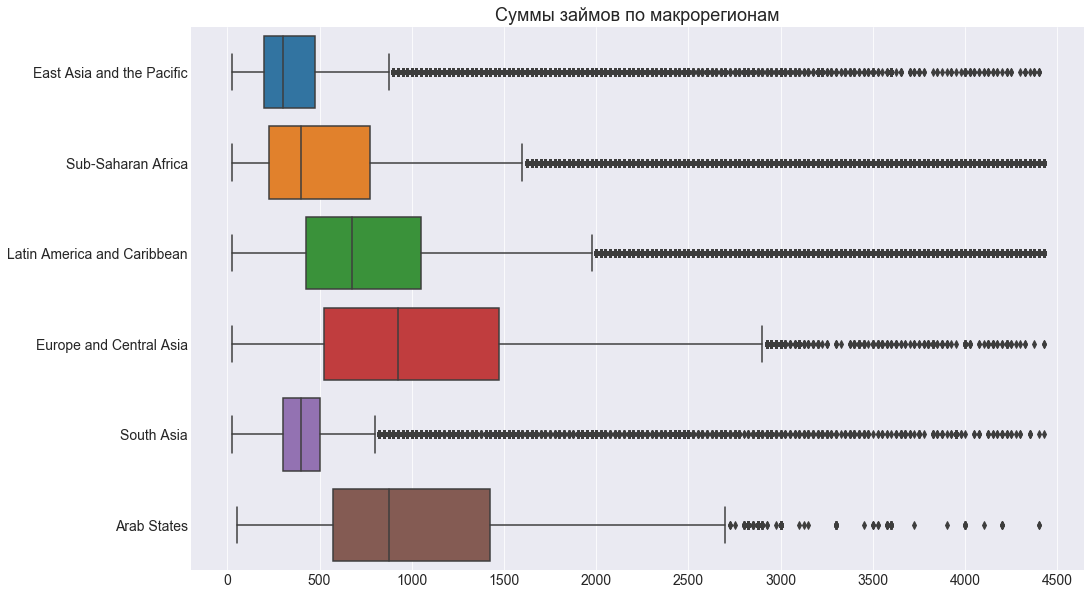

In [ ]:
plt.figure(figsize=(16,10))
plt.title("Суммы займов по макрорегионам", fontsize=18)
plt.xticks(np.arange(0, max(df_kiva_loans['loan_amount']+1), 500))
plt.tick_params(labelsize=14)

sns.boxplot(x='loan_amount', y="world_region", order=regions_list, data=df_kiva_loans_trimmed)\
    .set(ylabel=None, xlabel=None)
# plt.legend(loc=1, bbox_to_anchor=(1.15, 1), fontsize=16)
plt.show()

Регионы расположены в порядке убывания количества займов (в соответствии с графиком, полученным в п. 2.2.1).

Скорее всего, те регионы, в которых медианные значения ниже, в целом беднее и требуют финансирования короткими, небольшими, но частыми займами. Эту ситуацию мы и наблюдаем в регионе **Юго-Восточная Азия**, лидерами в котором являются **Филиппины** и **Камбоджа**.

Однако на этом графике мы можем заметить регион, который выбивается из последовательности, — **Южная Азия**, а в частности такие страны, как **Пакистан** и **Индия**. Вполне вероятно, что в этом регионе есть отличная площадка для расширения присутствия и поддержки со стороны сообщества Kiva.

**Попробуйте найти связь между странами (макрорегионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных?**

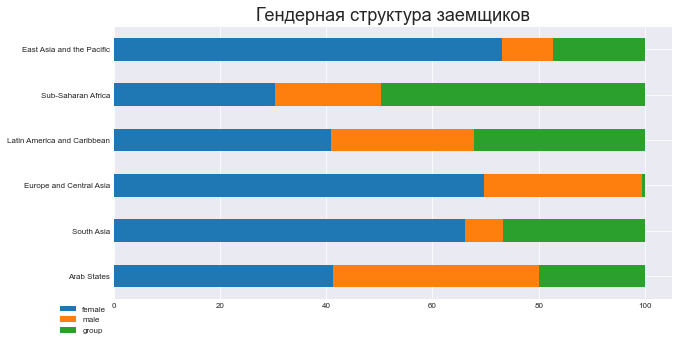

In [84]:
df_gender_by_region = \
df_kiva_loans[df_kiva_loans['world_region'].isin(regions_list)]\
.groupby(['world_region', 'borrower_genders'])['loan_amount']\
.sum()\
.groupby(level=0).apply(lambda x: 100 * x / x.sum())\
.unstack('borrower_genders')\
.fillna(0)
df_gender_by_region = df_gender_by_region.reindex(regions_list)[['female', 'male', 'group']][::-1]

plot = df_gender_by_region.plot.barh(
figsize=(10,5),
fontsize=8,
stacked=True,
title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(0, 0), fontsize=8)
plot.set(ylabel=None, xlabel=None)
plt.show()

Продолжая исследование регионов, можно заметить, что преобладание женской части населения в общей сумме займов характерно
для азиатских стран. Причем для Юго-Восточной и Южной Азии, где часты заявки, но малы суммы,
отличным примером является Центральная Азия, где медианная суммая заявки достаточна высока.
Во всех остальных регионах распределение общей суммы займа примерно одинаковое для мужчин, женщин и групп людей

Зависимость пола заёмщика от региона планеты

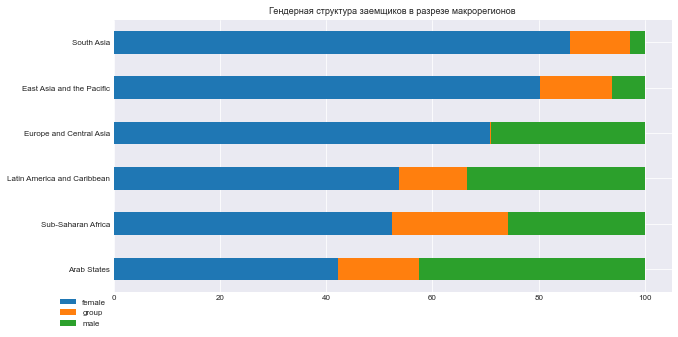

In [85]:
df_gender_by_region = \
df_kiva_loans[df_kiva_loans['world_region'].isin(regions.index.values)]\
.groupby(['world_region', 'borrower_genders'])['borrower_genders']\
.count()\
.groupby(level=0).apply(lambda x: 100 * x / x.sum())\
.unstack('borrower_genders')\
.fillna(0)\
.sort_values(by=['female', 'male'])[-20:]
df_gender_by_country = df_gender_by_country[['female', 'male', 'group']]

plot = df_gender_by_region.plot.barh(
figsize=(10,5)
, fontsize=8
, stacked=True
, title='Гендерная структура заемщиков в разрезе макрорегионов')
plot.title.set_size(9)
plot.legend(loc=1, bbox_to_anchor=(0, 0), fontsize=8)
plot.set(ylabel=None, xlabel=None)
plt.show()

Следует повториться и сказать, что в азиатских странах преобладают заявки от женской части населения. Теперь посмотрим на зависимость пола заёмщика от сектора экономики.

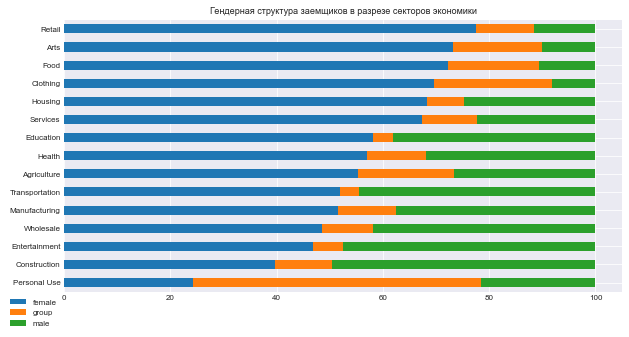

In [86]:
df_gender_by_sector = \
df_kiva_loans.groupby(['sector', 'borrower_genders'])['borrower_genders']\
.count()\
.groupby(level=0).apply(lambda x: 100 * x / x.sum())\
.unstack('borrower_genders')\
.fillna(0)\
.sort_values(by=['female', 'male'])[-20:]
df_gender_by_country = df_gender_by_country[['female', 'male', 'group']]

plot = df_gender_by_sector.plot.barh(
figsize=(10,5)
, fontsize=8
, stacked=True
, title='Гендерная структура заемщиков в разрезе секторов экономики')
plot.title.set_size(9)
plot.legend(loc=1, bbox_to_anchor=(0, 0), fontsize=8)
plot.set(ylabel=None, xlabel=None)
plt.show()

По графику видно сильное преобладание заявок от именно женщин. Особенно этим отличились такие сфера как **розничная торговля,
искусство, пищевая промышленность, производство одежды, ведение домашнего хоз-ва, сфера услуг, образование,
здравохранение и селськое хоз-во**.
Повышение доли заявок от мужчин замечено в **оптовой торговле, сфере развлечений и строительстве**.
Зависимость пола от сектора экономики почти не прослеживается

## 2.5. Время ожидания средств
***

Итак, мы увидели, где Kiva наиболее популярна, типы деятельности и заёмщиков, которые нуждаются в деньгах, а также сколько денег они обычно просят. Отлично!

Следующий интересный вопрос, который мы можем задать: как долго им действительно приходится ждать финансирования? К счастью, у нас есть две колонки, которые помогут нам в исследовании:

* **posted_time**: соответствует дате + точный час, когда заявка появилась на сайте.
* **disbursed_time**: соответствует дате + точный час, когда деньги фактически были получены адресатом.

1. Отбрасываем строки с пропущенными значениями для «disbursed_time», получаем столбцы в правильном формате.
2. Вычисляем интервал между датами.
3. Исключим из рассмотрения заявки, для которых деньги сначала фактически выдаются агентами на местах и только потом публикуются на сайте.

In [ ]:
# drop na (missing) values
df_loans_dates = df_kiva_loans_trimmed.dropna(subset=['disbursed_time', 'funded_time'], how='any', inplace=False)

# dates columns:
dates = ['posted_time','disbursed_time']

# format dates:
df_loans_dates[dates] = df_loans_dates[dates].applymap(lambda x : x.split('+')[0])
df_loans_dates[dates] = df_loans_dates[dates].apply(pd.to_datetime)

# calculate time interval
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['disbursed_time']-df_loans_dates['posted_time']
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['time_funding'] / timedelta(days=1) 

# remove outliers +-3 sigma
dev = (df_loans_dates['time_funding']-df_loans_dates['time_funding'].mean()).abs()
std = df_loans_dates['time_funding'].std()
# Keep rows where time_funding interval > 0 only
df_loans_dates_trimmed = df_loans_dates[~(dev>3*std) & (df_loans_dates.loc[:, 'time_funding']>0)]

### 2.5.1. Количество дней до полного финансирования заявки
***

Отлично! Мы получили расчётную величину.
Теперь построим график распределения количества дней до полного финансирования заявки:

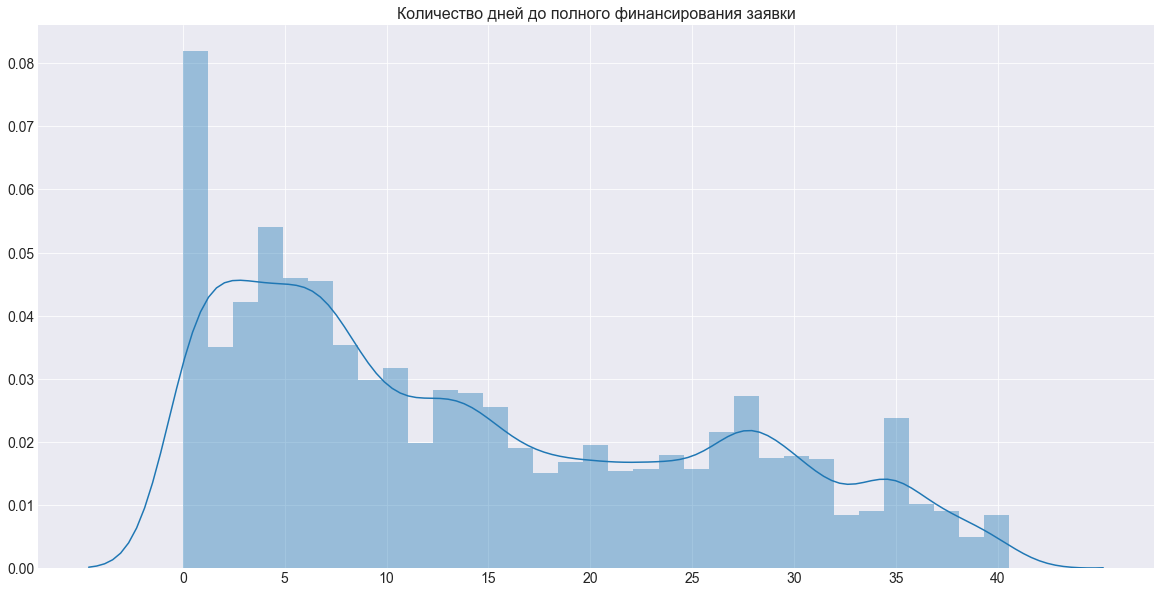

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Количество дней до полного финансирования заявки", fontsize=16)
plt.xticks(np.arange(0, max(df_loans_dates_trimmed['time_funding']+1), 5))
plt.tick_params(labelsize=14)

sns.distplot(df_loans_dates_trimmed['time_funding']).set(ylabel=None, xlabel=None)
plt.show()

БОльшая часть заявок финансируется в течение 10 дней.

Однако также очевидно и наличие пиков в районе 27, 35 дней. Это уже может свидетельствовать о том, что часть заявок проходят довольно длительный процесс 
финансирования.

### 2.5.2. Время ожидания и суммы займов 
***

Для визуализации зависимости суммы займа и временного интервала финансирования давайте построим **тепловую карту**:

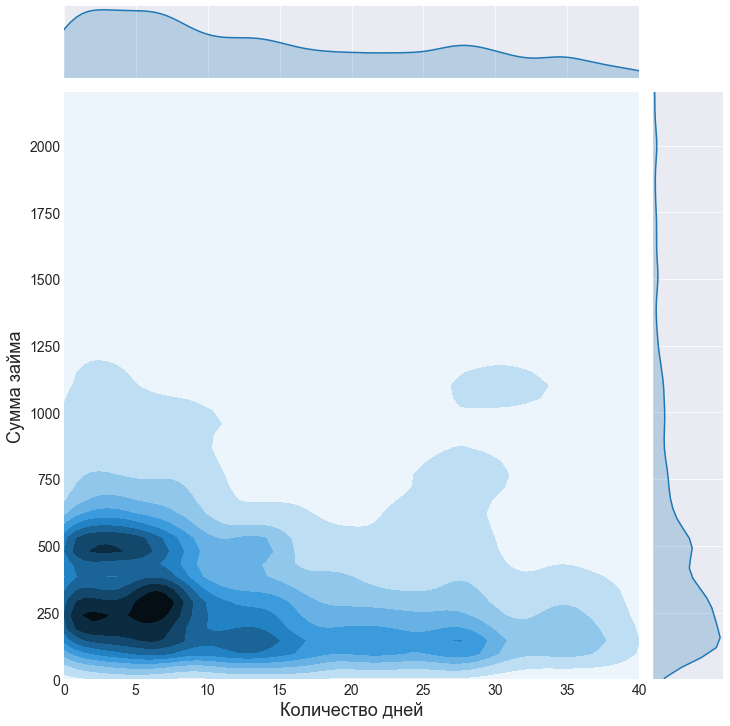

In [ ]:
p = sns.jointplot(x="time_funding", y="loan_amount", data=df_loans_dates_trimmed, kind='kde', height=10, ratio=7, xlim=[0,40] , ylim=[0,2200])\
        .set_axis_labels("Количество дней", "Сумма займа", size=18)

# p.ax_joint.set_xticks(np.arange(0, max(df_loans_dates_trimmed['time_funding']+1), 5))
# p.ax_joint.set_yticks(np.arange(0, max(df_loans_dates_trimmed['loan_amount']+1), 250))
p.ax_joint.tick_params(labelsize=14)

plt.show()

На тепловой карте области, выделенные одним цветом, содержат одинаковое количестчо заявок. При этом области с более насыщенными, тёмными цветами содержат бОльшее количество заявок, чем более светлые области.

Действительно, возрастающее количество дней, требуемое для финансирования заявки, можно объяснить возрастающей суммой, но только отчасти.

Мы также можем видеть наличие большого количества заявок на суммы до **$250** со сроками **20–35** дней.
Kiva явно может предпринять что-то, чтобы люди чаще обращали внимание на такие заявки.

### 2.5.3. Время ожидания и страны
***

Давайте попробуем проверить наличие смещения интервалов ожидания по странам, то есть предположение о том, что заявки из ряда стран финансируются необоснованно долго в силу тех или иных причин.

In [ ]:
df_country_median = df_loans_dates_trimmed.groupby(['world_region', 'country'])\
    .agg({'loan_amount' : 'median', 'time_funding' : 'median', 'term_in_months' : 'median'})\
    .reset_index()

df_country_median = df_country_median[df_country_median.country.isin(list_countries)].sort_values(by='time_funding')

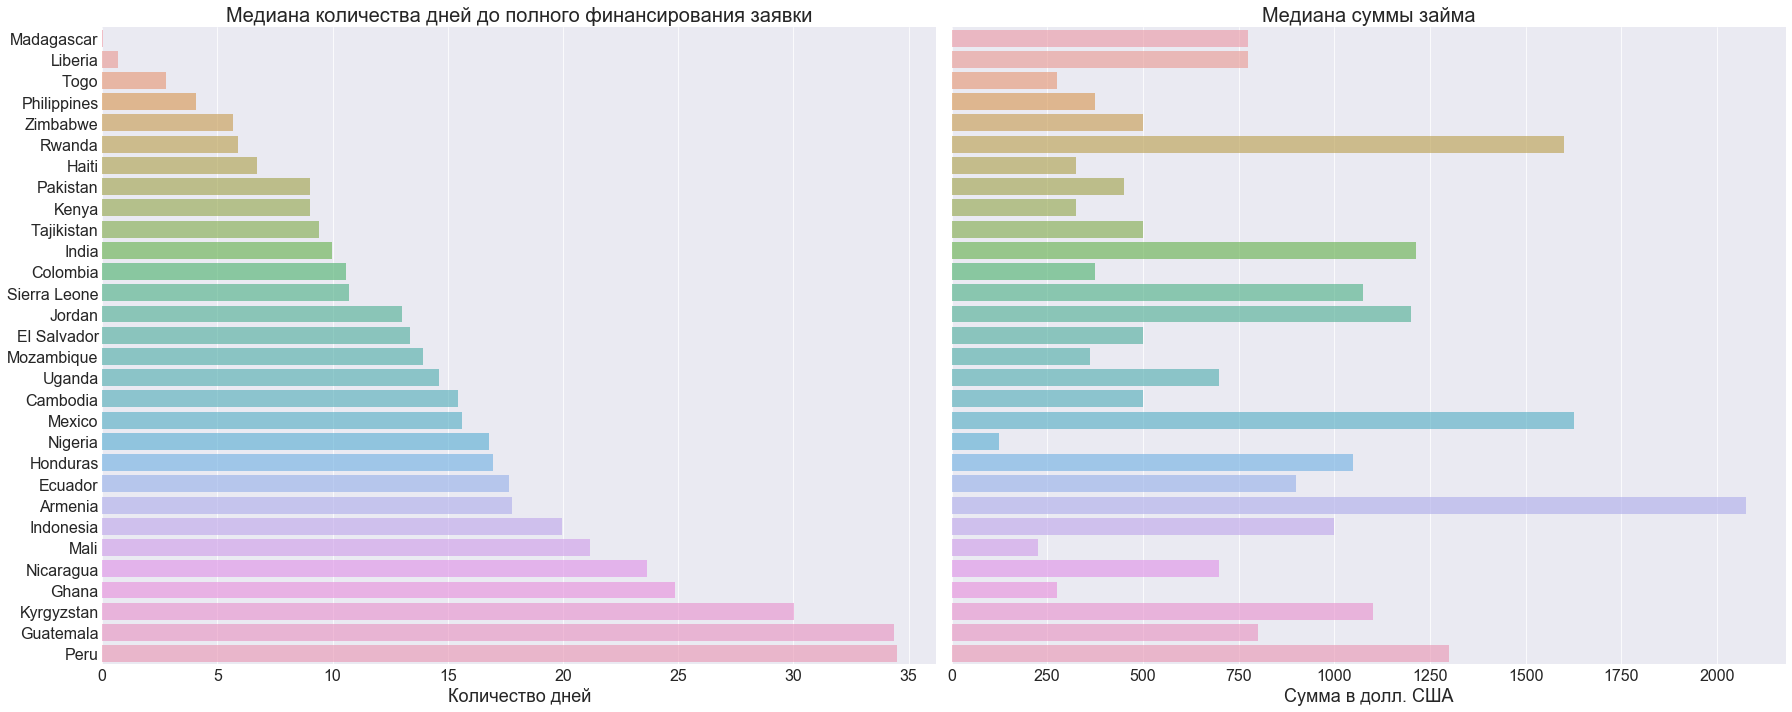

In [ ]:
f,ax=plt.subplots(1, 2, sharey=True, figsize=(25,10))

sns.barplot(y='country', x='time_funding', data=df_country_median, alpha=0.6, ax=ax[0])
ax[0].set_title("Медиана количества дней до полного финансирования заявки", fontsize=20)
ax[0].set_xlabel('Количество дней', fontsize=18)
ax[0].set_ylabel(None)
ax[0].tick_params(labelsize=16)

sns.barplot(y='country', x='loan_amount', data=df_country_median, alpha=0.6, ax=ax[1])
ax[1].set_title("Медиана суммы займа", fontsize=20)
ax[1].set_xlabel('Сумма в долл. США', fontsize=18)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

Действительно, прямой связи времени ожидания финансирования и суммой займа не наблюдается.

В ряде стран с довольно большой медианной суммой займа наблюдаются короткие интервалы на сбор средств:

- Либерия: **750** USD — **1** день;
- Руанда: **1600** USD — **5** дней;
- Индия: **1250** USD — **10** дней.

И наоборот, в нескольких странах на сбор относительно небольших сумм требуется длительное время:

- Нигерия: **125** USD — **17** дней;
- Мали: **250** USD — **22** дня;
- Гана: **250** USD — **25** дней.

Уверен, что в силах организаторов платформы Kiva и сообщества сглаживать такие явные неравенства.

## 2.6. Сумма кредита и время погашения
***

У нас есть ещё один интересный разрез датасета — это информация о количестве месяцев, необходимых заёмщикам для погашения своих кредитов.

Простое построение среднего/медианного времени погашения по стране может дать некоторую информацию, однако она может ввести в заблуждение.

Действительно, скажем, в стране **А** кредиты погашаются в среднем через **12** месяцев, а в стране **В** — через 15 месяцев. Ориентируясь на это, можно сказать, что людям в стране **B** в среднем нужно больше времени, чтобы погасить свои кредиты, по сравнению с людьми в стране **A**. 

Теперь давайте предположим, что средняя сумма кредитов в стране **A** составляет **500** долларов, тогда как в стране **B** это **800** долларов, тогда это означает, что люди в стране **А** платят **41,66** в месяц, в то время как люди в стране **B** платят **51,33**  в месяц!

Поэтому более важно **соотношение суммы кредита и времени погашения**. Оно даёт представление о том, сколько денег в месяц человек в данной стране может позволить себе тратить на погашение кредитов.

Теперь рассчитаем сумму ежемесячного платежа в разрезе стран:

In [ ]:
df_country_median = df_country_median.sort_values(by='term_in_months')

In [ ]:
df_country_median['monthly_repayment'] = df_country_median['loan_amount'] / df_country_median['term_in_months']

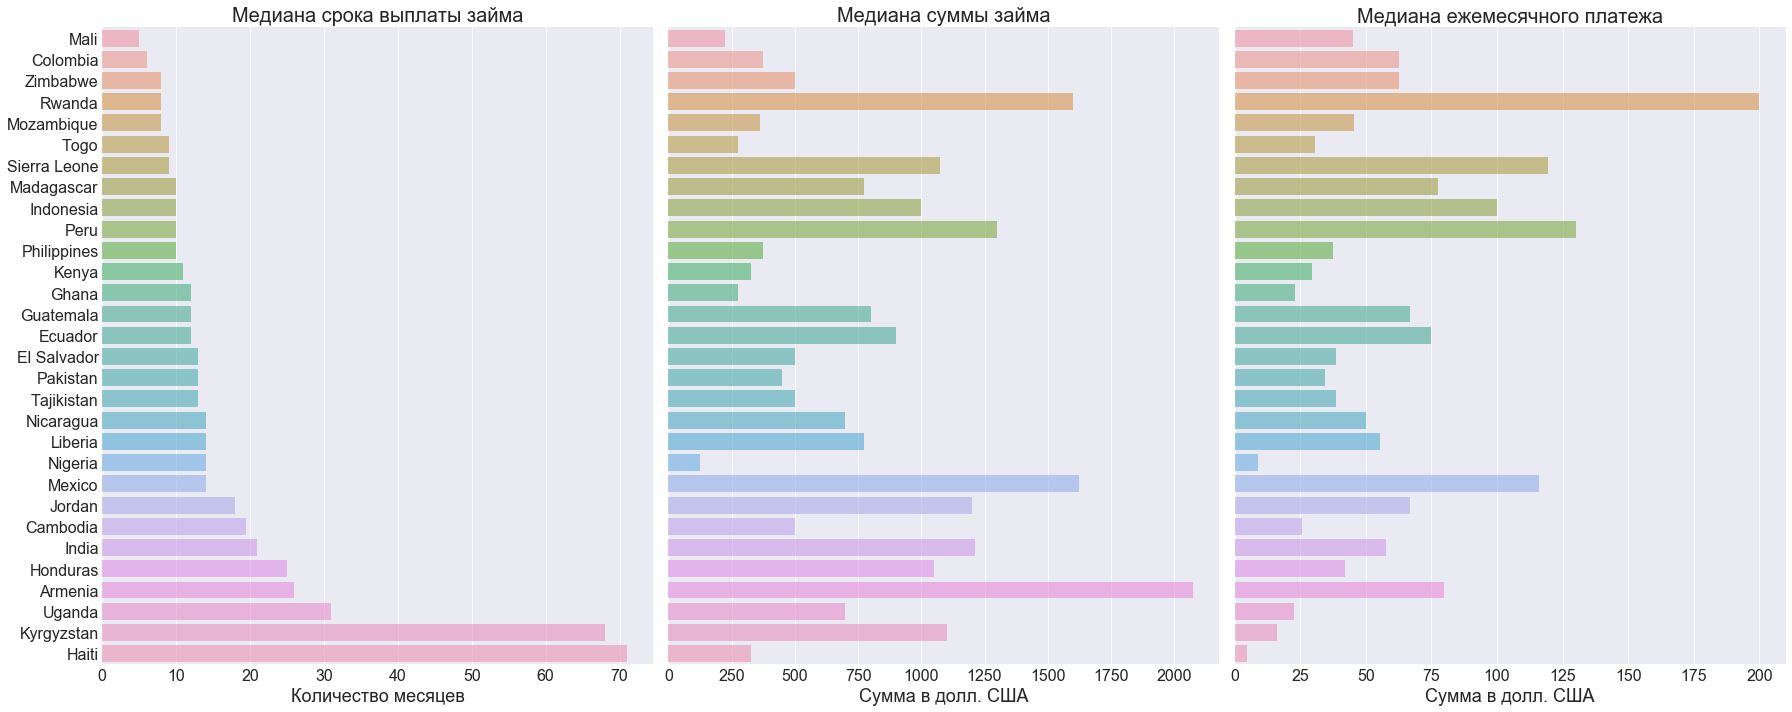

In [ ]:
f,ax=plt.subplots(1, 3, sharey=True, figsize=(25,10))

sns.barplot(y='country', x='term_in_months', data=df_country_median, alpha=0.6, ax=ax[0])
ax[0].set_title("Медиана срока выплаты займа", fontsize=20)
ax[0].set_xlabel('Количество месяцев', fontsize=18)
ax[0].set_ylabel(None)
ax[0].tick_params(labelsize=16)

sns.barplot(y='country', x='loan_amount', data=df_country_median, alpha=0.6, ax=ax[1])
ax[1].set_title("Медиана суммы займа", fontsize=20)
ax[1].set_xlabel('Сумма в долл. США', fontsize=18)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=16)

sns.barplot(y='country', x='monthly_repayment', data=df_country_median, alpha=0.6, ax=ax[2])
ax[2].set_title("Медиана ежемесячного платежа", fontsize=20)
ax[2].set_xlabel('Сумма в долл. США', fontsize=18)
ax[2].set_ylabel(None)
ax[2].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

Перед нами наглядное представление о рейтинге беднейших стран, люди из которых пользуются платформой Kiva. Это страны, в которых люди могут позволить себе выплачивать суммы значительно меньшие, чем в других странах, — а значит, и уровень бедности там выше.

- Гаити;
- Нигерия;
- Киргизия;
- Уганда;
- Гана.

Как никогда стоит обратить внимание сообщества Kiva и направить усилия на поддержку самых нуждающихся!

Расширьте наш отчёт исследованием следующих вопросов:

- Зависимость пола заёмщика от региона планеты

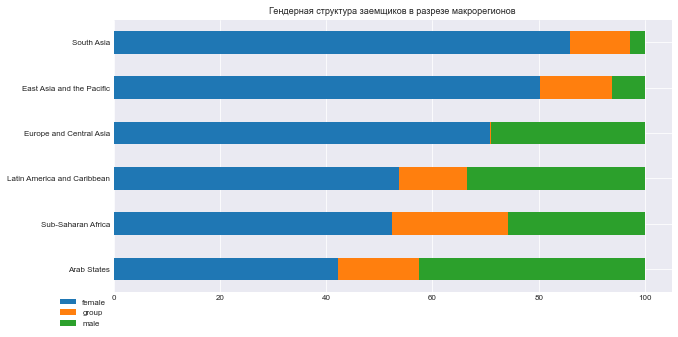

In [87]:
df_gender_by_region = \
df_kiva_loans[df_kiva_loans['world_region'].isin(regions.index.values)]\
.groupby(['world_region', 'borrower_genders'])['borrower_genders']\
.count()\
.groupby(level=0).apply(lambda x: 100 * x / x.sum())\
.unstack('borrower_genders')\
.fillna(0)\
.sort_values(by=['female', 'male'])[-20:]
df_gender_by_country = df_gender_by_country[['female', 'male', 'group']]

plot = df_gender_by_region.plot.barh(
figsize=(10,5)
, fontsize=8
, stacked=True
, title='Гендерная структура заемщиков в разрезе макрорегионов')
plot.title.set_size(9)
plot.legend(loc=1, bbox_to_anchor=(0, 0), fontsize=8)
plot.set(ylabel=None, xlabel=None)
plt.show()

Следует повториться и сказать, что в азиатских странах преобладают заявки от женской части населения

- Зависимость пола заёмщика от сектора экономики.

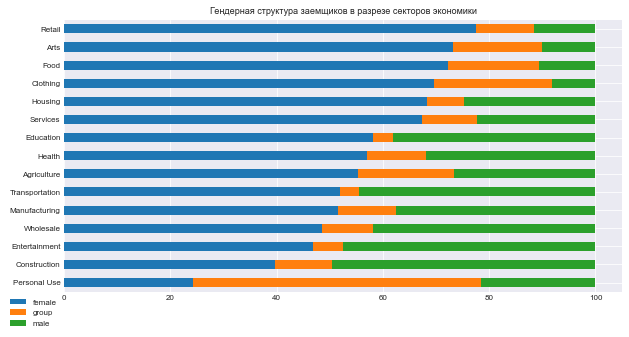

In [88]:
df_gender_by_sector = \
df_kiva_loans.groupby(['sector', 'borrower_genders'])['borrower_genders']\
.count()\
.groupby(level=0).apply(lambda x: 100 * x / x.sum())\
.unstack('borrower_genders')\
.fillna(0)\
.sort_values(by=['female', 'male'])[-20:]
df_gender_by_country = df_gender_by_country[['female', 'male', 'group']]

plot = df_gender_by_sector.plot.barh(
figsize=(10,5)
, fontsize=8
, stacked=True
, title='Гендерная структура заемщиков в разрезе секторов экономики')
plot.title.set_size(9)
plot.legend(loc=1, bbox_to_anchor=(0, 0), fontsize=8)
plot.set(ylabel=None, xlabel=None)
plt.show()

По графику видно сильное преобладание заявок от именно женщин. Особенно этим отличились такие сфера как **розничная торговля,
искусство, пищевая промышленность, производство одежды, ведение домашнего хоз-ва, сфера услуг, образование,
здравохранение и селськое хоз-во**.
Повышение доли заявок от мужчин замечено в **оптовой торговле, сфере развлечений и строительстве**.
Зависимость пола от сектора экономики почти не прослеживается

- Влияние такого атрибута займа, как **Количество кредиторов** (lender_count), на суммы и сроки займов.  
Рассмотрим распределение количество участников финансирования одной заявки.

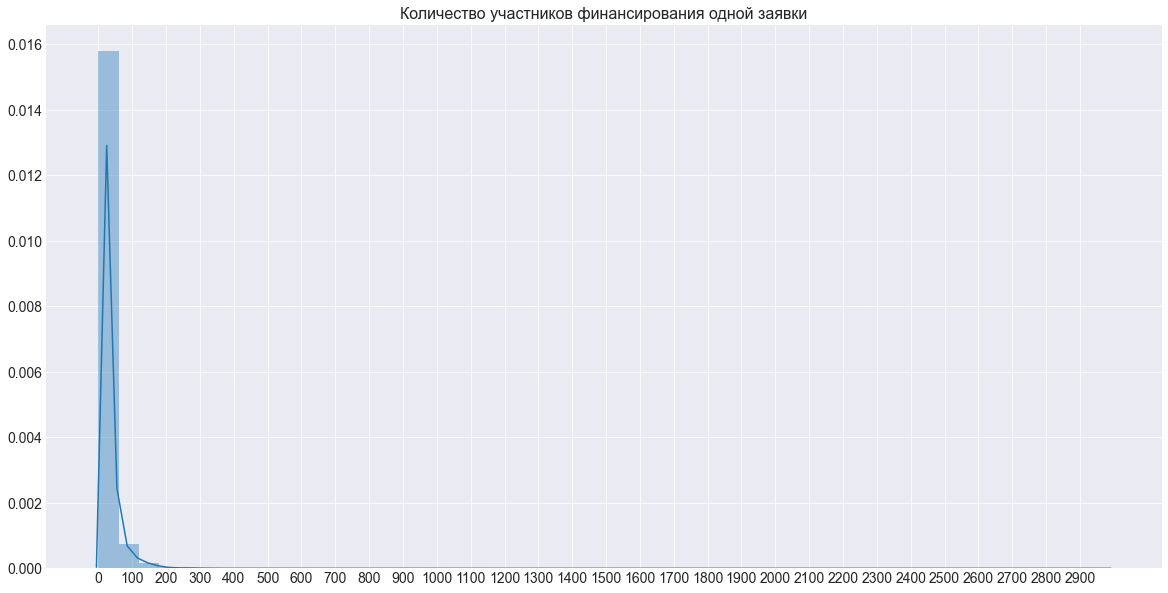

In [89]:
plt.figure(figsize=(20,10))
plt.title("Количество участников финансирования одной заявки", fontsize=16)
plt.xticks(np.arange(0, max(df_kiva_loans['lender_count']+1), 100))
plt.tick_params(labelsize=14)
sns.distplot(df_kiva_loans['lender_count']).set(ylabel=None, xlabel=None)
plt.show()

На лицо явные выбросы. Избавимся от них

In [90]:
dev = (df_kiva_loans['lender_count'] - df_kiva_loans['lender_count'].mean()).abs()
std = df_kiva_loans['lender_count'].std()
df_kiva_loans_trimmed_by_lender_count = df_kiva_loans[dev<3*std]

Повторим визуализацию

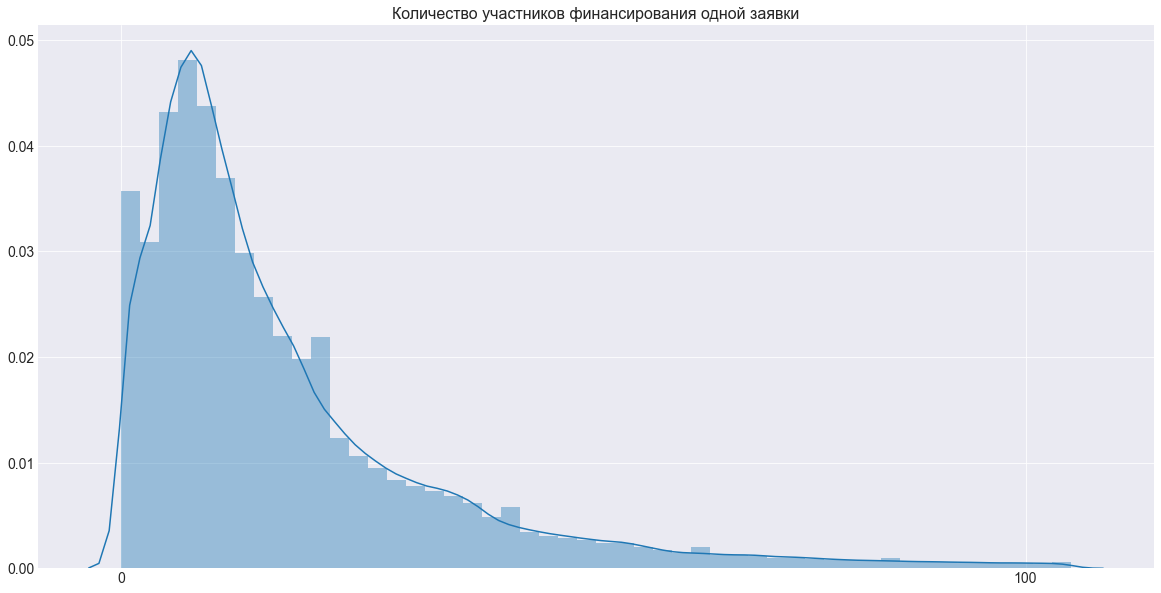

In [91]:
plt.figure(figsize=(20,10))
plt.title("Количество участников финансирования одной заявки", fontsize=16)
plt.xticks(np.arange(0, max(df_kiva_loans_trimmed_by_lender_count['lender_count']+1), 100))
plt.tick_params(labelsize=14)
sns.distplot(df_kiva_loans_trimmed_by_lender_count['lender_count']).set(ylabel=None, xlabel=None)
plt.show()

Продолжим исследование. Есть смысл разбить участников на группы по кол-ву людей в них.

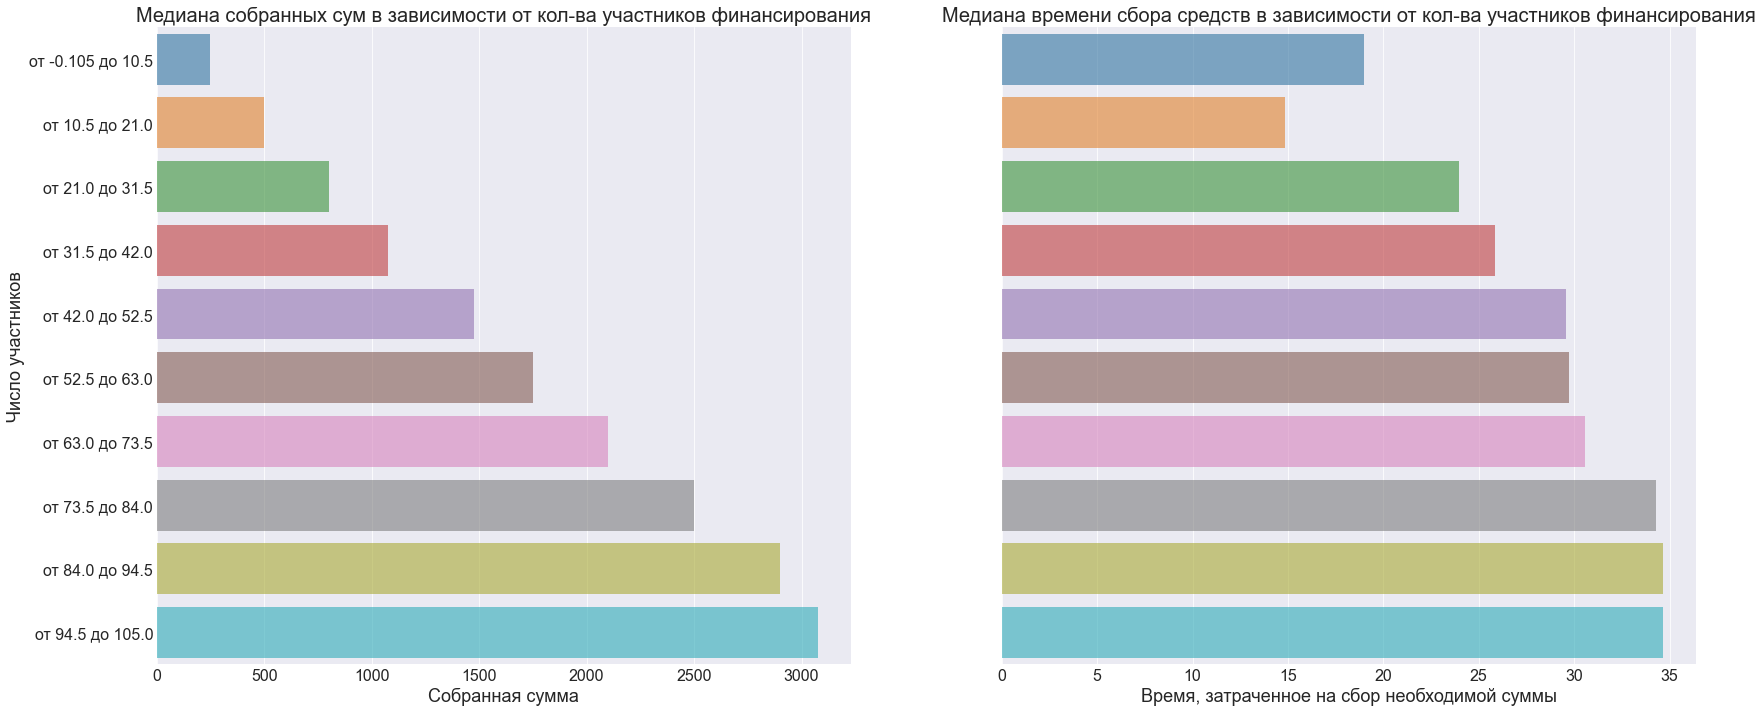

In [92]:
min_lender_count = df_kiva_loans_trimmed_by_lender_count['lender_count'].min()
max_lender_count = df_kiva_loans_trimmed_by_lender_count['lender_count'].max()

df_kiva_loans_trimmed_by_lender_count['lender_count_interval'] =\
pd.cut(df_kiva_loans_trimmed_by_lender_count['lender_count'], int((max_lender_count - min_lender_count)/10))
df_kiva_loans_trimmed_by_lender_count['lender_count_interval'] =\
df_kiva_loans_trimmed_by_lender_count['lender_count_interval'].apply(lambda x: f'от {x.left} до {x.right}')

df_group_by_interval_loan_amount =\
df_kiva_loans_trimmed_by_lender_count.groupby('lender_count_interval')['loan_amount'].median().reset_index()
f,ax=plt.subplots(1, 2, sharey=True, figsize=(25,10))
sns.barplot(y='lender_count_interval', x='loan_amount', data=df_group_by_interval_loan_amount, alpha=0.6, ax=ax[0])
ax[0].set_title("Медиана собранных сум в зависимости от кол-ва участников финансирования", fontsize=20)
ax[0].set_xlabel('Собранная сумма', fontsize=18)
ax[0].set_ylabel('Число участников', fontsize=18)
ax[0].tick_params(labelsize=16)

df_kiva_loans_trimmed_by_lender_count =\
pd.merge(df_kiva_loans_trimmed_by_lender_count, df_loans_dates[['id', 'time_funding']], on='id')
df_kiva_loans_trimmed_by_lender_count =\
df_kiva_loans_trimmed_by_lender_count[df_kiva_loans_trimmed_by_lender_count['time_funding']>0]

df_group_by_interval_time_funding =\
df_kiva_loans_trimmed_by_lender_count.groupby('lender_count_interval')['time_funding'].median().reset_index()
sns.barplot(y='lender_count_interval', x='time_funding', data=df_group_by_interval_time_funding, alpha=0.6, ax=ax[1])
ax[1].set_title("Медиана времени сбора средств в зависимости от кол-ва участников финансирования", fontsize=20)
ax[1].set_xlabel('Время, затраченное на сбор необходимой суммы', fontsize=18)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=16)
plt.tight_layout()
plt.show()

На лицо явная зависимость между тремя характеристиками. Вычислим коэффициент корреляции Пирсона между собранными суммами
и временем сбора средств.

In [93]:
print(df_group_by_interval_loan_amount['loan_amount'].corr(df_group_by_interval_time_funding['time_funding']))

0.9318011411911382


Значение коэффициента Пирсона 0.9318 означает сильную зависимость между собранными суммами
и временем сбора средств

- Влияние показателя MPI (многомерный индекс бедности) в разных странах на суммы займов (loan_amount) и сроки погашения (term_in_months).

Вычислим ежемесячный платеж (monthly_payment) по кредиту для каждого объекта

In [94]:
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts(normalize=True)> 0.005]
list_countries = list(countries.index)

df_kiva_MPI = df_kiva_loans[df_kiva_loans['country'].isin(list_countries)]
df_kiva_MPI = df_kiva_MPI[df_kiva_MPI['MPI'] > 0]\
.dropna(subset=['MPI', 'loan_amount', 'term_in_months'])
df_kiva_MPI['monthly_payment'] = df_kiva_MPI['loan_amount'] / df_kiva_MPI['term_in_months']

Сгруппируем данные по странам и выведем для них медиану ежемесячного платежа и индекса MPI. Сразу отсоритруем страны по индексу MPI.

In [95]:
df_kiva_MPI = df_kiva_MPI\
.groupby('country')['world_region', 'MPI', 'loan_amount', 'term_in_months', 'monthly_payment']\
.median()\
.sort_values('MPI')\
.reset_index()

Отразим все это на графике

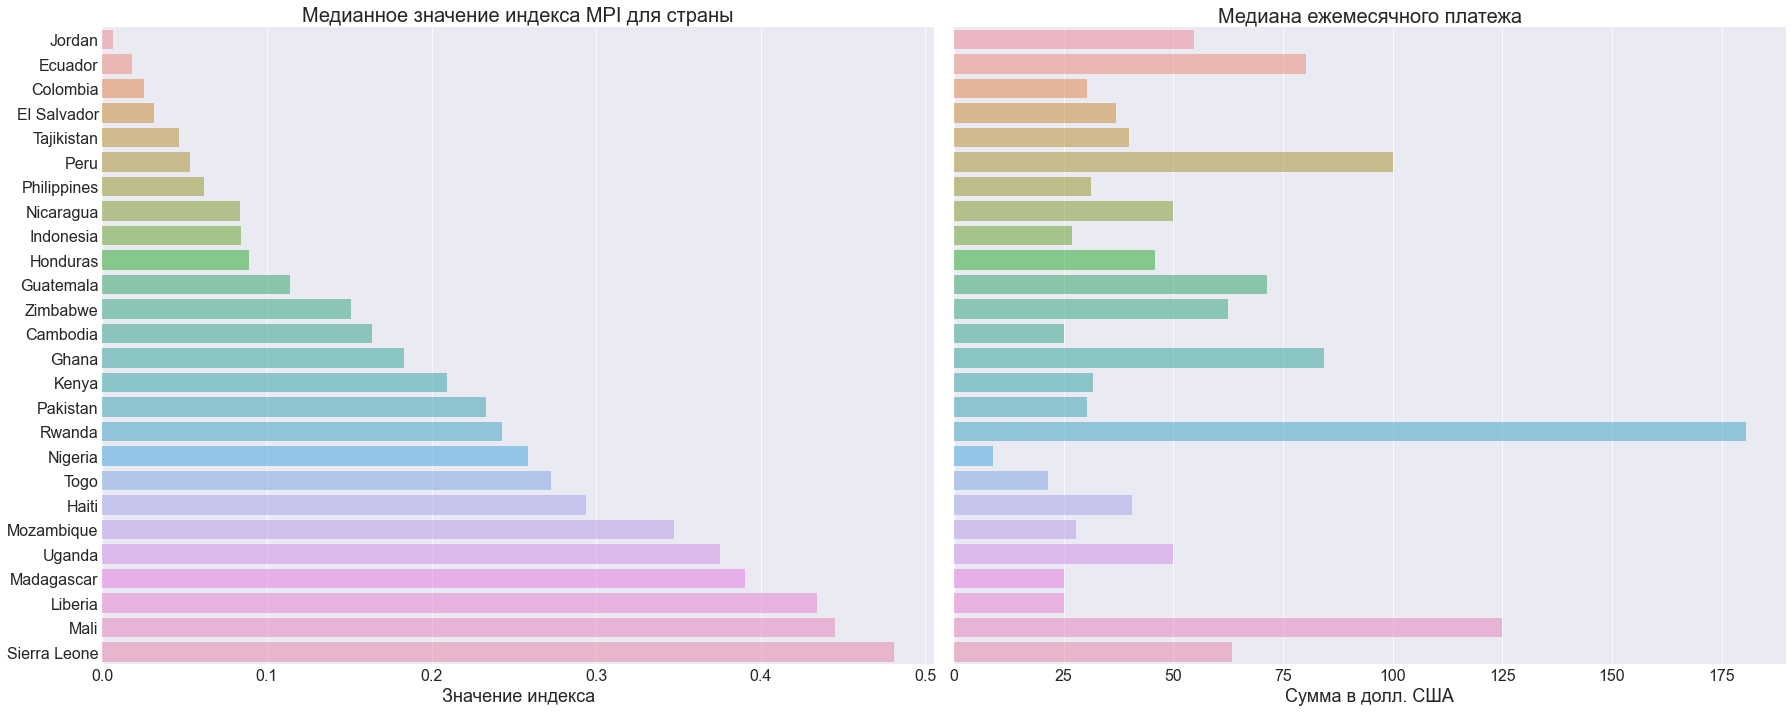

In [96]:
f,ax=plt.subplots(1, 2, sharey=True, figsize=(25,10))

sns.barplot(y='country', x='MPI', data=df_kiva_MPI, alpha=0.6, ax=ax[0])
ax[0].set_title("Медианное значение индекса MPI для страны", fontsize=20)
ax[0].set_xlabel('Значение индекса', fontsize=18)
ax[0].set_ylabel(None)
ax[0].tick_params(labelsize=16)

sns.barplot(y='country', x='monthly_payment', data=df_kiva_MPI, alpha=0.6, ax=ax[1])
ax[1].set_title("Медиана ежемесячного платежа", fontsize=20)
ax[1].set_xlabel('Сумма в долл. США', fontsize=18)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=16)
plt.tight_layout()
plt.show()

На лицо нет явной зависимости между индексом и ежемесячным платежом. Посчитаем коэффициент Пирсона, чтобы убедиться в этом.

In [97]:
print('Коэффициент корреляции Пирсона -', df_kiva_MPI['MPI'].corr(df_kiva_MPI['monthly_payment']))

Коэффициент корреляции Пирсона - 0.03562169073069823


И правда зависимости нет, от слова, никакой. Хотя ожидаемо она будет обратной. Это может быть объяснимо тем,
что плафторма Kiva решает разные задачи в разных странах - где-то она решает задачи долгосрочного кредитования,
где-то краткосрочного. Давайте взглянем в каких странах какой вид кредитования распространен и на какую сумму.

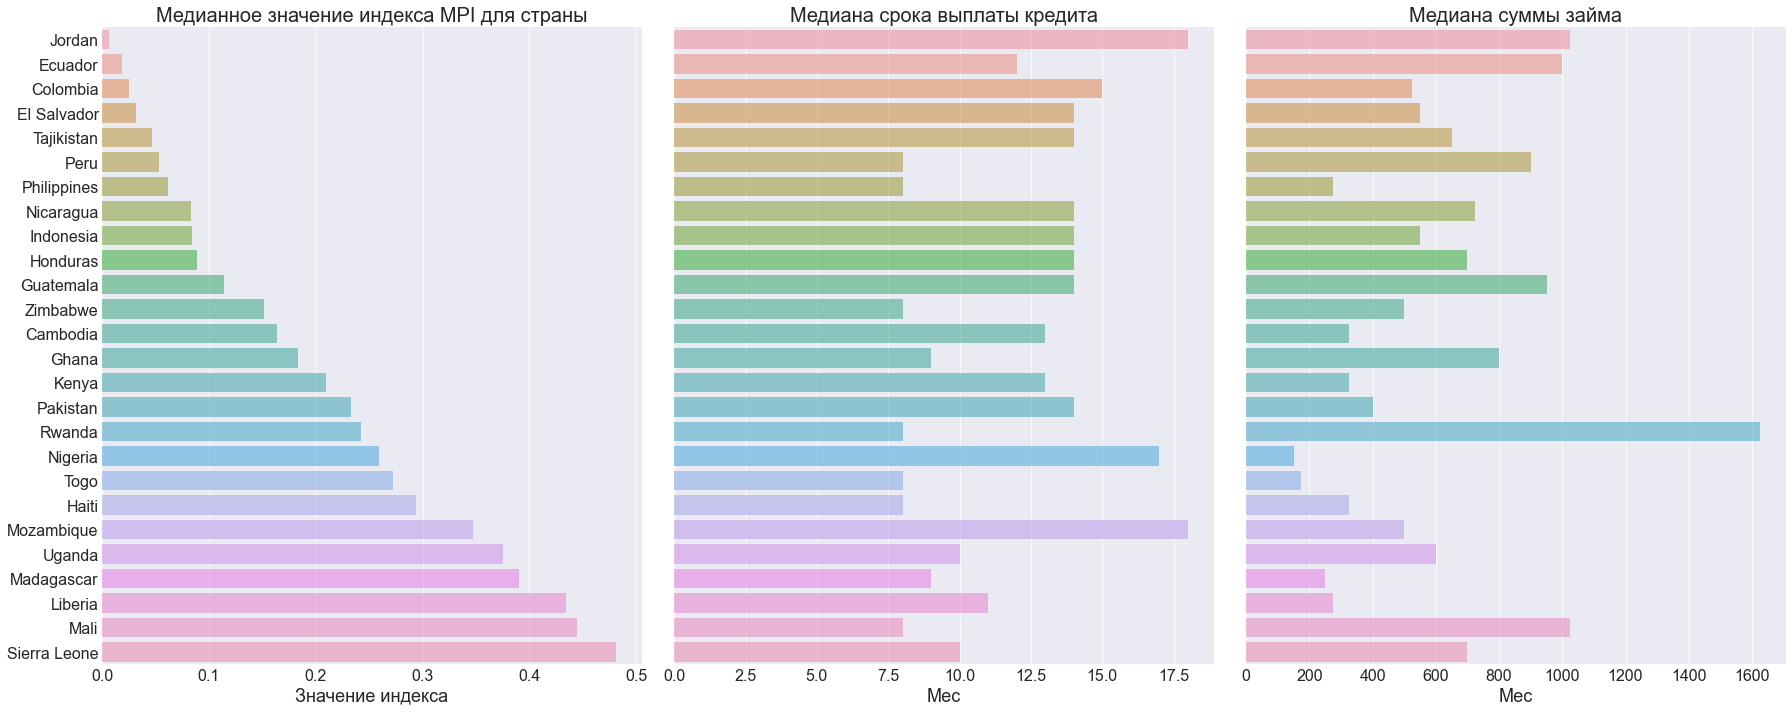

In [98]:
f,ax=plt.subplots(1, 3, sharey=True, figsize=(25,10))

sns.barplot(y='country', x='MPI', data=df_kiva_MPI, alpha=0.6, ax=ax[0])
ax[0].set_title("Медианное значение индекса MPI для страны", fontsize=20)
ax[0].set_xlabel('Значение индекса', fontsize=18)
ax[0].set_ylabel(None)
ax[0].tick_params(labelsize=16)

sns.barplot(y='country', x='term_in_months', data=df_kiva_MPI, alpha=0.6, ax=ax[1])
ax[1].set_title("Медиана срока выплаты кредита", fontsize=20)
ax[1].set_xlabel('Мес', fontsize=18)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=16)

sns.barplot(y='country', x='loan_amount', data=df_kiva_MPI, alpha=0.6, ax=ax[2])
ax[2].set_title("Медиана суммы займа", fontsize=20)
ax[2].set_xlabel('Мес', fontsize=18)
ax[2].set_ylabel(None)
ax[2].tick_params(labelsize=16)
plt.tight_layout()
plt.show()

Кажется нет никакой зависимости и между этими тремя показателями.

- Взаимозависимости таких метрик, как «Сумма займа» (loan_amount), «Срок займа» (term_in_months), «Время финансирования заявки» (funded_time), «Ежемесячный платёж» (monthly_payment) в разрезе макрорегионов.

In [100]:
df_loans_corr = df_loans_dates_trimmed.copy()
df_loans_corr = df_loans_corr.dropna(subset=['world_region', 'country', 'loan_amount', 'term_in_months', 'time_funding'])

Вычислим ежемесячный платёж

In [101]:
df_loans_corr['monthly_payment'] = df_loans_corr['loan_amount'] / df_loans_corr['term_in_months']

df_loans_corr = df_loans_corr[['world_region', 'loan_amount', 'term_in_months', 'time_funding', 'monthly_payment']]

Сгруппируем датасет по макрорегионам и сформируем из сгруппированных данных списки

In [103]:
df_loans_corr = df_loans_corr\
.groupby('world_region')[['loan_amount', 'term_in_months', 'time_funding', 'monthly_payment']]\
.agg({'loan_amount' : list, 'term_in_months' : list, 'time_funding' : list, 'monthly_payment': list})

for i in df_loans_corr.columns:
    for j in df_loans_corr.columns:
        name = f'corrcoef between {i} and {j}'
        if i == j:
            break
        df_loans_corr[name] = df_loans_corr\
        .apply(lambda x: np.corrcoef(x[i], x[j])[0][1], axis=1)

Попутно рассчитаем коэффициент корреляциии для каждой пары.

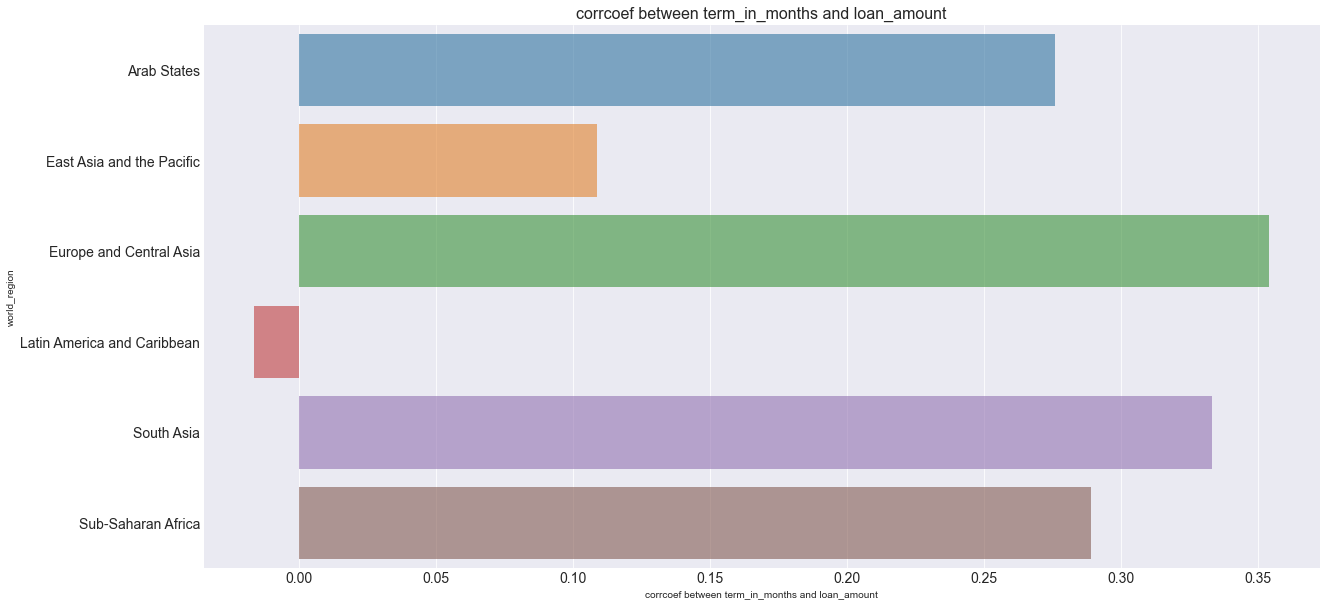

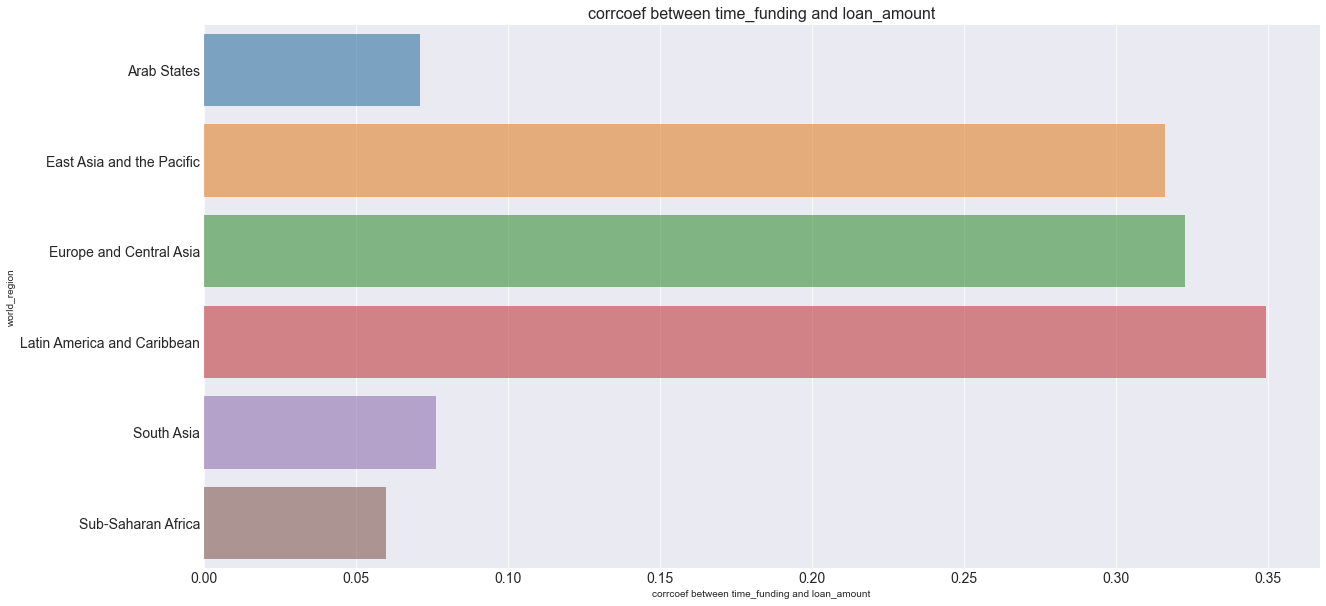

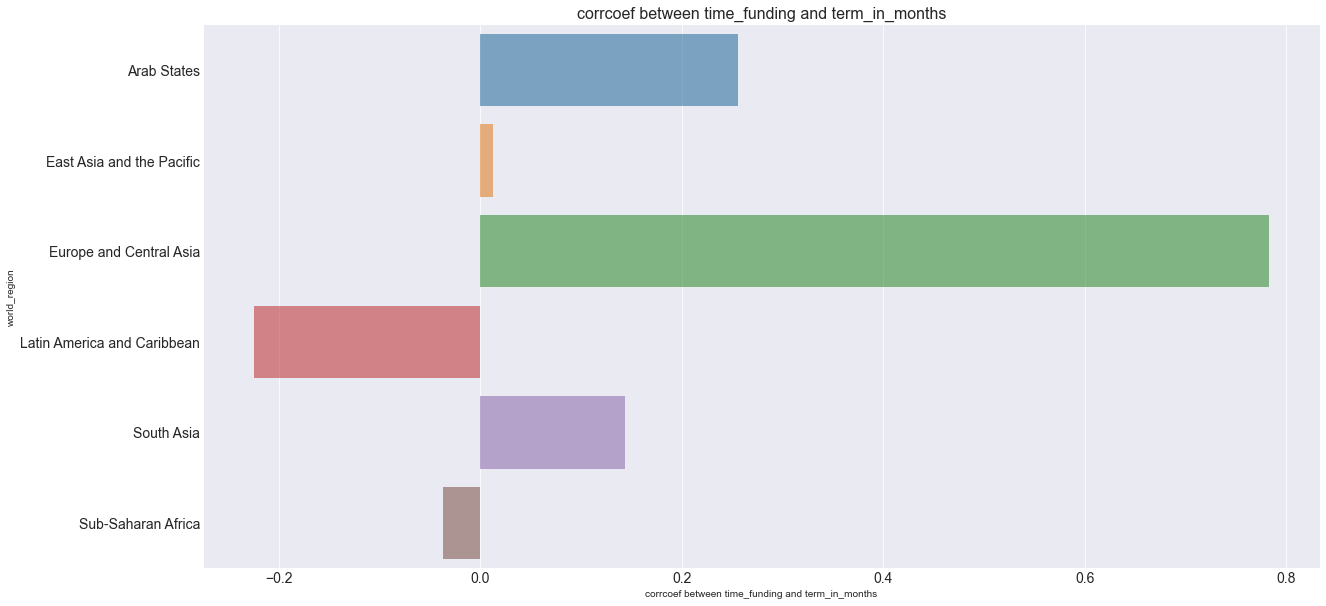

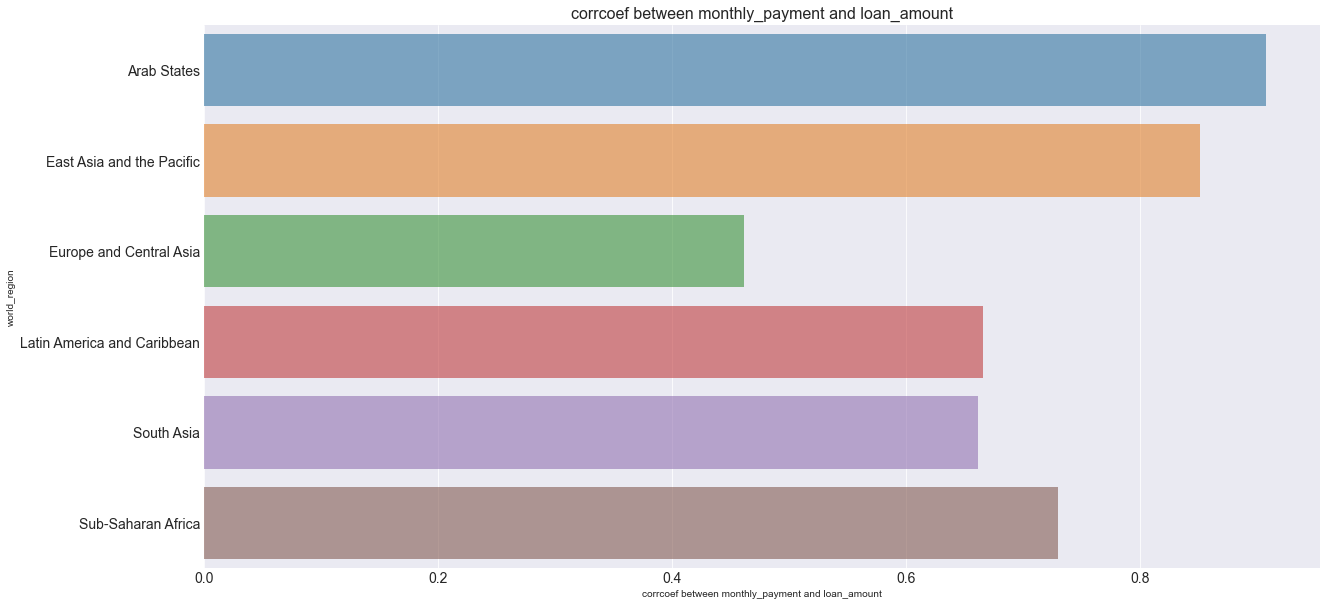

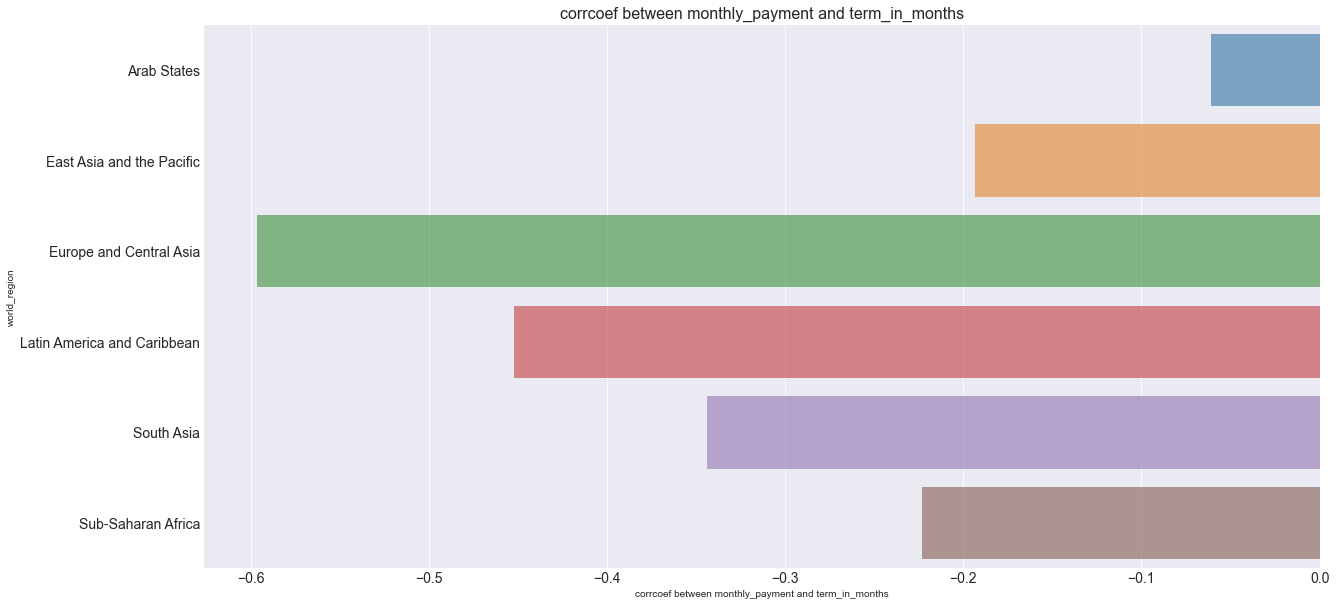

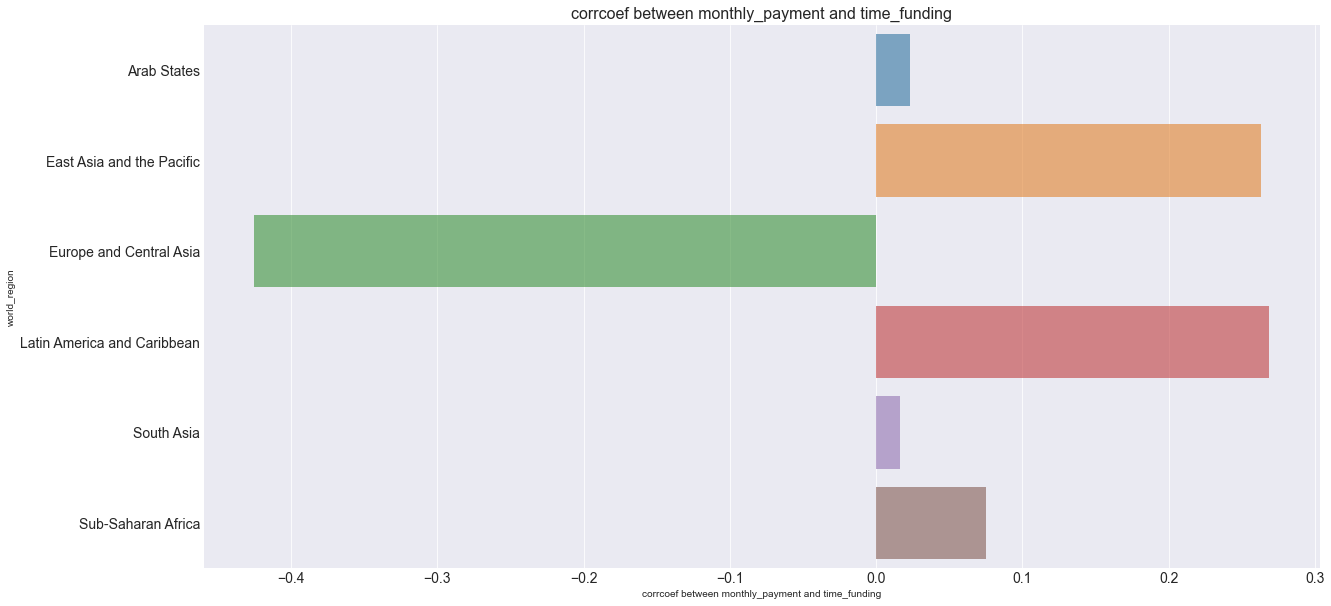

In [104]:
for column in df_loans_corr.columns[4:]:
    plt.figure(figsize=(20,10))
    plt.title(column, fontsize=16)
    plt.tick_params(labelsize=14)
    sns.barplot(y=df_loans_corr.index, x=df_loans_corr[column], alpha=0.6)
    plt.show()

Итак, по порядку:
- зависимость срока погашения от суммы займы нет, ни в одном регионе,
- зависимость времени сбора средств от суммы займа также нет,
- есть высокая зависимость времени сбора средств от срока погашения в Центральной Азии,
- имеется четкая зависимость между ежемесячным платежом и суммой займа почти во всех регионах кроме Центральной Азии,
- и конечно же заметная обратная зависимость наблюдается между емесячным платежом и сроком погашения,
- а вот зависимости между ежемесячным платежом и временем сбора средств нет почти нигде, кроме Центральной Азии, там наблюдается еле заметная обратная корреляция.

#### 2.4.2. Датасет Airbnb

#### Явное задание цветов в matplotlib

In [ ]:
colors = matplotlib.colors.get_named_colors_mapping()

In [ ]:
list(colors.keys())[:5]

['xkcd:cloudy blue',
 'xkcd:dark pastel green',
 'xkcd:dust',
 'xkcd:electric lime',
 'xkcd:fresh green']

In [ ]:
list(colors.values())[:5]

['#acc2d9', '#56ae57', '#b2996e', '#a8ff04', '#69d84f']

In [ ]:
color_map = {
    'Brooklyn': colors['xkcd:cloudy blue'],
    'Manhattan': colors['xkcd:azul'], 
    'Queens': colors['xkcd:electric lime'], 
    'Staten Island': colors['xkcd:fresh green'], 
    'Bronx': colors['xkcd:warm purple']
}

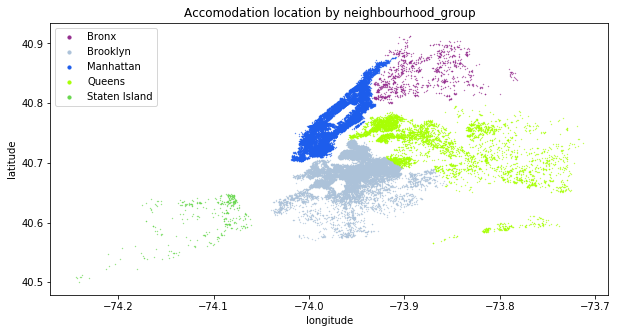

In [ ]:
plt.figure(figsize=(10, 5))
for name, group in data.groupby(['neighbourhood_group']):
    plt.scatter(group['longitude'], group['latitude'], s=0.1, c=color_map[name], label=name)
plt.legend(markerscale=10)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Accomodation location by neighbourhood_group')
plt.show()

### Bar, barh

In [ ]:
room_type_size = data.groupby('room_type').size()

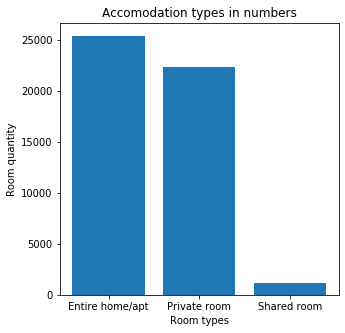

In [ ]:
plt.figure(figsize=(5, 5))
plt.bar(room_type_size.index, room_type_size.values)
plt.xlabel('Room types')
plt.ylabel('Room quantity')
plt.title('Accomodation types in numbers')
plt.show()

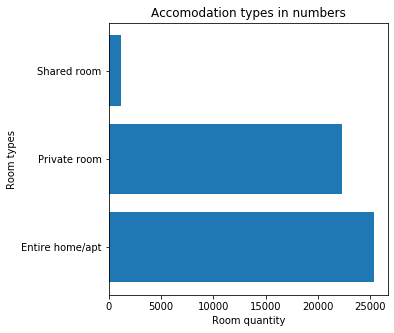

In [ ]:
plt.figure(figsize=(5, 5))
plt.barh(room_type_size.index, room_type_size.values)
plt.xlabel('Room quantity')
plt.ylabel('Room types')
plt.title('Accomodation types in numbers')
plt.show()

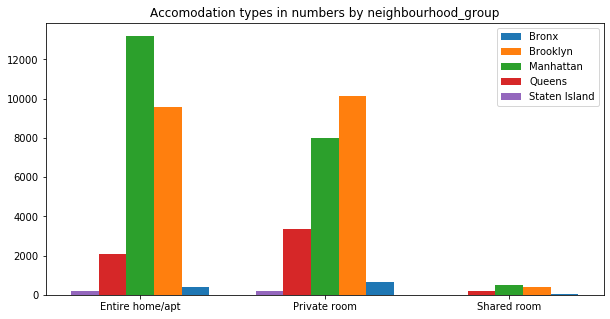

In [ ]:
plt.figure(figsize=(10, 5))
x = np.asarray([0, 1, 2])
width = 0.15
i = -2
for name, group in data.groupby(['neighbourhood_group']):
    plt.bar(x - i*width, group.groupby('room_type').size().values, width, label=name)
    i += 1
plt.title('Accomodation types in numbers by neighbourhood_group')
plt.xticks(x, list(data.groupby('room_type').groups.keys()))
plt.legend()
plt.show()

### Hist

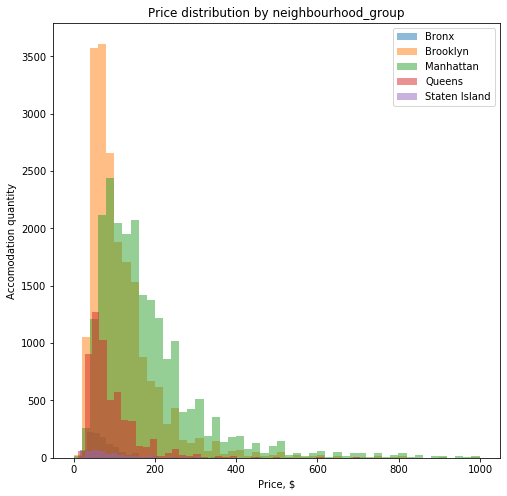

In [ ]:
plt.figure(figsize=(8, 8))
filtered_data = data[data['price'] < 1000]
for name, group in filtered_data.groupby(['neighbourhood_group']):
    plt.hist(group['price'], label=name, bins=50, alpha=0.5)
plt.xlabel('Price, $')
plt.ylabel('Accomodation quantity')
plt.title('Price distribution by neighbourhood_group')
plt.legend()
plt.show()

### Pie

In [ ]:
neighbourhood_group_size = data.groupby(['neighbourhood_group']).size()

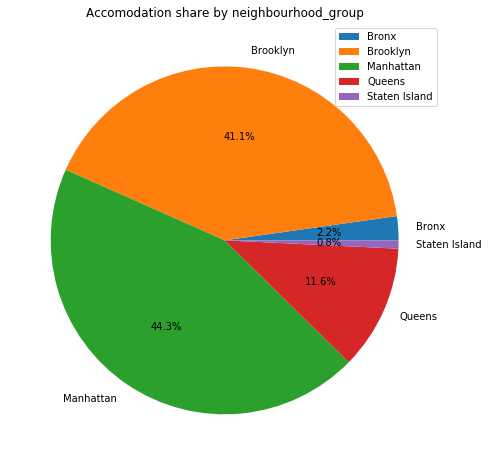

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(neighbourhood_group_size.values, labels=neighbourhood_group_size.index, autopct='%1.1f%%')
plt.legend()
plt.title('Accomodation share by neighbourhood_group')
plt.show()

### Boxplot

  ![title](https://248006.selcdn.ru/public/email/courses/Профессия%20Data%20Scientist/boxplot.png)

In [ ]:
filtered_data = data[data['price'] < 1000]

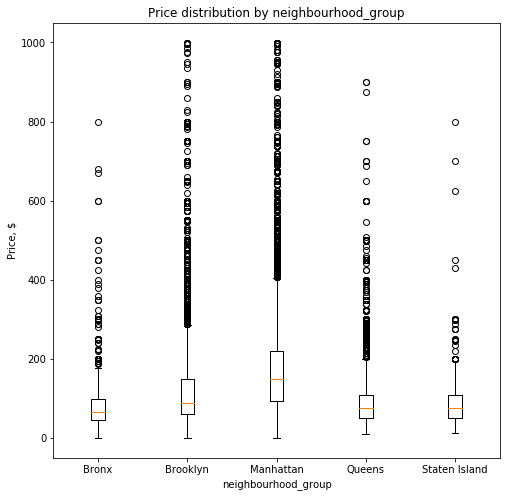

In [ ]:
plt.figure(figsize=(8, 8))
index = 1
for name, group in filtered_data.groupby(['neighbourhood_group']):
    plt.boxplot(group['price'], positions=[index], labels=[name])
    index += 1
plt.xlabel('neighbourhood_group')
plt.ylabel('Price, $')
plt.title('Price distribution by neighbourhood_group')
plt.show()

#### 2.4.3. Датасет DieTanic

### How many Survived??

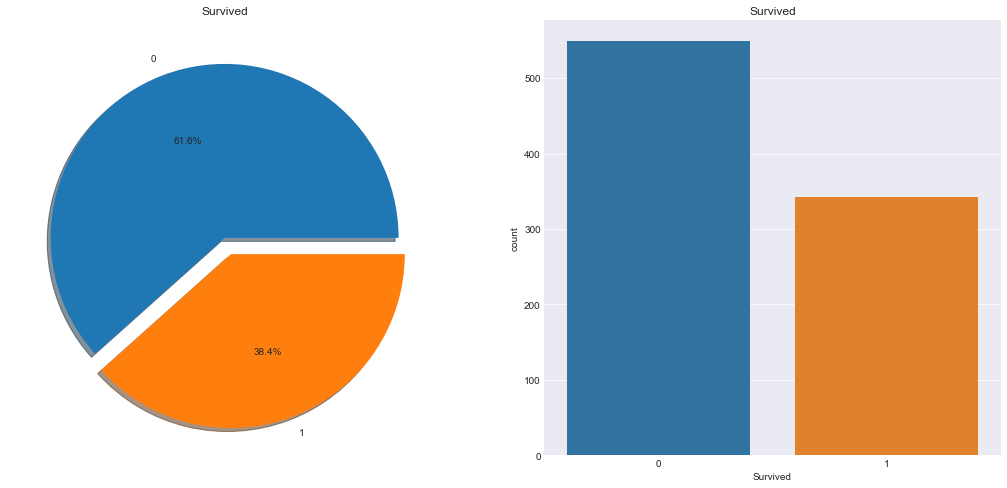

In [134]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=data,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

It is evident that not many passengers survived the accident. 

Out of 891 passengers in training set, only around 350 survived i.e Only **38.4%** of the total training set survived the crash. We need to dig down more to get better insights from the data and see which categories of the passengers did survive and who didn't.

We will try to check the survival rate by using the different features of the dataset. Some of the features being Sex, Port Of Embarcation, Age,etc.

First let us understand the different types of features.

## Types Of Features

### Categorical Features:
A categorical variable is one that has two or more categories and each value in that feature can be categorised by them.For example, gender is a categorical variable having two categories (male and female). Now we cannot sort or give any ordering to such variables. They are also known as **Nominal Variables**.

**Categorical Features in the dataset: Sex,Embarked.**

### Ordinal Features:
An ordinal variable is similar to categorical values, but the difference between them is that we can have relative ordering or sorting between the values. For eg: If we have a feature like **Height** with values **Tall, Medium, Short**, then Height is a ordinal variable. Here we can have a relative sort in the variable.

**Ordinal Features in the dataset: PClass**

### Continous Feature:
A feature is said to be continous if it can take values between any two points or between the minimum or maximum values in the features column.

**Continous Features in the dataset: Age**

## Analysing The Features

## Sex--> Categorical Feature

In [135]:
data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

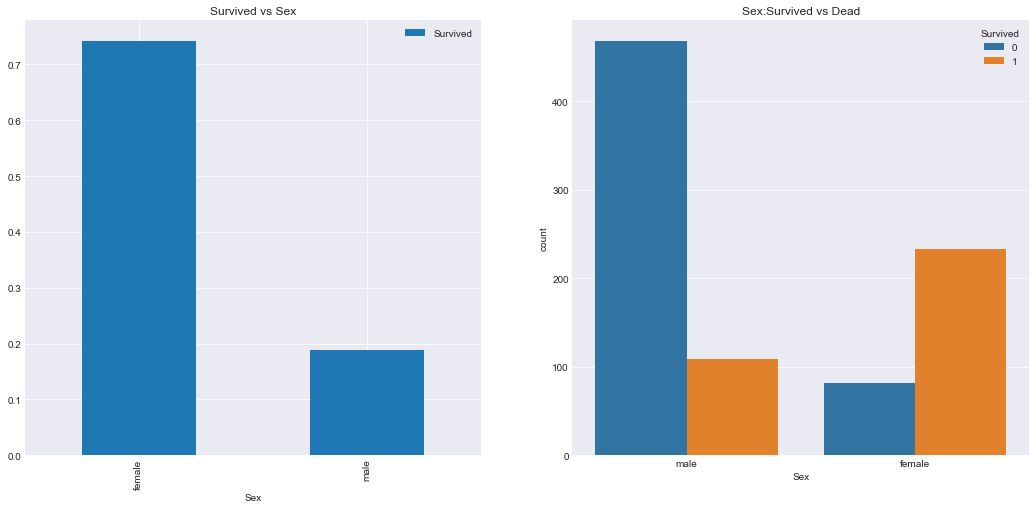

In [136]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

This looks interesting. The number of men on the ship is lot more than the number of women. Still the number of women saved is almost twice the number of males saved. The survival rates for a **women on the ship is around 75% while that for men in around 18-19%.**

This looks to be a **very important** feature for modeling. But is it the best??   Lets check other features.

## Pclass --> Ordinal Feature

In [137]:
pd.crosstab(data.Pclass,data.Survived,margins=True).style.background_gradient(cmap='summer_r')

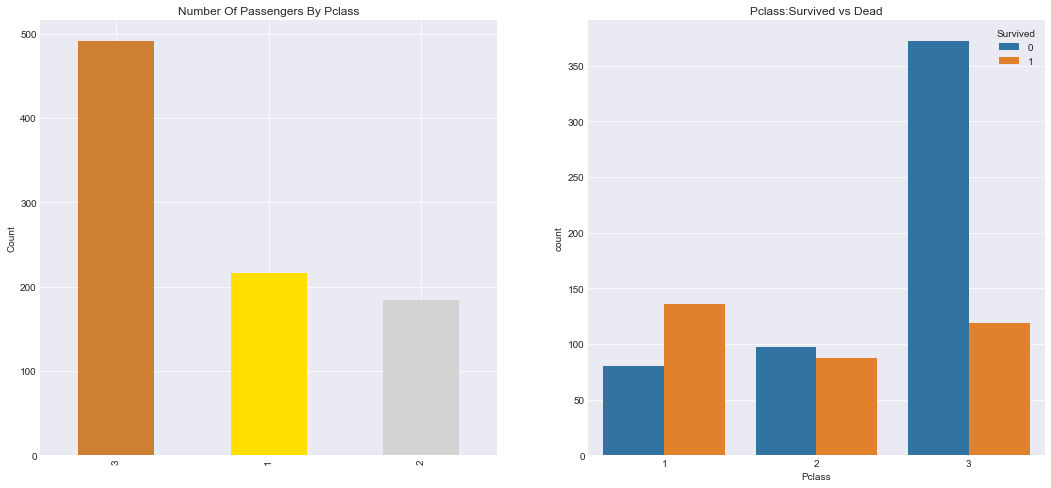

In [138]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

People say **Money Can't Buy Everything**. But we can clearly see that Passenegers Of Pclass 1 were given a very high priority while rescue. Even though the the number of Passengers in Pclass 3 were a lot higher, still the number of survival from them is very low, somewhere around **25%**.

For Pclass 1 %survived is around **63%** while for Pclass2 is around **48%**. So money and status matters. Such a materialistic world.

Lets Dive in little bit more and check for other interesting observations. Lets check survival rate with **Sex and Pclass** Together.

In [139]:
pd.crosstab([data.Sex,data.Survived],data.Pclass,margins=True).style.background_gradient(cmap='summer_r')

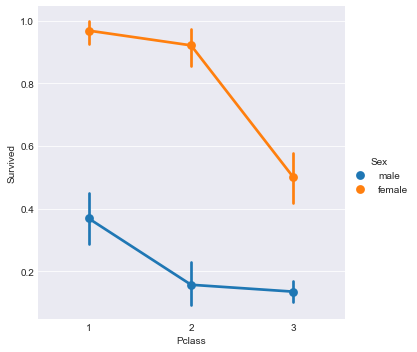

In [140]:
sns.factorplot('Pclass','Survived',hue='Sex',data=data)
plt.show()

We use **FactorPlot** in this case, because they make the seperation of categorical values easy.

Looking at the **CrossTab** and the **FactorPlot**, we can easily infer that survival for **Women from Pclass1** is about **95-96%**, as only 3 out of 94 Women from Pclass1 died. 

It is evident that irrespective of Pclass, Women were given first priority while rescue. Even Men from Pclass1 have a very low survival rate.

Looks like Pclass is also an important feature. Lets analyse other features.

## Age--> Continous Feature


In [141]:
print('Oldest Passenger was of:',data['Age'].max(),'Years')
print('Youngest Passenger was of:',data['Age'].min(),'Years')
print('Average Age on the ship:',data['Age'].mean(),'Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


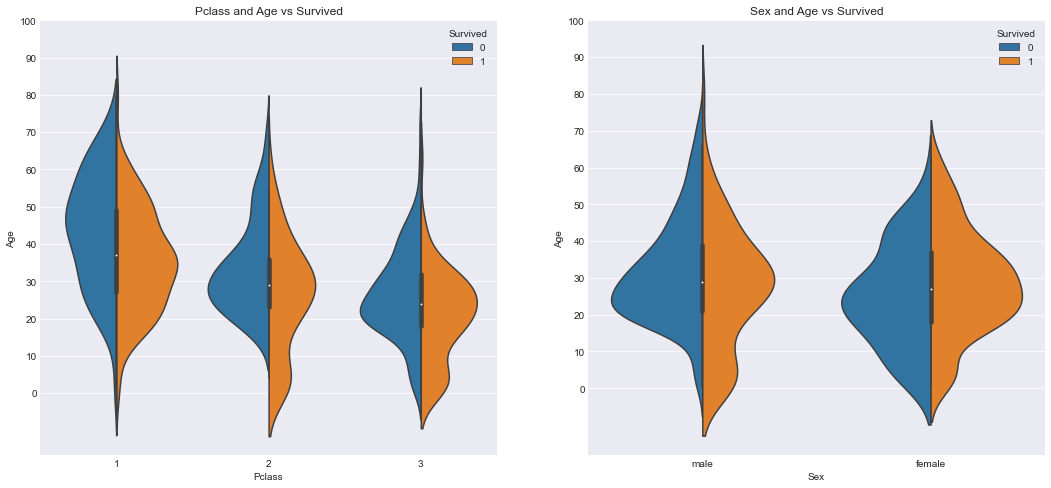

In [142]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

#### Observations:

1)The number of children increases with Pclass and the survival rate for passenegers below Age 10(i.e children) looks to be good irrespective of the Pclass.

2)Survival chances for Passenegers aged 20-50 from Pclass1 is high and is even better for Women.

3)For males, the survival chances decreases with an increase in age.

As we had seen earlier, the Age feature has **177** null values. To replace these NaN values, we can assign them the mean age of the dataset.

But the problem is, there were many people with many different ages. We just cant assign a 4 year kid with the mean age that is 29 years. Is there any way to find out what age-band does the passenger lie??

**Bingo!!!!**, we can check the **Name**  feature. Looking upon the feature, we can see that the names have a salutation like Mr or Mrs. Thus we can assign the mean values of Mr and Mrs to the respective groups.

**''What's In A Name??''**---> **Feature**  :p

In [143]:
data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

Okay so here we are using the Regex: **[A-Za-z]+)\.**. So what it does is, it looks for strings which lie between **A-Z or a-z** and followed by a **.(dot)**. So we successfully extract the Initials from the Name.

In [144]:
pd.crosstab(data.Initial,data.Sex).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Okay so there are some misspelled Initials like Mlle or Mme that stand for Miss. I will replace them with Miss and same thing for other values.

In [145]:
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],\
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [146]:
data.groupby('Initial')['Age'].mean() #lets check the average age by Initials

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

### Filling NaN Ages

In [147]:
## Assigning the NaN Values with the Ceil values of the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

In [148]:
data.Age.isnull().any() #So no null values left finally 

False

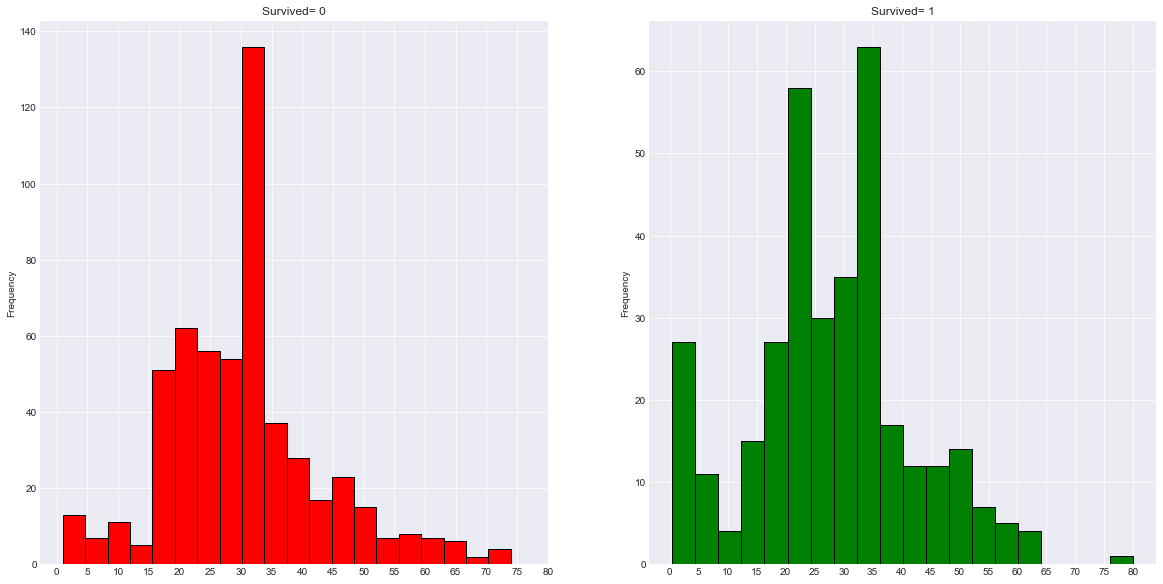

In [149]:
f,ax=plt.subplots(1,2,figsize=(20,10))
data[data['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
data[data['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

### Observations:
1)The Toddlers(age<5) were saved in large numbers(The Women and Child First Policy).

2)The oldest Passenger was saved(80 years).

3)Maximum number of deaths were in the age group of 30-40.

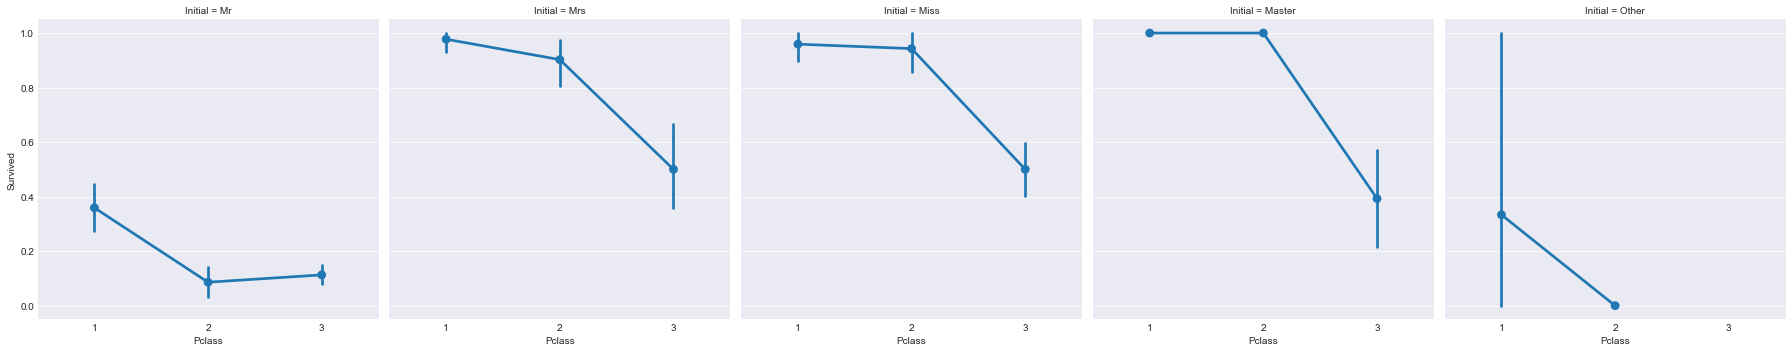

In [150]:
sns.factorplot('Pclass','Survived',col='Initial',data=data)
plt.show()

The Women and Child first policy thus holds true irrespective of the class.

## Embarked--> Categorical Value

In [151]:
pd.crosstab([data.Embarked,data.Pclass],[data.Sex,data.Survived],margins=True)\
.style.background_gradient(cmap='summer_r')

### Chances for Survival by Port Of Embarkation

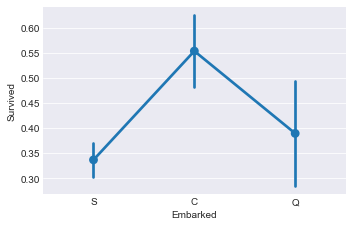

In [152]:
sns.factorplot('Embarked','Survived',data=data)
fig=plt.gcf()
fig.set_size_inches(5,3)
plt.show()

The chances for survival for Port C is highest around 0.55 while it is lowest for S.

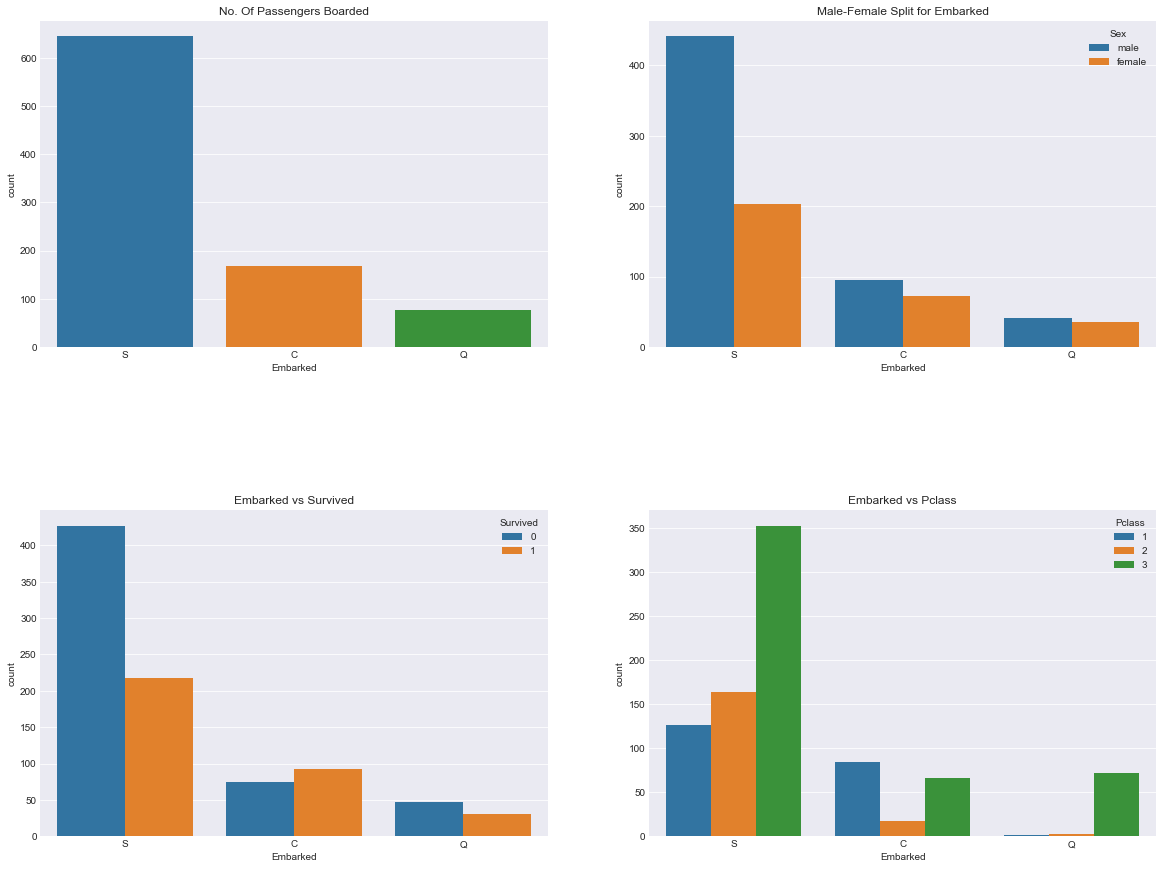

In [153]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=data,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=data,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=data,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=data,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

### Observations:
1)Maximum passenegers boarded from S. Majority of them being from Pclass3.

2)The Passengers from C look to be lucky as a good proportion of them survived. The reason for this maybe the rescue of all the Pclass1 and Pclass2 Passengers.

3)The Embark S looks to the port from where majority of the rich people boarded. Still the chances for survival is low here, that is because many passengers from Pclass3 around **81%** didn't survive. 

4)Port Q had almost 95% of the passengers were from Pclass3.

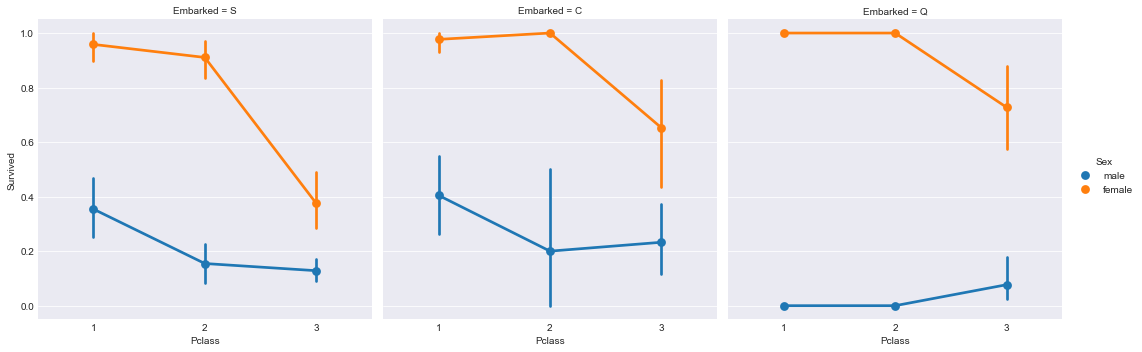

In [154]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data)
plt.show()

### Observations:

1)The survival chances are almost 1 for women for Pclass1 and Pclass2 irrespective of the Pclass.

2)Port S looks to be very unlucky for Pclass3 Passenegers as the survival rate for both men and women is very low.**(Money Matters)**

3)Port Q looks looks to be unlukiest for Men, as almost all were from Pclass 3.


### Filling Embarked NaN

As we saw that maximum passengers boarded from Port S, we replace NaN with S.

In [155]:
data['Embarked'].fillna('S',inplace=True)

In [156]:
data.Embarked.isnull().any()# Finally No NaN values

False

## SibSip-->Discrete Feature
This feature represents whether a person is alone or with his family members.

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife 

In [157]:
pd.crosstab([data.SibSp],data.Survived).style.background_gradient(cmap='summer_r')

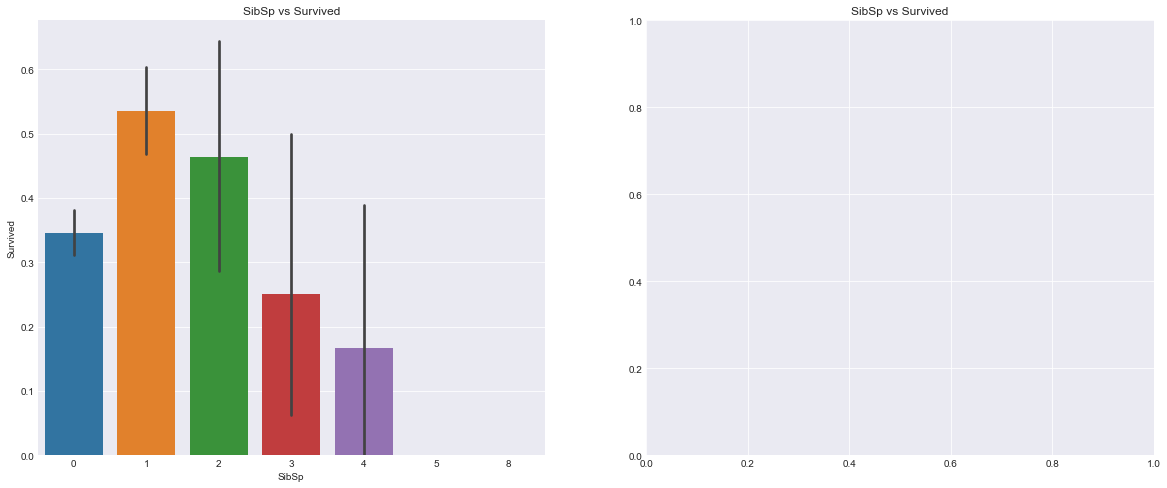

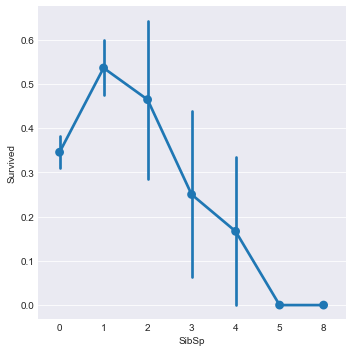

In [158]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=data,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp','Survived',data=data,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
plt.show()

In [159]:
pd.crosstab(data.SibSp,data.Pclass).style.background_gradient(cmap='summer_r')

### Observations:


The barplot and factorplot shows that if a passenger is alone onboard with no siblings, he have 34.5% survival rate. The graph roughly decreases if the number of siblings increase. This makes sense. That is, if I have a family on board, I will try to save them instead of saving myself first. Surprisingly the survival for families with 5-8 members is **0%**. The reason may be Pclass??

The reason is **Pclass**. The crosstab shows that Person with SibSp>3 were all in Pclass3. It is imminent that all the large families in Pclass3(>3) died.

## Fare--> Continous Feature

In [160]:
print('Highest Fare was:',data['Fare'].max())
print('Lowest Fare was:',data['Fare'].min())
print('Average Fare was:',data['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.204207968574636


The lowest fare is **0.0**. Wow!! a free luxorious ride. 

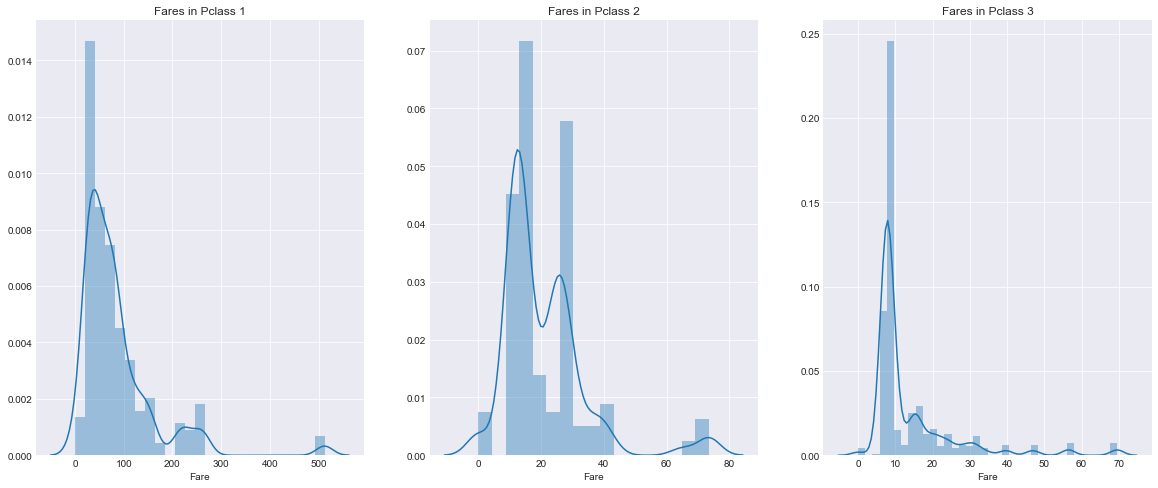

In [161]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

There looks to be a large distribution in the fares of Passengers in Pclass1 and this distribution goes on decreasing as the standards reduces. As this is also continous, we can convert into discrete values by using binning.

## Observations in a Nutshell for all features:
**Sex:** The chance of survival for women is high as compared to men.

**Pclass:**There is a visible trend that being a **1st class passenger** gives you better chances of survival. The survival rate for **Pclass3 is very low**. For **women**, the chance of survival from **Pclass1** is almost 1 and is high too for those from **Pclass2**.   **Money Wins!!!**. 

**Age:** Children less than 5-10 years do have a high chance of survival. Passengers between age group 15 to 35 died a lot.

**Embarked:** This is a very interesting feature. **The chances of survival at C looks to be better than even though the majority of Pclass1 passengers got up at S.** Passengers at Q were all from **Pclass3**. 

**Parch+SibSp:** Having 1-2 siblings,spouse on board or 1-3 Parents shows a greater chance of probablity rather than being alone or having a large family travelling with you.

## Correlation Between The Features

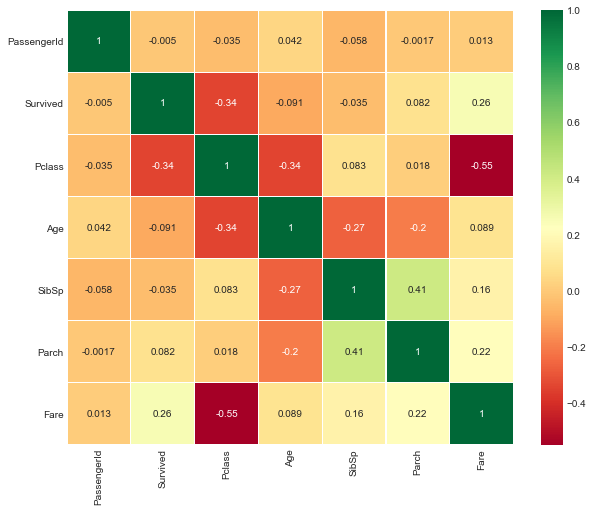

In [162]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

### Interpreting The Heatmap

The first thing to note is that only the numeric features are compared as it is obvious that we cannot correlate between alphabets or strings. Before understanding the plot, let us see what exactly correlation is.

**POSITIVE CORRELATION:** If an **increase in feature A leads to increase in feature B, then they are positively correlated**. A value **1 means perfect positive correlation**.

**NEGATIVE CORRELATION:** If an **increase in feature A leads to decrease in feature B, then they are negatively correlated**. A value **-1 means perfect negative correlation**.

Now lets say that two features are highly or perfectly correlated, so the increase in one leads to increase in the other. This means that both the features are containing highly similar information and there is very little or no variance in information. This is known as **MultiColinearity** as both of them contains almost the same information.

So do you think we should use both of them as **one of them is redundant**. While making or training models, we should try to eliminate redundant features as it reduces training time and many such advantages.

Now from the above heatmap,we can see that the features are not much correlated. The highest correlation is between **SibSp and Parch i.e 0.41**. So we can carry on with all features.

## Part2: Feature Engineering and Data Cleaning

Now what is Feature Engineering?

Whenever we are given a dataset with features, it is not necessary that all the features will be important. There maybe be many redundant features which should be eliminated. Also we can get or add new features by observing or extracting information from other features.

An example would be getting the Initals feature using the Name Feature. Lets see if we can get any new features and eliminate a few. Also we will tranform the existing relevant features to suitable form for Predictive Modeling.

## Age_band

#### Problem With Age Feature:
As I have mentioned earlier that **Age is a continous feature**, there is a problem with Continous Variables in Machine Learning Models.

**Eg:**If I say to group or arrange Sports Person by **Sex**, We can easily segregate them by Male and Female.

Now if I say to group them by their **Age**, then how would you do it? If there are 30 Persons, there may be 30 age values. Now this is problematic.

We need to convert these **continous values into categorical values** by either Binning or Normalisation. I will be using binning i.e group a range of ages into a single bin or assign them a single value.

Okay so the maximum age of a passenger was 80. So lets divide the range from 0-80 into 5 bins. So 80/5=16.
So bins of size 16.

In [163]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head(2)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare Cabin Embarked Initial  Age_band  
0      0  A/5 21171   7.2500   NaN        S      Mr         1  
1      0   PC 17599  71.2833   C85        C     Mrs         2

In [164]:
#checking the number of passenegers in each band
data['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')

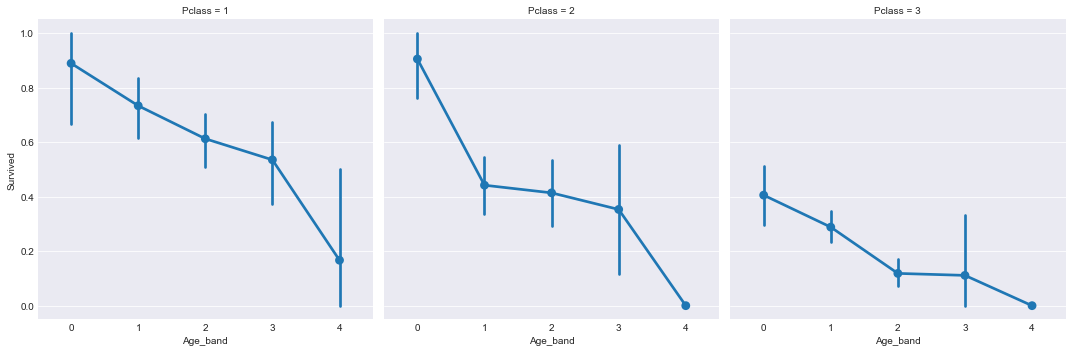

In [165]:
sns.factorplot('Age_band','Survived',data=data,col='Pclass')
plt.show()

True that..the survival rate decreases as the age increases irrespective of the Pclass.

## Family_Size and Alone
At this point, we can create a new feature called "Family_size" and "Alone" and analyse it. This feature is the summation of Parch and SibSp. It gives us a combined data so that we can check if survival rate have anything to do with family size of the passengers. Alone will denote whether a passenger is alone or not.

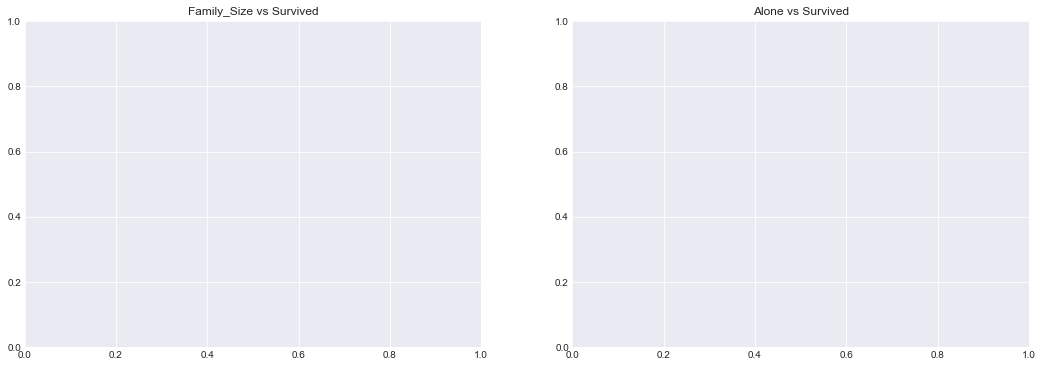

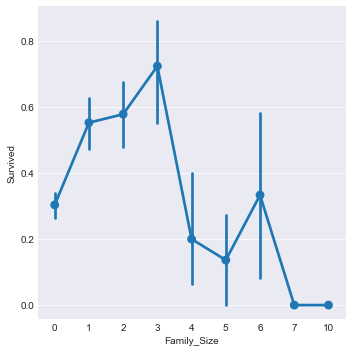

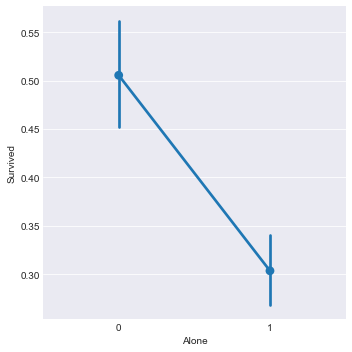

In [166]:
data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

f,ax=plt.subplots(1,2,figsize=(18,6))
sns.factorplot('Family_Size','Survived',data=data,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.factorplot('Alone','Survived',data=data,ax=ax[1])
ax[1].set_title('Alone vs Survived')
plt.show()

**Family_Size=0 means that the passeneger is alone.** Clearly, if you are alone or family_size=0,then chances for survival is very low. For family size > 4,the chances decrease too. This also looks to be an important feature for the model. Lets examine this further.

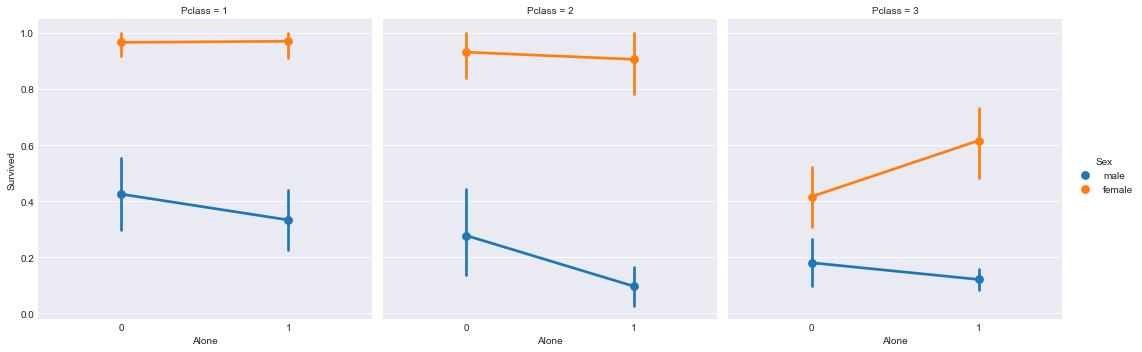

In [167]:
sns.factorplot('Alone','Survived',data=data,hue='Sex',col='Pclass')
plt.show()

It is visible that being alone is harmful irrespective of Sex or Pclass except for Pclass3 where the chances of females who are alone is high than those with family.

## Fare_Range

Since fare is also a continous feature, we need to convert it into ordinal value. For this we will use **pandas.qcut**.

So what **qcut** does is it splits or arranges the values according the number of bins we have passed. So if we pass for 5 bins, it will arrange the values equally spaced into 5 seperate bins or value ranges.

In [168]:
data['Fare_Range']=pd.qcut(data['Fare'],4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

As discussed above, we can clearly see that as the **fare_range increases, the chances of survival increases.**

Now we cannot pass the Fare_Range values as it is. We should convert it into singleton values same as we did in **Age_Band**

In [110]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

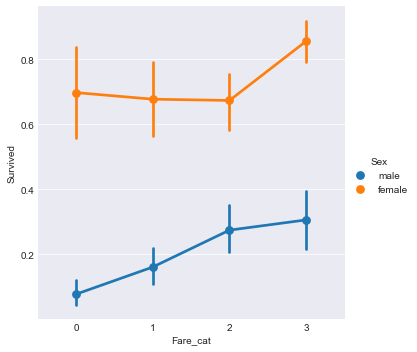

In [111]:
sns.factorplot('Fare_cat','Survived',data=data,hue='Sex')
plt.show()

Clearly, as the Fare_cat increases, the survival chances increases. This feature may become an important feature during modeling along with the Sex.

## Converting String Values into Numeric

Since we cannot pass strings to a machine learning model, we need to convert features loke Sex, Embarked, etc into numeric values.

In [112]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

### Dropping UnNeeded Features

**Name**--> We don't need name feature as it cannot be converted into any categorical value.

**Age**--> We have the Age_band feature, so no need of this.

**Ticket**--> It is any random string that cannot be categorised.

**Fare**--> We have the Fare_cat feature, so unneeded

**Cabin**--> A lot of NaN values and also many passengers have multiple cabins. So this is a useless feature.

**Fare_Range**--> We have the fare_cat feature.

**PassengerId**--> Cannot be categorised.

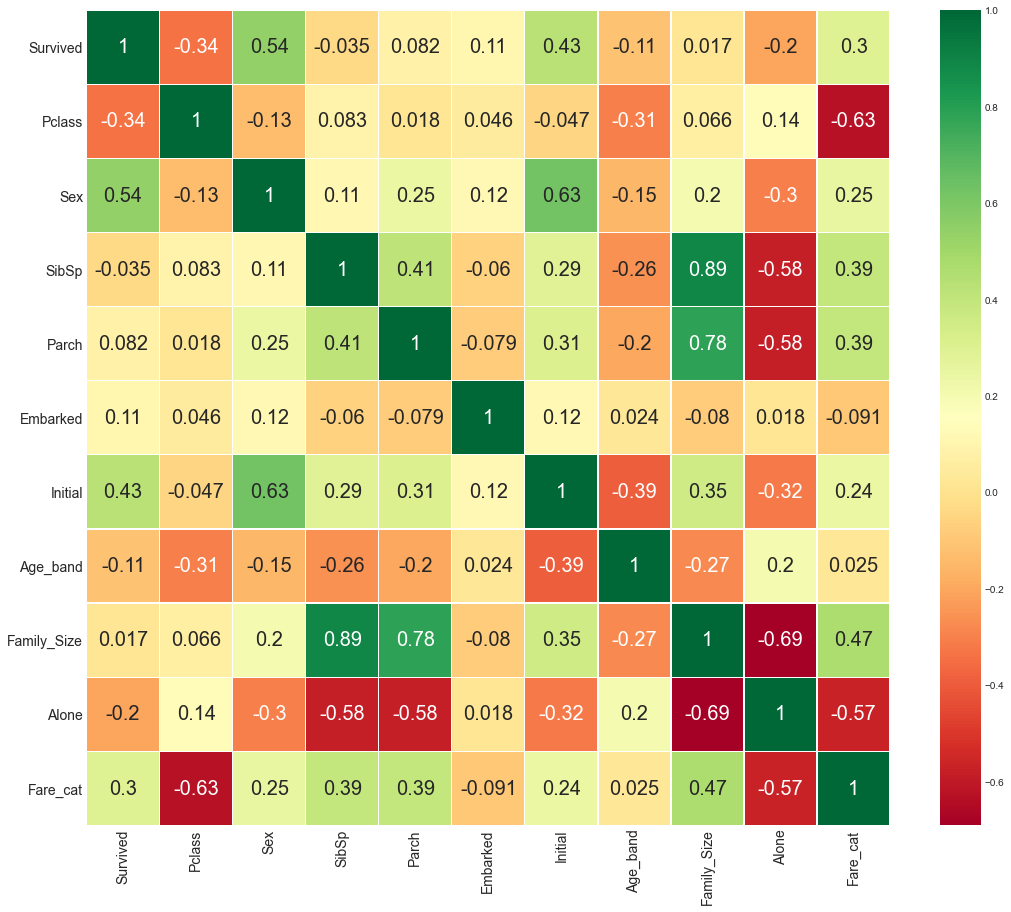

In [113]:
data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Now the above correlation plot, we can see some positively related features. Some of them being **SibSp andd Family_Size** and **Parch and Family_Size** and some negative ones like **Alone and Family_Size.**

#### 2.4.4. Датасет Ames house price

In [13]:
all_data=pd.concat((train_df,test_df)).reset_index(drop=True)
x_saleprice=train_df["SalePrice"]
all_data.drop(["SalePrice"],axis=1,inplace=True)
all_data.shape

(2919, 80)


Let us import some modules and libraries for statistical modelling and then a take a look at the saleprice distribution.Since it is really important to make your target variables ready to perform training.

In [14]:
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


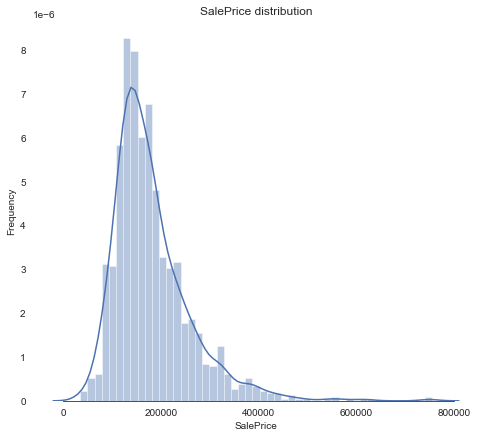

In [15]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train_df['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

Here , the SalePrice is skewed to the right. This can be a problem because normally machine learning models don't do well with data that are not normally distributed. We can apply a log(1+x) tranform to fix the skew.

In [16]:
# log(1+x) transform
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

Let us check the distribution again


 mu = 12.02 and sigma = 0.40



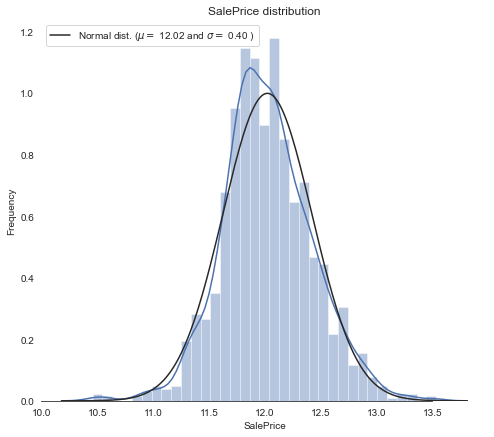

In [17]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train_df['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

Woww! our saleprice feature is now normally distributed.

In [18]:
# Remove outliers
train_df.drop(train_df[(train_df['OverallQual']<5) & (train_df['SalePrice']>200000)].index, inplace=True)
train_df.drop(train_df[(train_df['GrLivArea']>4500) & (train_df['SalePrice']<300000)].index, inplace=True)
train_df.reset_index(drop=True, inplace=True)

## Data cleaning

***Examining the dataset for null values with the help of a heatmap from seaborn ,we will then deal with the missing values accordingly.***

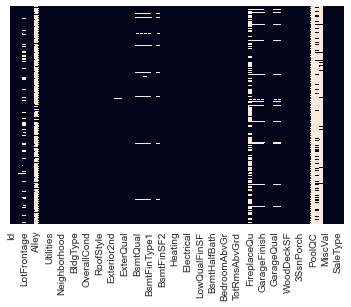

In [19]:
sns.heatmap(all_data.isnull(),yticklabels=False,cbar=False)

## Dealing with missing values

In [20]:
all_data['LotFrontage']=all_data['LotFrontage'].fillna(all_data['LotFrontage'].mean())
all_data.drop(['Alley'],inplace=True,axis=1)
all_data['BsmtQual']=all_data['BsmtQual'].fillna(all_data['BsmtQual'].mode()[0])
all_data['BsmtCond']=all_data['BsmtCond'].fillna(all_data['BsmtCond'].mode()[0])
all_data['FireplaceQu']=all_data['FireplaceQu'].fillna(all_data['FireplaceQu'].mode()[0])
all_data['GarageType']=all_data['GarageType'].fillna(all_data['GarageType'].mode()[0])
all_data['GarageQual']=all_data['GarageQual'].fillna(all_data['GarageQual'].mode()[0])
all_data['GarageCond']=all_data['GarageCond'].fillna(all_data['GarageCond'].mode()[0])

all_data.drop(['PoolQC','Fence','MiscFeature','Id'],inplace=True,axis=1)
all_data['MasVnrType']=all_data['MasVnrType'].fillna(all_data['MasVnrType'].mode()[0])
all_data['MasVnrArea']=all_data['MasVnrArea'].fillna(all_data['MasVnrArea'].mode()[0])
all_data['BsmtExposure']=all_data['BsmtExposure'].fillna(all_data['BsmtExposure'].mode()[0])
all_data['BsmtFinType1']=all_data['BsmtFinType1'].fillna(all_data['BsmtFinType1'].mode()[0])
all_data['BsmtFinType2']=all_data['BsmtFinType2'].fillna(all_data['BsmtFinType2'].mode()[0])
all_data.drop(['GarageYrBlt'],inplace=True,axis=1)
all_data['GarageFinish']=all_data['GarageFinish'].fillna(all_data['GarageFinish'].mode()[0])
all_data['MSZoning']=all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])                                               

In [21]:
all_data['Utilities']=all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])
all_data['Exterior1st']=all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd']=all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['BsmtFinType1']=all_data['BsmtFinType1'].fillna(all_data['BsmtFinType1'].mode()[0])
all_data['BsmtFinSF1']=all_data['BsmtFinSF1'].fillna(all_data['BsmtFinSF1'].mean())
all_data['BsmtFinSF2']=all_data['BsmtFinSF2'].fillna(all_data['BsmtFinSF2'].mean())
all_data['BsmtUnfSF']=all_data['BsmtUnfSF'].fillna(all_data['BsmtUnfSF'].mean())
all_data['TotalBsmtSF']=all_data['TotalBsmtSF'].fillna(all_data['TotalBsmtSF'].mean())
all_data['BsmtFullBath']=all_data['BsmtFullBath'].fillna(all_data['BsmtFullBath'].mode()[0])
all_data['BsmtHalfBath']=all_data['BsmtHalfBath'].fillna(all_data['BsmtHalfBath'].mode()[0])
all_data['KitchenQual']=all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Functional']=all_data['Functional'].fillna(all_data['Functional'].mode()[0])
all_data['GarageCars']=all_data['GarageCars'].fillna(all_data['GarageCars'].mean())
all_data['GarageArea']=all_data['GarageArea'].fillna(all_data['GarageArea'].mean())
all_data['SaleType']=all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

Let us now ensure that there are not any missing values

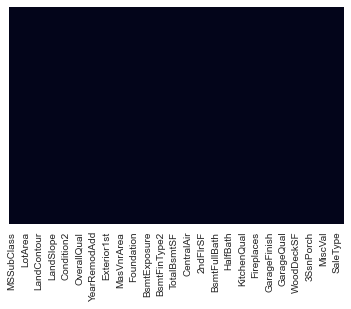

In [22]:
sns.heatmap(all_data.isnull(),yticklabels=False,cbar=False)

 ### Awesome!! we are good to go

## Handling categorical features

In [23]:

categorical_feature_mask = all_data.dtypes==object
# filter categorical columns using mask and turn it into alist
categorical_cols = all_data.columns[categorical_feature_mask].tolist()

In [24]:
categorical_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [25]:
len(categorical_cols)

39

In [26]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
all_data[categorical_cols] = all_data[categorical_cols]\
.apply(lambda col: labelencoder.fit_transform(col.astype(str)))

In [27]:
all_data.shape

(2919, 74)

In [28]:
all_data.head()

MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  LandContour  \
0          60         3         65.0     8450       1         3            3   
1          20         3         80.0     9600       1         3            3   
2          60         3         68.0    11250       1         0            3   
3          70         3         60.0     9550       1         0            3   
4          60         3         84.0    14260       1         0            3   

   Utilities  LotConfig  LandSlope  ...  OpenPorchSF  EnclosedPorch  \
0          0          4          0  ...           61              0   
1          0          2          0  ...            0              0   
2          0          4          0  ...           42              0   
3          0          0          0  ...           35            272   
4          0          2          0  ...           84              0   

   3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SaleType  \
0          0            0         0        0       2    2008         8   
1          0            0         0        0       5    2007         8   
2          0            0         0        0       9    2008         8   
3          0            0         0        0       2    2006         8   
4          0            0         0        0      12    2008         8   

   SaleCondition  
0              4  
1              4  
2              4  
3              0  
4              4  

[5 rows x 74 columns]

#### 2.4.5. Датасет boston

In [13]:
from sklearn.datasets import load_boston

# Загрузим датасет
boston = load_boston()

In [3]:
# Посмотрим его описание
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [4]:
# Загрузим фичи для анализа
df = pd.DataFrame(boston.data,columns = boston.feature_names)

In [5]:
# Добавим целевую переменную - цены на недвижимость
df["price"] = boston.target

In [6]:
# Переведем загловки столбцов в нижний регистр и посмотрим на данные
df.columns = map(str.lower, df.columns)
df.head()

crim    zn  indus  chas    nox     rm   age     dis  rad    tax  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   ptratio       b  lstat  price  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

In [ ]:
# Переведем загловки столбцов в нижний регистр и посмотрим на данные
df.columns = map(str.lower, df.columns)
df.head()

In [7]:
# Посмотрим на типы переменных и количество данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null float64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null float64
tax        506 non-null float64
ptratio    506 non-null float64
b          506 non-null float64
lstat      506 non-null float64
price      506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


Теперь мы готовы к исследованию взаимосвязей. Выберем факторы, которые хочется поисследовать из списка:

In [8]:
research_list = ["crim", "zn", "indus", "nox", "rm", "age", "dis", "rad", "lstat", "price"]

In [9]:
# Остсортируем только интересные нам колонки
df[research_list].head()

crim    zn  indus    nox     rm   age     dis  rad  lstat  price
0  0.00632  18.0   2.31  0.538  6.575  65.2  4.0900  1.0   4.98   24.0
1  0.02731   0.0   7.07  0.469  6.421  78.9  4.9671  2.0   9.14   21.6
2  0.02729   0.0   7.07  0.469  7.185  61.1  4.9671  2.0   4.03   34.7
3  0.03237   0.0   2.18  0.458  6.998  45.8  6.0622  3.0   2.94   33.4
4  0.06905   0.0   2.18  0.458  7.147  54.2  6.0622  3.0   5.33   36.2

Построим матрицу парных корреляций для отобранных данных

In [10]:
corr_m = df[research_list].corr()

In [11]:
corr_m

crim        zn     indus       nox        rm       age       dis  \
crim   1.000000 -0.199458  0.404471  0.417521 -0.219940  0.350784 -0.377904   
zn    -0.199458  1.000000 -0.533828 -0.516604  0.311991 -0.569537  0.664408   
indus  0.404471 -0.533828  1.000000  0.763651 -0.391676  0.644779 -0.708027   
nox    0.417521 -0.516604  0.763651  1.000000 -0.302188  0.731470 -0.769230   
rm    -0.219940  0.311991 -0.391676 -0.302188  1.000000 -0.240265  0.205246   
age    0.350784 -0.569537  0.644779  0.731470 -0.240265  1.000000 -0.747881   
dis   -0.377904  0.664408 -0.708027 -0.769230  0.205246 -0.747881  1.000000   
rad    0.622029 -0.311948  0.595129  0.611441 -0.209847  0.456022 -0.494588   
lstat  0.452220 -0.412995  0.603800  0.590879 -0.613808  0.602339 -0.496996   
price -0.385832  0.360445 -0.483725 -0.427321  0.695360 -0.376955  0.249929   

            rad     lstat     price  
crim   0.622029  0.452220 -0.385832  
zn    -0.311948 -0.412995  0.360445  
indus  0.595129  0.603800 -0.483725  
nox    0.611441  0.590879 -0.427321  
rm    -0.209847 -0.613808  0.695360  
age    0.456022  0.602339 -0.376955  
dis   -0.494588 -0.496996  0.249929  
rad    1.000000  0.488676 -0.381626  
lstat  0.488676  1.000000 -0.737663  
price -0.381626 -0.737663  1.000000

Теперь визуализируем полученную матрицу при помощи seaborn heatmap https://seaborn.pydata.org/generated/seaborn.heatmap.html

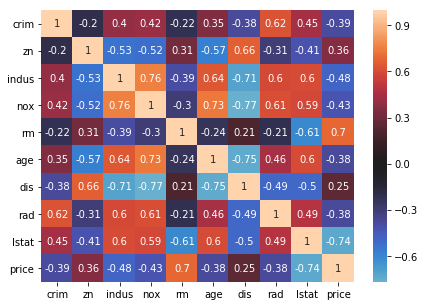

In [12]:
plt.figure(figsize=(7,5))
sns.heatmap(corr_m, center=0, annot=True)

Видно, что есть сильные обратные и прямые связи. А теперь построим диаграмму рассеяния для каждой пары признаков со связями заметной значимости c показателем price. 
Заметная значимость по шкале Чеддока - при коэффициенте корреляции от 0.5 по модулю и выше.

Коэффициент корреляции 0.695359947071539


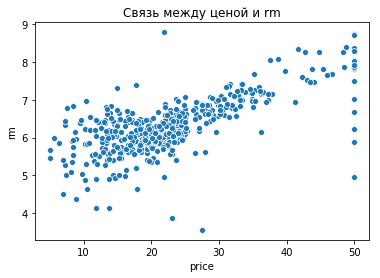

Коэффициент корреляции -0.7376627261740148


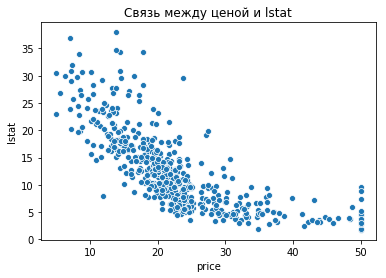

In [13]:
level = 0.5
for i in research_list[:-1]:
    curr_corr = df[i].corr(df.price)
    if abs(curr_corr) >= level:
        sns.scatterplot(x="price", y=i, data=df)
        print("Коэффициент корреляции " + str(curr_corr))
        plt.title("Связь между ценой и "+str(i))
        plt.show()

**Вывод:**  
Как можем видеть, цена на дома прямо связана с количеством комнат и обратно пропорциональна доле населения с низкими доходами.

#### 2.4.6. Датасет Yahoo

In [40]:
import pandas_datareader as pdr
from datetime import datetime
from scipy.stats import kurtosis, skew
import statsmodels.api as sm

In [27]:
# Собираем котировки за интересующий период.
start_date = datetime(2018, 1, 1)
end_date = datetime(2019, 8, 31)

In [28]:
df = pdr.get_data_yahoo(symbols="GOOG", start=start_date, end=end_date)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 419 entries, 2018-01-02 to 2019-08-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       419 non-null    float64
 1   Low        419 non-null    float64
 2   Open       419 non-null    float64
 3   Close      419 non-null    float64
 4   Volume     419 non-null    int64  
 5   Adj Close  419 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 22.9 KB


In [30]:
# Переведем загловки столбцов в нижний регистр и посмотрим на данные
df.columns = map(str.lower, df.columns)
df.head()

high          low         open        close   volume  \
Date                                                                      
2018-01-02  1066.939941  1045.229980  1048.339966  1065.000000  1237600   
2018-01-03  1086.290039  1063.209961  1064.310059  1082.479980  1430200   
2018-01-04  1093.569946  1084.001953  1088.000000  1086.400024  1004600   
2018-01-05  1104.250000  1092.000000  1094.000000  1102.229980  1279100   
2018-01-08  1111.270020  1101.619995  1102.229980  1106.939941  1047600   

              adj close  
Date                     
2018-01-02  1065.000000  
2018-01-03  1082.479980  
2018-01-04  1086.400024  
2018-01-05  1102.229980  
2018-01-08  1106.939941

Для изучения выберем разницу между ценой закрытия и ценой открытия.

In [31]:
# Готовим новую метрику.
df["diff_price"] = df.close - df.open

Для построения доверительного интервала необходимо, чтобы исследумая величина была распределена по Гауссову закону.
Поэтому воспользуемся функцией из первой практики для разведочного анализа.

Text(0.5, 1.0, 'График разниы между ценой закрытия и открытия')

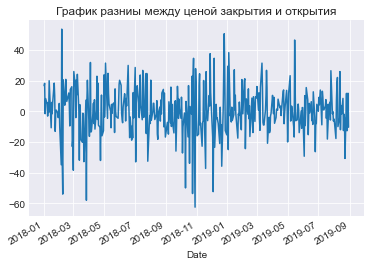

In [32]:
df.diff_price.plot()
plt.title("График разниы между ценой закрытия и открытия")

In [35]:
def my_basic_research(df=df, column = "diff_price"):
    print("Базовые метрики")
    print(df[column].describe())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df[column]))
    print("Ассиметрия ", skew(df[column]))
    
    sns.distplot(df[column])
    plt.title("Распределение метрики")

Базовые метрики
count    419.000000
mean       0.283327
std       15.785419
min      -62.389954
25%       -7.504944
50%       -0.050049
75%        9.205017
max       53.419922
Name: diff_price, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
 2.079956    2
-4.140015    2
 3.479980    2
-6.169922    2
-7.839966    2
Name: diff_price, dtype: int64
------------------------------------
Эксцесс  1.8273088490466076
Ассиметрия  -0.373693259561462


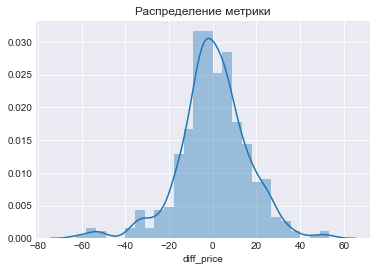

In [38]:
my_basic_research(column = "diff_price")

В целом наше распределение близко к нормальному, несмотря на остроконечный пик и наличие выбросов. 
Однако для уверенности проверим его при помощи графика QQ plot. График сравнивает квантили выборки и выбранноого распределения - в нашем случае, нормального.

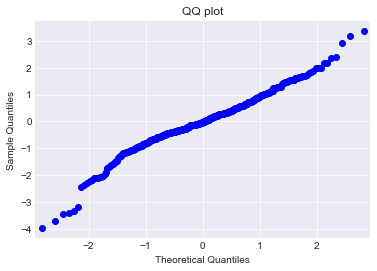

In [41]:
sm.qqplot(df.diff_price, fit = True)
plt.title("QQ plot")
plt.show()

Кажется, что можно использовать стандартные доверительные интервалы для нормального распределения.

In [42]:
def my_norm_confidence(df=df, column = "diff_price", alpha = 0.95):
    interval = stats.norm.interval(alpha, loc=df[column].mean(), scale=df[column].std())
    return interval

In [43]:
confidence = my_norm_confidence()
print(confidence)

(-30.65552705953303, 31.22218007219338)


При доверительной вероятности 95 % средняя разница между ценой закрытия и открытия не выйдет за этот интервал.
Отметим на графике полученный коридор.

Text(0.5, 1.0, 'Доверительный интервал')

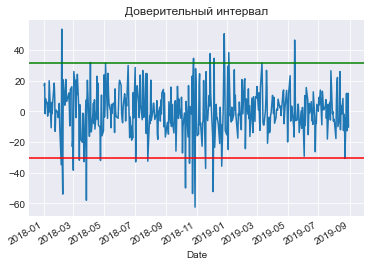

In [44]:
df.diff_price.plot()
plt.axhline(y=confidence[1], color="g", linestyle="-")
plt.axhline(y=confidence[0], color="r", linestyle="-")
plt.title("Доверительный интервал")

**Отбор аномалий при помощи доверительного интервала.**  
А если нам понадобится отметить аномальные события, выходящие за зеленую границу, то это можно сделать следующим образом

In [45]:
df["anomaly_big"] = np.where(df.diff_price > confidence[1], 1,0)

Теперь они готовы к дальнейшему исследованию.

In [46]:
df[df.anomaly_big == 1].describe()

high          low         open        close        volume  \
count    10.000000    10.000000    10.000000    10.000000  1.000000e+01   
mean   1088.186780  1040.519098  1044.146002  1083.051978  2.577930e+06   
std      50.618170    50.943488    49.937315    49.617563  7.385681e+05   
min    1028.718018   983.000000   989.010010  1025.140015  1.719200e+06   
25%    1054.092499  1018.459274  1019.470032  1053.339966  2.142750e+06   
50%    1076.454956  1029.093994  1033.424988  1071.089966  2.424350e+06   
75%    1101.607513  1035.342499  1045.827515  1084.822479  2.698075e+06   
max    1176.189941  1144.449951  1144.449951  1175.760010  4.187600e+06   

         adj close  diff_price  anomaly_big  
count    10.000000   10.000000         10.0  
mean   1083.051978   38.905975          1.0  
std      49.617563    8.221770          0.0  
min    1025.140015   31.309937          1.0  
25%    1053.339966   32.407516          1.0  
50%    1071.089966   35.969971          1.0  
75%    1084.822479   44.284973          1.0  
max    1175.760010   53.419922          1.0

#### 2.4.7. Датасет diabetes

Для работы подготовим синтетические данные - чтобы было интереснее, пусть это будет нормальное распределение N(1000, 5000) и смесь двух нормальных распределений https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.lognormal.html

Размер первой и второй выборки - 50000, третьей - 10000

In [48]:
from sklearn.datasets import load_diabetes


ns = 50000
ns_sub = 1000
n_mean = 1000
n_sigma = 5000

n1_mean = 2000
n2_mean = 6000

n1_sigma = 500
n2_sigma = 1000

In [49]:
# Нормальное распределение.
dfn = np.random.normal(n_mean, n_sigma, ns)
dfn = pd.DataFrame(dfn,columns = ["volume"])
dfn.volume = round(dfn.volume,0)

In [50]:
# Смесь нормалаьных распределение.
l1 = np.random.normal(n1_mean, n1_sigma, ns)
l2 = np.random.normal(n2_mean, n2_sigma, ns)
dfl1 = pd.DataFrame(l1,columns = ["volume"])
dfl1.volume = round(dfl1.volume,0)

dfl2 = pd.DataFrame(l2,columns = ["volume"])
dfl2.volume = round(dfl2.volume,0)

dfl = dfl1.append(dfl2)

Посмотрим на гистограммы каждой выборки

Text(0.5, 1.0, 'Гистограмма первой выборки')

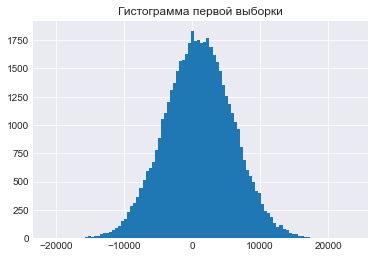

In [51]:
dfn.hist(bins = 100)
plt.title("Гистограмма первой выборки")

Text(0.5, 1.0, 'Гистограмма второй выборки')

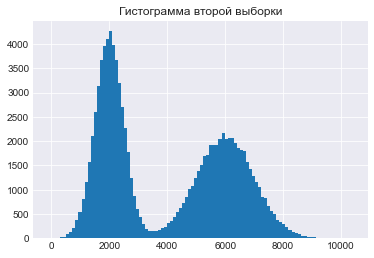

In [52]:
dfl.hist(bins = 100)
plt.title("Гистограмма второй выборки")

Посмотрим описательную статистику для каждой из выборок

In [53]:
dfn.describe()

volume
count  50000.00000
mean     995.15076
std     5022.14375
min   -21127.00000
25%    -2391.00000
50%     1001.00000
75%     4370.00000
max    23599.00000

In [54]:
dfl.describe()

volume
count  100000.000000
mean     3999.216090
std      2152.206816
min      -113.000000
25%      1997.000000
50%      3322.500000
75%      6000.000000
max     10390.000000

В первом случае у нас классическое нормальное распределение, поэтому воспользуемся правилом трех сигм

In [55]:
upper_level = dfn.volume.mean() + 3*dfn.volume.std()
lower_level = dfn.volume.mean() - 3*dfn.volume.std()
print(lower_level,upper_level)

-14071.280491303536 16061.582011303537


Дополнительноо добавим 99 квантиль для отбора совсем крупных значений

In [56]:
level_99 = np.percentile(dfn.volume, 99)

Нарисуем полученный коридор на графике

Text(0.5, 1.0, '3 sigma и 99 квантиль для нормального распределения')

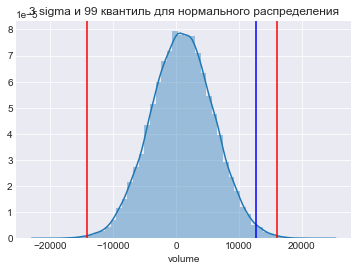

In [57]:
sns.distplot(dfn.volume)
plt.axvline(x=lower_level, color="r", linestyle="-")
plt.axvline(x=upper_level, color="r", linestyle="-")
plt.axvline(x=level_99, color="b", linestyle="-")
plt.title("3 sigma и 99 квантиль для нормального распределения")

Можно заметить, что правило трех сигм дает далее более жесткий фильтр, чем 99 квантиль.

Отфильтруем данные свыше трех сигм:

In [58]:
dfn[dfn.volume >= upper_level].describe()

volume
count     59.000000
mean   17409.847458
std     1404.943302
min    16070.000000
25%    16523.500000
50%    17034.000000
75%    17718.000000
max    23599.000000

А что со вторым датасетом? Это совершенноо точно бимодальное распределение. Убедимся, что в данном случае варианты выше не сработают.

-14071.280491303536 16061.582011303537
12755.010000000002


Text(0.5, 1.0, '3 sigma и 99 квантиль для бимодального распределения')

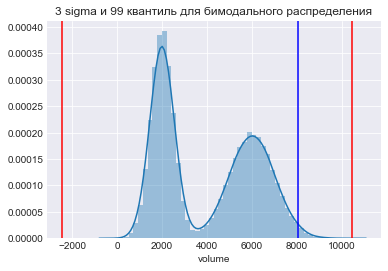

In [59]:
b_upper_level = dfl.volume.mean() + 3*dfl.volume.std()
b_lower_level = dfl.volume.mean() - 3*dfl.volume.std()
print(lower_level,upper_level)

b_level_99 = np.percentile(dfl.volume, 99)
print(level_99)

sns.distplot(dfl.volume)
plt.axvline(x=b_lower_level, color="r", linestyle="-")
plt.axvline(x=b_upper_level, color="r", linestyle="-")
plt.axvline(x=b_level_99, color="b", linestyle="-")
plt.title("3 sigma и 99 квантиль для бимодального распределения")

Да, получилось не очень. В таких случаях стоит разбить данные на кластеры - даже самым простым способом и исследовать их отдельно.
Весьма вероятно, что одна из групп и является аномальной)

Теперь оформим наши заготовки в функцию, оставив верхнюю границу от правил трех сигм и 99 квантиль, и проверим на реальных данных - медицинском датасете из набора sklearn https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes

In [60]:
def find_anomaly(df, column):
    upper_level = df[column].mean() + 3*df[column].std()
    level_99 = np.percentile(df[column], 99)
    anomaly = df[(df[column] >= upper_level)^(df[column] >= level_99)]
    return anomaly,upper_level,level_99

In [61]:
# Загрузим датасет
medical = load_diabetes()

In [62]:
# Посмотрим его описание
print(medical.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [63]:
# Загрузим фичи для анализа
df = pd.DataFrame(medical.data,columns = medical.feature_names)

# Добавим целевую переменную - цены на недвижимость
df["health_status"] = medical.target

# Переведем загловки столбцов в нижний регистр и посмотрим на данные
df.columns = map(str.lower, df.columns)
df.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  health_status  
0 -0.002592  0.019908 -0.017646          151.0  
1 -0.039493 -0.068330 -0.092204           75.0  
2 -0.002592  0.002864 -0.025930          141.0  
3  0.034309  0.022692 -0.009362          206.0  
4 -0.002592 -0.031991 -0.046641          135.0

Найдем людей с аномальным показателем health_status

In [64]:
df.health_status.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: health_status, dtype: float64

In [65]:
anomaly = find_anomaly(df=df, column = "health_status")
len(anomaly[0])/len(df)

0.011312217194570135

Мы обнаружили 1 % необычных пациентов с самой высокой прогрессией болезни, и теперь можем выделить их в отдельную группу.

In [66]:
anomaly[0]

age       sex       bmi        bp        s1        s2        s3  \
32   0.034443  0.050680  0.125287  0.028758 -0.053855 -0.012900 -0.102307   
138  0.034443  0.050680  0.111276  0.076958 -0.031840 -0.033881 -0.021311   
256 -0.049105 -0.044642  0.160855 -0.046985 -0.029088 -0.019790 -0.047082   
290  0.059871  0.050680  0.076786  0.025315  0.001183  0.016849 -0.054446   
362  0.019913  0.050680  0.104809  0.070073 -0.035968 -0.026679 -0.024993   

           s4        s5        s6  health_status  
32   0.108111  0.000271  0.027917          341.0  
138 -0.002592  0.028017  0.073480          336.0  
256  0.034309  0.028017  0.011349          346.0  
290  0.034309  0.029936  0.044485          332.0  
362 -0.002592  0.003712  0.040343          321.0

Отметим найденные границы на распределении.

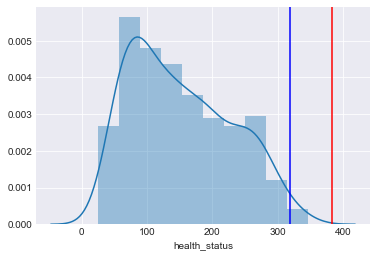

In [67]:
sns.distplot(df.health_status)
plt.axvline(x=anomaly[1], color="r", linestyle="-")
plt.axvline(x=anomaly[2], color="b", linestyle="-")

#### 2.4.8. Датасет Tesla

In [ ]:
from pandas.tseries.offsets import MonthEnd

def get_monthly_dates(data):
    date = data.index[0]
    dates = []
    while date < data.index[-1]:
        date = date + MonthEnd(1)
        dates.append(date)
    return dates

In [ ]:
data.index[0]

In [ ]:
import math

In [ ]:
year = 2010

fig, axes = plt.subplots(2, 2, figsize=(20,20))

for row in range(2):
    for column in range(2):
        year_data = data[data.index.year == year]
        dates = get_monthly_dates(year_data)
        axes[row, column].plot(year_data.index, year_data['High'], label='High', color='g')
        axes[row, column].plot(year_data.index, year_data['Low'], label='Low', color='r')
        axes[row, column].set_title('Stock prices in {}, US$'.format(year))
        axes[row, column].set_xlabel('Dates')
        axes[row, column].set_ylabel('Stock prices, US$')
        axes[row, column].set_xticks(dates)
        axes[row, column].set_xticklabels([pd.to_datetime(str(date)).strftime("%m.%d.%Y")\
                                           for date in dates], rotation=45)
        yticks = range(math.floor(min(year_data['Low'])), math.ceil(max(year_data['High'])), 5)
        axes[row, column].set_yticks(yticks)
        axes[row, column].set_yticklabels(yticks)
        
        axes[row, column].grid()
        axes[row, column].legend(loc='upper left', title='Stock prices')
        
        year += 1
        
plt.show()

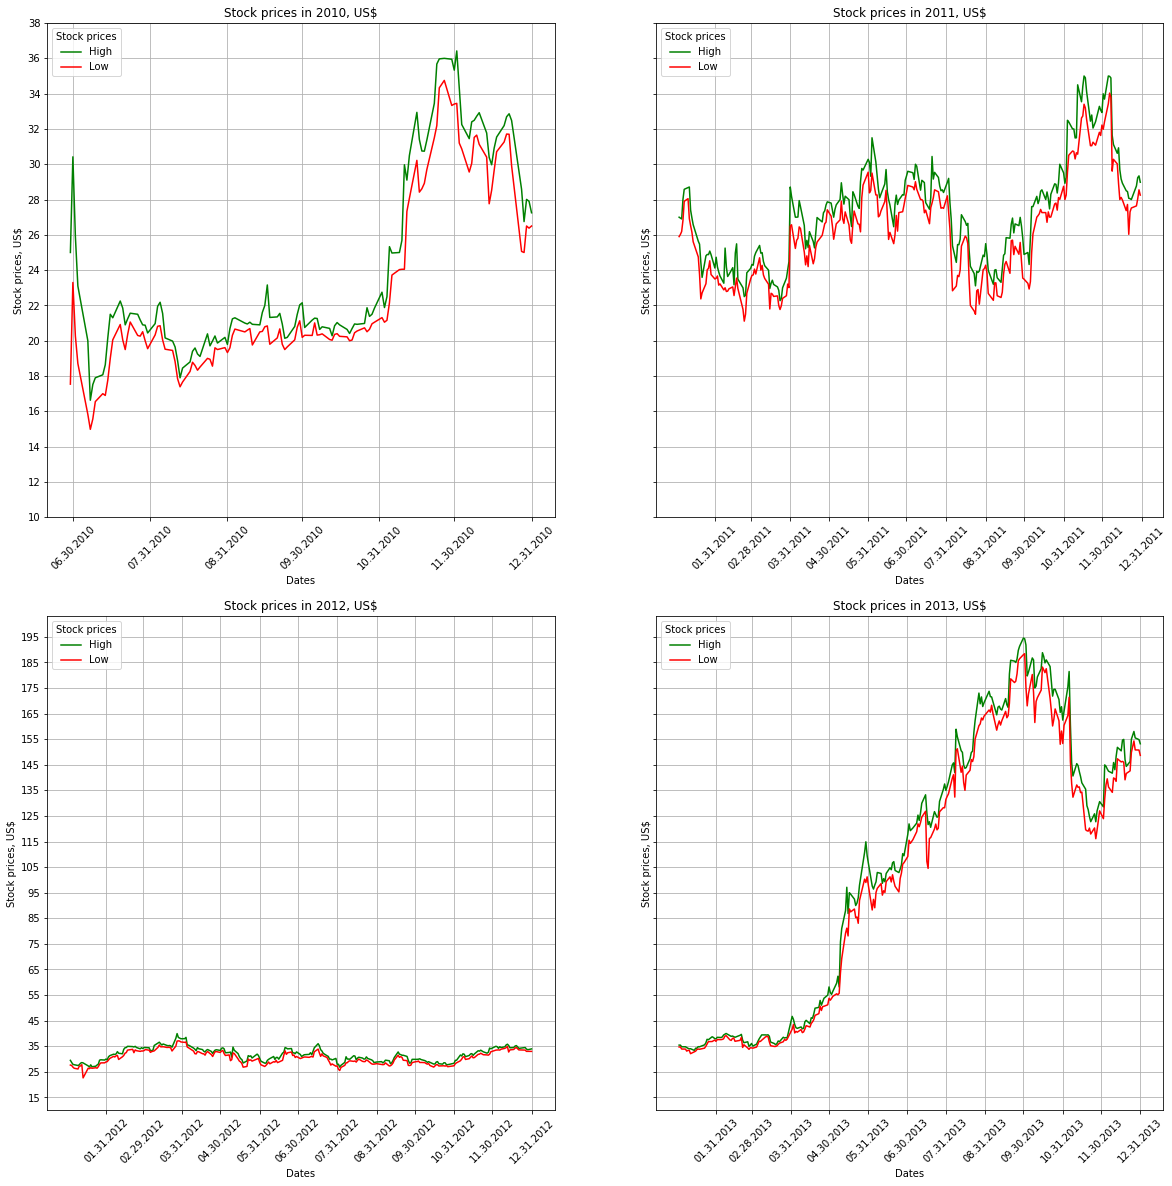

In [ ]:
year = 2010

fig, axes = plt.subplots(2, 2, figsize=(20,20), sharey='row')

for row in range(2):
    for column in range(2):
        year_data = data[data.index.year == year]
        dates = get_monthly_dates(year_data)
        axes[row, column].plot(year_data.index, year_data['High'], label='High', color='g')
        axes[row, column].plot(year_data.index, year_data['Low'], label='Low', color='r')
        axes[row, column].set_title('Stock prices in {}, US$'.format(year))
        axes[row, column].set_xlabel('Dates')
        axes[row, column].set_ylabel('Stock prices, US$')
        axes[row, column].set_xticks(dates)
        axes[row, column].set_xticklabels([pd.to_datetime(str(date)).strftime("%m.%d.%Y")\
                                           for date in dates], rotation=45)        
        axes[row, column].grid()
        axes[row, column].legend(loc='upper left', title='Stock prices')
        
        year += 1
        
plt.setp(axes[0:], yticks=range(10, 40, 2), yticklabels=range(10, 40, 2))
plt.setp(axes[1:], yticks=range(15, 200, 10), yticklabels=range(15, 200, 10))
plt.show()

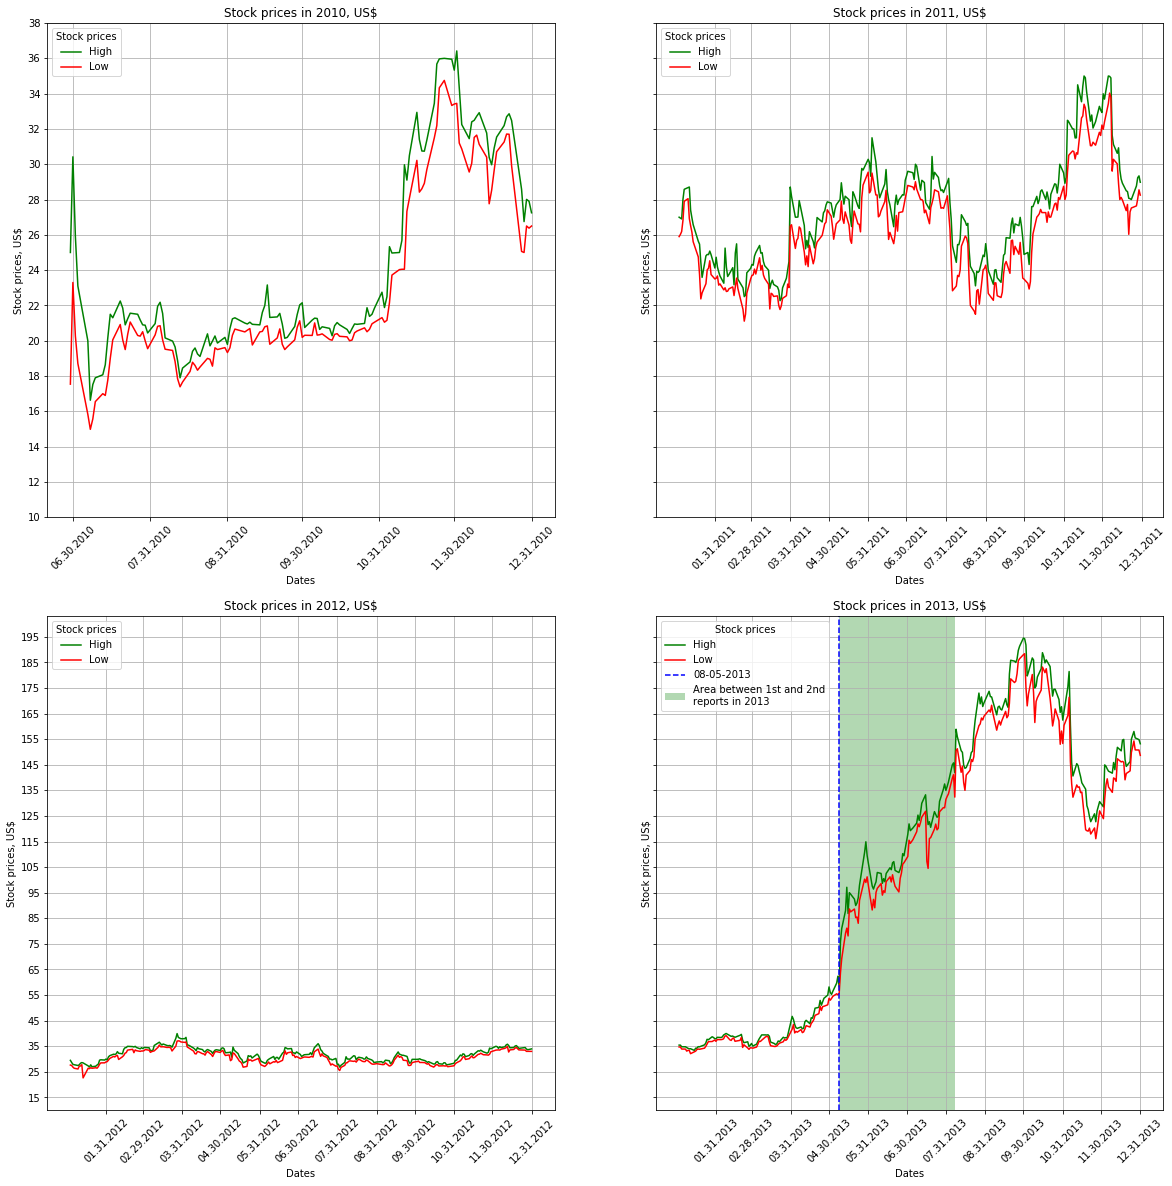

In [ ]:
year = 2010
first_profit_report_date = pd.Timestamp(day=8, month=5, year=2013)
second_after_profit_report_date = pd.Timestamp(day=7, month=8, year=2013)

fig, axes = plt.subplots(2, 2, figsize=(20,20), sharey='row')

for row in range(2):
    for column in range(2):
        year_data = data[data.index.year == year]
        dates = get_monthly_dates(year_data)
        axes[row, column].plot(year_data.index, year_data['High'], label='High', color='g')
        axes[row, column].plot(year_data.index, year_data['Low'], label='Low', color='r')
        axes[row, column].set_title('Stock prices in {}, US$'.format(year))
        axes[row, column].grid()
        axes[row, column].set_xticks(dates)
        axes[row, column].set_xticklabels([pd.to_datetime(str(date)).strftime("%m.%d.%Y")\
                                           for date in dates], rotation=45)
        year += 1

        axes[row, column].legend(loc='upper left', title='Stock prices')

plt.setp(axes[0:], yticks=range(10, 40, 2), yticklabels=range(10, 40, 2))
plt.setp(axes[1:], yticks=range(15, 200, 10), yticklabels=range(15, 200, 10))
plt.setp(axes, xlabel='Dates', ylabel='Stock prices, US$')

axes[1, 1].axvline(first_profit_report_date, ls='--', color='b', label=first_profit_report_date.strftime("%d-%m-%Y"))
axes[1, 1].axvspan(first_profit_report_date, second_after_profit_report_date, facecolor='g', alpha=0.3, 
                   label='Area between 1st and 2nd\nreports in 2013')
plt.legend(loc='upper left', title='Stock prices')

plt.show()

### 2.5. Корреляционный анализ

In [ ]:
pair_list = []
level = 0.3

for i in df.columns:
    for j in df.columns:
        check_set = set([i, j])
        if i == j:
            continue
        if check_set in pair_list:
            continue
        pair_list += [check_set]
        
        curr_corr = df[i].corr(df[j])
        if 0.1 <= abs(curr_corr) < 0.3:
            if curr_corr > 0:
                print('Между {} и {} слабая прямая связь'.format(i, j))
            else:
                print('Между {} и {} слабая обратная связь'.format(i, j))
        
        elif 0.3 <= abs(curr_corr) < 0.5:
            if curr_corr > 0:
                print('Между {} и {} умеренная прямая связь'.format(i, j))
            else:
                print('Между {} и {} умеренная обратная связь'.format(i, j))
                
        elif 0.5 <= abs(curr_corr) < 0.7:
            if curr_corr > 0:
                print('Между {} и {} заметная прямая связь'.format(i, j))
            else:
                print('Между {} и {} заметная обратная связь'.format(i, j))
                
        elif 0.7 <= abs(curr_corr) < 0.9:
            if curr_corr > 0:
                print('Между {} и {} высокая прямая связь'.format(i, j))
            else:
                print('Между {} и {} высокая обратная связь'.format(i, j))
                
        elif 0.9 <= abs(curr_corr) <= 0.99:
            if curr_corr > 0:
                print('Между {} и {} весьма высокая прямая связь'.format(i, j))
            else:
                print('Между {} и {} весьма высокая обратная связь'.format(i, j))
                
        else:
            print('Между {} и {} связи не наблюдается'.format(i, j))

### 2.6. Заполнение пропущенных значений.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


imp_mean = IterativeImputer(random_state=0)
imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])
IterativeImputer(random_state=0)
X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
imp_mean.transform(X)

## 3. Результаты и выводы

Пора подвести основные итоги и сделать выводы, которые могут быть полезны и интересны не только организаторам платформы Kiva,
но и всему сообществу неравнодушных людей, которые стремятся сделать этот мир немного лучше.
 - Прежде всего необходимо отметить очень важную и знаменательную роль площадки Kiva и её сообщества. Для большого числа
 людей в совершенно разных частях нашей планеты Kiva играет важнейшую роль в части поддержки операционной и хозяйственной
 деятельности, активно дополняя, а часто выступая в роли частного банковского сектора.
 - В каждый момент времени стоит оказывать адресную помощь странам и регионам, которые больше всего недофинансированы
 относительно других. Это страны с высоким уровнем бедности, в которых люди могут позволить себе выплачивать суммы
 значительно мЕньшие, чем в других странах. Как никогда стоит обратить внимание сообщества Kiva и направить усилия на
 поддержку самых нуждающихся! Такие заявки могут быть отражены в отдельных категориях
и включать призывы в свои заголовки: Неотложные нужды, Срочно, Истекает срок финансирования.
 - Используя положительный опыт Филиппин, стоит стимулировать рост выдачи небольших по сумме и сроку погашения займов,
 которые обеспечат бОльшую занятость населения и рост деловой активности. По возможности, стоит делить заявки из небогатых
 стран на небольшие и короткие займы, каждый из которых будет очередным маленьким шагом в большом деле.
 - Когда дело касается возможностей для развития человека — границы между мужчинами и женщинами стираются. Стоит стремиться
 к обеспечению доступа к финансированию для женщин и мужчин в равной степени и обратить внимание на те страны и регионы,
 где пока этот баланс нарушен. Например, для таких стран, как Самоа, Либерия, Того, выводить на главную страницу сначала
 займы от мужчин. Отличным шагом станет публикация личных историй и
примеров женщин и мужчин, например, в интернет-издательствах, на блогинг-платформах, таких как medium.com, а также в
видеоблоге Kiva на youtube.com.
 - Приоритетными должны становиться заявки, направленные на развитие отраслей с высокой добавленной стоимостью и
 стимулированием производств, так как они являются движущей силой и по цепочке начинают задействовать другие отрасли.
 А именно строительство, производство, лёгкая промышленность. Здесь очень кстати будет использование умных рекомендательных
 систем на сайте Kiva.org, которые с бОльшей вероятностью будут
подсказывать такие заявки.
 - Всё ещё довольна высока доля заявок, направленных на удовлетворение самых базовых человеческих потребностей.
 Такие просьбы не должны оставаться незамеченными, но быть первыми кандидатами на главной странице. Недопустимы такие
 ситуации, когда, например, в Нигерии люди ждут жизненно важную чистую воду по 10 дней. Дайджест таких заявок можно включать
 в регулярные почтовые рассылки всем участникам сообщества Kiva, когда-либо
принимавшим участие в финансировании проектов.
 - Финансирование заявок на крупные суммы и долгосрочные проекты тоже работает. Для части стран возможность использовать
 Kiva будет играть решающую роль в формировании и реализации инфраструктурных и системообразующих проектов.
 - Для ряда регионов и стран присутствия, таких как Южная Азия, в частности Пакистан и Индия, есть отличные перспективы
 для расширения присутствия и деятельности со стороны сообщества Kiva.
 - Нередки случаи проявлений неравенства между странами, таких как, например, длительные ожидания финансирования для части
 заявок с совсем небольшими суммами. Мы уверены, что в силах организаторов платформы Kiva и сообщества сглаживать такие
 явные неравенства, регулируя результаты поисковой выдачи, наполнение рассылок и рекомендуемых заявок для участников
 сообщества.